# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


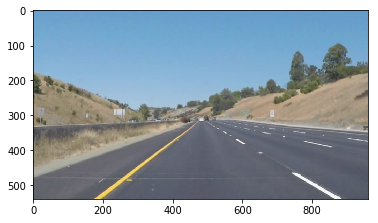

In [2]:
#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg',0)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

RMaxline [746, 462, 886, 539, 0.55000000000000004, 159.7779709471866]
RMaxline2 [483, 317, 886, 539, 0.55000000000000004, 159.7779709471866]
LMaxline [176, 539, 482, 317, -0.72549019607843135, 378.0476160485607]
LMaxline [176, 539, 482, 317, -0.72549019607843135, 378.0476160485607]
test to see 174 539
lmax [174, 540, 482, 317, -0.72549019607843135, 378.0476160485607]
Lines 60
Image Sizes 540   960  
Image Sizes 540   960  


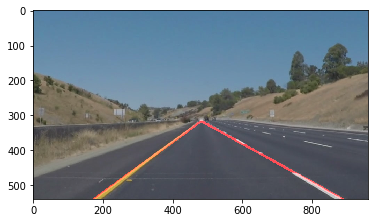

In [13]:
import math

from numpy import *

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #*******************************************************************        
    #Initialise Variables
    linePos=[[0 for x in range(6)] for y in range(100)] 
    lineNeg=[[0 for x in range(6)] for y in range(100)] 
    slope=[]
    slopePos=[], lenPos =[], [];
    slopeNeg=[]; lenNeg=[]
    index=0; indexNeg=0; indexPos=0;
    maxLenPos=0
    maxLenPosLine=[0,0,0,0]
    maxLenNeg=0
    maxLenNegLine=[0,0,0,0]
    imageShape = img.shape
    #*******************************************************************    
    
    
    #*******************************************************************    
    #Get all Hough transforms in an array and identify the maximum
    
    for line in lines:
     
        for x1,y1,x2,y2 in line:
            
            slop = ((y2-y1)/(x2-x1))
                       
            if slop > 0 and isfinite(slop) != False:
                
                #right side of road
                intercept = y1-(slop*x1)
                bottomX = int((imageShape[0]-intercept)/slop)
                
                linelength = math.sqrt(pow((x2-x1),2)+pow((y2-y1),2))
                element = x1,y1,x2,y2,slop,linelength
                linePos[indexPos] = element
                #print('iP', indexPos)
                
                if linelength > maxLenPos:
                    maxLenPos=linelength
                    maxLenPosLine = [x1,y1,x2,y2]
                    
                indexPos = indexPos+1
                
                
                
            if slop < 0 and isfinite(slop) != False:
                #Left side of road
                
                intercept = y1-(slop*x1)
                
                bottomx2 = int((imageShape[0]-intercept)/slop)
                
                linelength = math.sqrt(pow((x2-x1),2)+pow((y2-y1),2))
                element = x1,y1,x2,y2,slop,linelength
                lineNeg[indexNeg] = element
                
                if linelength > maxLenNeg:
                    maxLenNeg=linelength
                    maxLenNegLine = [x1,y1,x2,y2]
                    
                indexNeg = indexPos+1
                    
        index=index+1
    #*******************************************************************    
        
        
    #*******************************************************************        
    #extend line right hand side
    linePos.sort(key=lambda x: x[5], reverse=True) #sort
    
    #RmaxLine = list(linePos[0]) 
    #print('RMaxline', RmaxLine)
    ind1 = 0;ind2 =0; RightmaxLine=RmaxLine[1]
    
    #extend road line upward!
    for element in linePos:    
        
        if ((RmaxLine[1]-element[1] > 5) and element[5] >10 and element[4] >0.1 and element[0] >300) :
            RmaxLine[1] =element[1]
            RmaxLine[0] =element[0]
            break
        ind1 =ind1+1
        
    #extend road line downward!
    for element in linePos:    
        
        if ((RmaxLine[3]-element[3] < -6) and element[5] >10 and element[4] >0.1  and element[0] >300) :
            RmaxLine[2] =element[2]
            RmaxLine[3] =element[3]
            break
        ind2 =ind2+1
        
    #print('RMaxline2', RmaxLine)    
    #Calculate new slope and new points of right line
    Pslope = ((RmaxLine[3]-RmaxLine[1])/(RmaxLine[2]-RmaxLine[0]))
    Pintercept = (RmaxLine[1])-(Pslope*RmaxLine[0])
    RmaxLine[1]=imageShape[0]
    RmaxLine[0] = int((imageShape[0]-Pintercept)/Pslope)
    
    RmaxLine[3]=int(imshape[0]/1.7)
    RmaxLine[2] = int((RmaxLine[3]-Pintercept)/Pslope)
    #*******************************************************************            
    
    
    #*******************************************************************                
    #extend line left hand side and calculate new slope
      
    lineNeg.sort(key=lambda x: x[5], reverse=True)
    
    LmaxLine = list(lineNeg[0])
    print('LMaxline', LmaxLine)
    ind1 = 0;ind2 =0; LeftmaxLine=LmaxLine[1]
    
    
    #extend road line upward!
    for element in lineNeg:    
         
        if ((LmaxLine[3]-element[3] > 6) and element[5] >10 and element[4] <-0.1 and element[0] <660) :
            LmaxLine[2] =element[2]
            LmaxLine[3] =element[3]
            break
        ind1 =ind1+1
    
      #extend road line downward!
    for element in lineNeg:    
        
        if ((LmaxLine[1]-element[1] < -6) and element[5] >10 and element[4] <-0.1 and element[0] <660) :
            LmaxLine[0] =element[0]
            LmaxLine[1] =element[1]
            break
        ind2 =ind2+1
    
    print('LMaxline', LmaxLine)
    
    #Calculate new slope and new points or line
    Nslope = ((LmaxLine[3]-LmaxLine[1])/(LmaxLine[2]-LmaxLine[0]))
    Nintercept = (LmaxLine[1])-(Nslope*LmaxLine[0])
    LmaxLine[1]=imageShape[0]
    LmaxLine[0] = int((imageShape[0]-Nintercept)/Nslope)
    
    LmaxLine[3]=int(imshape[0]/1.7)
    LmaxLine[2] = int((LmaxLine[3]-Nintercept)/Nslope)
    #*******************************************************************            
    
    
    
    print('test to see',LmaxLine[0], LeftmaxLine )
    
    print('lmax',LmaxLine)
   
    cv2.line(img, (RmaxLine[0], RmaxLine[1]), (RmaxLine[2], RmaxLine[3]), color, thickness)
    cv2.line(img, (LmaxLine[0], LmaxLine[1]), (LmaxLine[2], LmaxLine[3]), color, thickness)
            
        
    return img




def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

grayIm = grayscale(image)
canim = canny(grayIm, 50, 150)

gbim = gaussian_blur(canim, 5)

imshape = gbim.shape
vertices = np.array([[(15,imshape[0]),(480, imshape[0]/1.7), (imshape[1]-475, imshape[0]/1.7), (imshape[1]-10,imshape[0])]], dtype=np.int32)


roiIm = region_of_interest(gbim, vertices)
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = (np.pi/180) # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments


#hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
[HLIm, linesIM] = hough_lines(roiIm,rho,theta,threshold, min_line_length,max_line_gap )

lineNo = len(linesIM)
lineNoStr =str(lineNo)

test = weighted_img(HLIm, image)

size = HLIm.shape
size = image.shape
size1 = image.shape

plt.imshow(test) 
mpimg.imsave("test_images/withLane/whiteCarLaneSwitch.png", test)


print('Lines', lineNoStr)

print('Image Sizes', size[0],' ', size[1],' ')
print('Image Sizes', size1[0],' ', size1[1],' ')


In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'Thumbs.db',
 'whiteCarLaneSwitch.jpg',
 'WithLane']

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):


    grayIm = grayscale(image)
    canim = canny(grayIm, 50, 150)

    gbim = gaussian_blur(canim, 5)

    imshape = gbim.shape
    vertices = np.array([[(15,imshape[0]),(480, imshape[0]/1.7), (imshape[1]-475, imshape[0]/1.7), (imshape[1]-10,imshape[0])]], dtype=np.int32)


    roiIm = region_of_interest(gbim, vertices)
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = (np.pi/180) # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments


    #hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
    [HLIm, linesIM] = hough_lines(roiIm,rho,theta,threshold, min_line_length,max_line_gap )

    lineNo = len(linesIM)
    lineNoStr =str(lineNo)

    test = weighted_img(HLIm, image)

    size = HLIm.shape
    size = image.shape
    size1 = image.shape

    plt.imshow(test) 
    mpimg.imsave("test_images/withLane/whiteCarLaneSwitch.png", test)

    return test
 

    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

RMaxline [658, 426, 777, 495, 0.57983193277310929, 137.55726080436466]
RMaxline2 [529, 338, 777, 495, 0.57983193277310929, 137.55726080436466]
LMaxline [132, 538, 455, 329, -0.6470588235294118, 384.72067789501517]
LMaxline [132, 538, 455, 329, -0.6470588235294118, 384.72067789501517]
test to see 128 538
lmax [128, 540, 473, 317, -0.6470588235294118, 384.72067789501517]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|                                                                      | 0/682 [00:00<?, ?it/s]

RMaxline [658, 426, 777, 495, 0.57983193277310929, 137.55726080436466]
RMaxline2 [529, 338, 777, 495, 0.57983193277310929, 137.55726080436466]
LMaxline [132, 538, 455, 329, -0.6470588235294118, 384.72067789501517]
LMaxline [132, 538, 455, 329, -0.6470588235294118, 384.72067789501517]
test to see 128 538
lmax [128, 540, 473, 317, -0.6470588235294118, 384.72067789501517]


  0%|                                                              | 1/682 [00:00<03:31,  3.23it/s]

RMaxline [677, 437, 831, 537, 0.64935064935064934, 183.61917111238685]
RMaxline2 [531, 339, 831, 537, 0.64935064935064934, 183.61917111238685]
LMaxline [102, 537, 449, 336, -0.57925072046109505, 401.01122178811903]
LMaxline [102, 537, 454, 329, -0.57925072046109505, 401.01122178811903]
test to see 96 537
lmax [96, 540, 474, 317, -0.57925072046109505, 401.01122178811903]


  0%|▏                                                             | 2/682 [00:00<03:31,  3.21it/s]

RMaxline [705, 455, 842, 537, 0.59854014598540151, 159.66527487215245]
RMaxline2 [531, 339, 842, 537, 0.59854014598540151, 159.66527487215245]
LMaxline [106, 539, 457, 328, -0.60113960113960119, 409.53876495394184]
LMaxline [106, 539, 457, 328, -0.60113960113960119, 409.53876495394184]
test to see 104 539
lmax [104, 540, 475, 317, -0.60113960113960119, 409.53876495394184]


  0%|▎                                                             | 3/682 [00:00<03:22,  3.35it/s]

RMaxline [744, 478, 839, 539, 0.64210526315789473, 112.89818421923357]
RMaxline2 [531, 341, 839, 539, 0.64210526315789473, 112.89818421923357]
LMaxline [110, 539, 425, 343, -0.62222222222222223, 371.0]
LMaxline [110, 539, 457, 329, -0.62222222222222223, 371.0]
test to see 108 539
lmax [108, 540, 476, 317, -0.62222222222222223, 371.0]


  1%|▎                                                             | 4/682 [00:01<03:18,  3.41it/s]

RMaxline [526, 337, 606, 389, 0.65000000000000002, 95.4148835350125]
RMaxline2 [526, 337, 845, 539, 0.65000000000000002, 95.4148835350125]
LMaxline [155, 517, 421, 345, -0.64661654135338342, 316.76489704511135]
LMaxline [113, 539, 421, 345, -0.64661654135338342, 316.76489704511135]
test to see 111 517
lmax [111, 540, 465, 317, -0.64661654135338342, 316.76489704511135]


  1%|▍                                                             | 5/682 [00:01<03:15,  3.46it/s]

RMaxline [526, 337, 612, 395, 0.67441860465116277, 103.73041983911952]
RMaxline2 [526, 337, 612, 395, 0.67441860465116277, 103.73041983911952]
LMaxline [117, 539, 454, 329, -0.62314540059347179, 397.07555956014215]
LMaxline [117, 539, 454, 329, -0.62314540059347179, 397.07555956014215]
test to see 115 539
lmax [115, 540, 473, 317, -0.62314540059347179, 397.07555956014215]


  1%|▌                                                             | 6/682 [00:01<03:42,  3.04it/s]

RMaxline [534, 340, 632, 401, 0.62244897959183676, 115.43396380615195]
RMaxline2 [534, 340, 632, 401, 0.62244897959183676, 115.43396380615195]
LMaxline [116, 539, 438, 345, -0.60248447204968947, 375.9255245391034]
LMaxline [116, 539, 449, 336, -0.60248447204968947, 375.9255245391034]
test to see 114 539
lmax [114, 540, 480, 317, -0.60248447204968947, 375.9255245391034]


  1%|▋                                                             | 7/682 [00:02<03:54,  2.88it/s]

RMaxline [544, 345, 645, 410, 0.64356435643564358, 120.10828447696687]
RMaxline2 [529, 338, 645, 410, 0.64356435643564358, 120.10828447696687]
LMaxline [116, 537, 390, 379, -0.57664233576642332, 316.29100524675056]
LMaxline [116, 537, 412, 362, -0.57664233576642332, 316.29100524675056]
test to see 110 537
lmax [110, 540, 488, 317, -0.57664233576642332, 316.29100524675056]


  1%|▋                                                             | 8/682 [00:02<04:13,  2.66it/s]

RMaxline [587, 370, 655, 419, 0.72058823529411764, 83.81527307120105]
RMaxline2 [534, 340, 655, 419, 0.72058823529411764, 83.81527307120105]
LMaxline [120, 539, 453, 331, -0.62462462462462465, 392.6232290631821]
LMaxline [120, 539, 453, 331, -0.62462462462462465, 392.6232290631821]
test to see 118 539
lmax [118, 540, 475, 317, -0.62462462462462465, 392.6232290631821]


  1%|▊                                                             | 9/682 [00:03<04:10,  2.68it/s]

RMaxline [622, 391, 680, 430, 0.67241379310344829, 69.8927750200262]
RMaxline2 [533, 340, 680, 430, 0.67241379310344829, 69.8927750200262]
LMaxline [118, 539, 454, 329, -0.625, 396.2272075463774]
LMaxline [118, 539, 454, 329, -0.625, 396.2272075463774]
test to see 116 539
lmax [116, 540, 473, 317, -0.625, 396.2272075463774]


  1%|▉                                                            | 10/682 [00:03<03:48,  2.94it/s]

RMaxline [634, 398, 703, 444, 0.66666666666666663, 82.92767933567175]
RMaxline2 [544, 345, 703, 444, 0.66666666666666663, 82.92767933567175]
LMaxline [142, 539, 443, 336, -0.67441860465116277, 363.0564694369183]
LMaxline [142, 539, 443, 336, -0.67441860465116277, 363.0564694369183]
test to see 140 539
lmax [140, 540, 471, 317, -0.67441860465116277, 363.0564694369183]


  2%|▉                                                            | 11/682 [00:03<03:32,  3.15it/s]

RMaxline [641, 408, 732, 459, 0.56043956043956045, 104.31682510506155]
RMaxline2 [536, 342, 732, 459, 0.56043956043956045, 104.31682510506155]
LMaxline [120, 537, 454, 329, -0.6227544910179641, 393.47172706561776]
LMaxline [120, 537, 454, 329, -0.6227544910179641, 393.47172706561776]
test to see 115 537
lmax [115, 540, 473, 317, -0.6227544910179641, 393.47172706561776]


  2%|█                                                            | 12/682 [00:04<03:54,  2.86it/s]

RMaxline [659, 417, 769, 485, 0.61818181818181817, 129.3213052826177]
RMaxline2 [552, 349, 769, 485, 0.61818181818181817, 129.3213052826177]
LMaxline [121, 539, 446, 336, -0.62461538461538457, 383.1892482834037]
LMaxline [121, 539, 446, 336, -0.62461538461538457, 383.1892482834037]
test to see 119 539
lmax [119, 540, 476, 317, -0.62461538461538457, 383.1892482834037]


  2%|█▏                                                           | 13/682 [00:04<03:55,  2.85it/s]

RMaxline [680, 430, 821, 518, 0.62411347517730498, 166.20770138594662]
RMaxline2 [559, 352, 821, 518, 0.62411347517730498, 166.20770138594662]
LMaxline [141, 539, 452, 330, -0.67202572347266876, 374.7025486969631]
LMaxline [141, 539, 452, 330, -0.67202572347266876, 374.7025486969631]
test to see 139 539
lmax [139, 540, 471, 317, -0.67202572347266876, 374.7025486969631]


  2%|█▎                                                           | 14/682 [00:04<03:40,  3.03it/s]

RMaxline [702, 445, 858, 539, 0.60256410256410253, 182.1318203939114]
RMaxline2 [537, 343, 858, 539, 0.60256410256410253, 182.1318203939114]
LMaxline [129, 539, 450, 331, -0.6479750778816199, 382.4983660095818]
LMaxline [129, 539, 450, 331, -0.6479750778816199, 382.4983660095818]
test to see 127 539
lmax [127, 540, 471, 317, -0.6479750778816199, 382.4983660095818]


  2%|█▎                                                           | 15/682 [00:04<03:28,  3.20it/s]

RMaxline [738, 465, 857, 539, 0.62184873949579833, 140.13208055259867]
RMaxline2 [538, 343, 857, 539, 0.62184873949579833, 140.13208055259867]
LMaxline [137, 539, 436, 338, -0.67224080267558528, 360.2804463192528]
LMaxline [137, 539, 436, 338, -0.67224080267558528, 360.2804463192528]
test to see 135 539
lmax [135, 540, 467, 317, -0.67224080267558528, 360.2804463192528]


  2%|█▍                                                           | 16/682 [00:05<03:14,  3.42it/s]

RMaxline [778, 491, 858, 539, 0.59999999999999998, 93.29523031752481]
RMaxline2 [534, 340, 858, 539, 0.59999999999999998, 93.29523031752481]
LMaxline [154, 539, 450, 331, -0.70270270270270274, 361.77340974704043]
LMaxline [154, 539, 450, 331, -0.70270270270270274, 361.77340974704043]
test to see 152 539
lmax [152, 540, 469, 317, -0.70270270270270274, 361.77340974704043]


  2%|█▌                                                           | 17/682 [00:05<03:12,  3.46it/s]

RMaxline [534, 340, 621, 392, 0.5977011494252874, 101.35580891098448]
RMaxline2 [534, 340, 621, 392, 0.5977011494252874, 101.35580891098448]
LMaxline [131, 539, 403, 369, -0.625, 320.7553584899245]
LMaxline [131, 539, 445, 336, -0.625, 320.7553584899245]
test to see 129 539
lmax [129, 540, 474, 317, -0.625, 320.7553584899245]


  3%|█▌                                                           | 18/682 [00:05<03:07,  3.55it/s]

RMaxline [544, 345, 624, 399, 0.67500000000000004, 96.51942809610924]
RMaxline2 [544, 345, 624, 399, 0.67500000000000004, 96.51942809610924]
LMaxline [131, 537, 448, 332, -0.64668769716088326, 377.51026476110553]
LMaxline [131, 537, 448, 332, -0.64668769716088326, 377.51026476110553]
test to see 126 537
lmax [126, 540, 471, 317, -0.64668769716088326, 377.51026476110553]


  3%|█▋                                                           | 19/682 [00:05<03:00,  3.68it/s]

RMaxline [563, 354, 641, 406, 0.66666666666666663, 93.74433316206373]
RMaxline2 [563, 354, 641, 406, 0.66666666666666663, 93.74433316206373]
LMaxline [150, 539, 440, 336, -0.69999999999999996, 353.9901128562774]
LMaxline [150, 539, 440, 336, -0.69999999999999996, 353.9901128562774]
test to see 148 539
lmax [148, 540, 467, 317, -0.69999999999999996, 353.9901128562774]


  3%|█▊                                                           | 20/682 [00:06<02:54,  3.80it/s]

RMaxline [577, 362, 647, 414, 0.74285714285714288, 87.20091742636656]
RMaxline2 [577, 362, 647, 414, 0.74285714285714288, 87.20091742636656]
LMaxline [150, 539, 440, 336, -0.69999999999999996, 353.9901128562774]
LMaxline [150, 539, 440, 336, -0.69999999999999996, 353.9901128562774]
test to see 148 539
lmax [148, 540, 467, 317, -0.69999999999999996, 353.9901128562774]


  3%|█▉                                                           | 21/682 [00:06<03:06,  3.55it/s]

RMaxline [618, 388, 678, 425, 0.6166666666666667, 70.49113419430843]
RMaxline2 [551, 350, 678, 425, 0.6166666666666667, 70.49113419430843]
LMaxline [154, 539, 376, 372, -0.75225225225225223, 277.80028797681257]
LMaxline [154, 539, 409, 351, -0.75225225225225223, 277.80028797681257]
test to see 152 539
lmax [152, 540, 455, 317, -0.75225225225225223, 277.80028797681257]


  3%|█▉                                                           | 22/682 [00:06<03:22,  3.26it/s]

RMaxline [627, 396, 699, 438, 0.58333333333333337, 83.35466393669883]
RMaxline2 [554, 352, 699, 438, 0.58333333333333337, 83.35466393669883]
LMaxline [153, 539, 421, 345, -0.72388059701492535, 330.84739684634064]
LMaxline [153, 539, 440, 337, -0.72388059701492535, 330.84739684634064]
test to see 151 539
lmax [151, 540, 468, 317, -0.72388059701492535, 330.84739684634064]


  3%|██                                                           | 23/682 [00:07<03:06,  3.54it/s]

RMaxline [640, 405, 727, 455, 0.57471264367816088, 100.34440691936945]
RMaxline2 [557, 355, 727, 455, 0.57471264367816088, 100.34440691936945]
LMaxline [147, 537, 425, 350, -0.67266187050359716, 335.04178843839765]
LMaxline [147, 537, 431, 340, -0.67266187050359716, 335.04178843839765]
test to see 142 537
lmax [142, 540, 464, 317, -0.67266187050359716, 335.04178843839765]


  4%|██▏                                                          | 24/682 [00:07<03:04,  3.57it/s]

RMaxline [654, 415, 761, 477, 0.57943925233644855, 123.664869708418]
RMaxline2 [560, 354, 761, 477, 0.57943925233644855, 123.664869708418]
LMaxline [151, 539, 444, 334, -0.69965870307167233, 357.59474269066095]
LMaxline [151, 539, 444, 334, -0.69965870307167233, 357.59474269066095]
test to see 149 539
lmax [149, 540, 468, 317, -0.69965870307167233, 357.59474269066095]


  4%|██▏                                                          | 25/682 [00:07<02:57,  3.70it/s]

RMaxline [676, 427, 807, 505, 0.59541984732824427, 152.46311029229332]
RMaxline2 [534, 340, 807, 505, 0.59541984732824427, 152.46311029229332]
LMaxline [141, 539, 446, 333, -0.67540983606557381, 368.05026830583887]
LMaxline [141, 539, 446, 333, -0.67540983606557381, 368.05026830583887]
test to see 139 539
lmax [139, 540, 469, 317, -0.67540983606557381, 368.05026830583887]


  4%|██▎                                                          | 26/682 [00:07<02:53,  3.78it/s]

RMaxline [697, 440, 869, 539, 0.57558139534883723, 198.45654436173174]
RMaxline2 [536, 341, 869, 539, 0.57558139534883723, 198.45654436173174]
LMaxline [139, 539, 444, 334, -0.67213114754098358, 367.4914965002592]
LMaxline [139, 539, 444, 334, -0.67213114754098358, 367.4914965002592]
test to see 137 539
lmax [137, 540, 469, 317, -0.67213114754098358, 367.4914965002592]


  4%|██▍                                                          | 27/682 [00:08<02:51,  3.83it/s]

RMaxline [730, 456, 874, 539, 0.57638888888888884, 166.20770138594662]
RMaxline2 [554, 350, 874, 539, 0.57638888888888884, 166.20770138594662]
LMaxline [151, 534, 425, 343, -0.6970802919708029, 334.0014970026332]
LMaxline [151, 534, 425, 343, -0.6970802919708029, 334.0014970026332]
test to see 142 534
lmax [142, 540, 462, 317, -0.6970802919708029, 334.0014970026332]


  4%|██▌                                                          | 28/682 [00:08<03:06,  3.51it/s]

RMaxline [763, 470, 878, 539, 0.59999999999999998, 134.1118935814419]
RMaxline2 [560, 353, 878, 539, 0.59999999999999998, 134.1118935814419]
LMaxline [137, 537, 419, 354, -0.64893617021276595, 336.17406205714326]
LMaxline [137, 537, 433, 342, -0.64893617021276595, 336.17406205714326]
test to see 132 537
lmax [132, 540, 470, 317, -0.64893617021276595, 336.17406205714326]


  4%|██▌                                                          | 29/682 [00:08<03:38,  2.99it/s]

RMaxline [810, 498, 878, 539, 0.6029411764705882, 79.40403012442127]
RMaxline2 [563, 355, 878, 539, 0.6029411764705882, 79.40403012442127]
LMaxline [151, 531, 440, 336, -0.67474048442906576, 348.63447907514825]
LMaxline [138, 538, 440, 336, -0.67474048442906576, 348.63447907514825]
test to see 135 531
lmax [135, 540, 468, 317, -0.67474048442906576, 348.63447907514825]


  4%|██▋                                                          | 30/682 [00:09<03:28,  3.13it/s]

RMaxline [568, 358, 629, 389, 0.50819672131147542, 68.42514157822401]
RMaxline2 [568, 358, 629, 389, 0.50819672131147542, 68.42514157822401]
LMaxline [147, 539, 431, 340, -0.70070422535211263, 346.78091066262573]
LMaxline [147, 539, 431, 340, -0.70070422535211263, 346.78091066262573]
test to see 145 539
lmax [145, 540, 463, 317, -0.70070422535211263, 346.78091066262573]


  5%|██▊                                                          | 31/682 [00:09<03:37,  2.99it/s]

RMaxline [598, 373, 640, 399, 0.61904761904761907, 49.39635614091387]
RMaxline2 [598, 373, 640, 399, 0.61904761904761907, 49.39635614091387]
LMaxline [161, 539, 415, 348, -0.75196850393700787, 317.8002517305485]
LMaxline [161, 539, 415, 348, -0.75196850393700787, 317.8002517305485]
test to see 159 539
lmax [159, 540, 456, 317, -0.75196850393700787, 317.8002517305485]


  5%|██▊                                                          | 32/682 [00:09<03:48,  2.84it/s]

RMaxline [604, 377, 654, 407, 0.59999999999999998, 58.309518948453004]
RMaxline2 [604, 377, 654, 407, 0.59999999999999998, 58.309518948453004]
LMaxline [161, 539, 435, 340, -0.72627737226277367, 338.6399267658792]
LMaxline [161, 539, 435, 340, -0.72627737226277367, 338.6399267658792]
test to see 159 539
lmax [159, 540, 466, 317, -0.72627737226277367, 338.6399267658792]


  5%|██▉                                                          | 33/682 [00:10<03:32,  3.06it/s]

RMaxline [615, 383, 672, 417, 0.59649122807017541, 66.37017402418047]
RMaxline2 [615, 383, 672, 417, 0.59649122807017541, 66.37017402418047]
LMaxline [149, 539, 436, 338, -0.70034843205574915, 350.3855019831728]
LMaxline [149, 539, 436, 338, -0.70034843205574915, 350.3855019831728]
test to see 147 539
lmax [147, 540, 465, 317, -0.70034843205574915, 350.3855019831728]


  5%|███                                                          | 34/682 [00:10<03:28,  3.11it/s]

RMaxline [624, 389, 692, 427, 0.55882352941176472, 77.89736837660179]
RMaxline2 [624, 389, 692, 427, 0.55882352941176472, 77.89736837660179]
LMaxline [161, 539, 431, 343, -0.72592592592592597, 333.64052511647924]
LMaxline [161, 539, 431, 343, -0.72592592592592597, 333.64052511647924]
test to see 159 539
lmax [159, 540, 466, 317, -0.72592592592592597, 333.64052511647924]


  5%|███▏                                                         | 35/682 [00:10<03:34,  3.01it/s]

RMaxline [636, 397, 714, 442, 0.57692307692307687, 90.0499861188218]
RMaxline2 [559, 352, 714, 442, 0.57692307692307687, 90.0499861188218]
LMaxline [149, 539, 434, 339, -0.70175438596491224, 348.1738071710737]
LMaxline [149, 539, 434, 339, -0.70175438596491224, 348.1738071710737]
test to see 147 539
lmax [147, 540, 465, 317, -0.70175438596491224, 348.1738071710737]


  5%|███▏                                                         | 36/682 [00:11<03:34,  3.02it/s]

RMaxline [650, 405, 747, 461, 0.57731958762886593, 112.0044641967453]
RMaxline2 [560, 353, 747, 461, 0.57731958762886593, 112.0044641967453]
LMaxline [170, 539, 428, 344, -0.7558139534883721, 323.40222633742025]
LMaxline [170, 539, 428, 344, -0.7558139534883721, 323.40222633742025]
test to see 168 539
lmax [168, 540, 463, 317, -0.7558139534883721, 323.40222633742025]


  5%|███▎                                                         | 37/682 [00:11<03:34,  3.01it/s]

RMaxline [668, 415, 786, 486, 0.60169491525423724, 137.71347065556077]
RMaxline2 [668, 415, 786, 486, 0.60169491525423724, 137.71347065556077]
LMaxline [162, 539, 417, 347, -0.75294117647058822, 319.2005639092763]
LMaxline [162, 539, 417, 347, -0.75294117647058822, 319.2005639092763]
test to see 160 539
lmax [160, 540, 456, 317, -0.75294117647058822, 319.2005639092763]


  6%|███▍                                                         | 38/682 [00:11<03:28,  3.09it/s]

RMaxline [692, 427, 843, 517, 0.59602649006622521, 175.78680269007683]
RMaxline2 [692, 427, 843, 517, 0.59602649006622521, 175.78680269007683]
LMaxline [142, 539, 413, 349, -0.70110701107011075, 330.96978714076005]
LMaxline [142, 539, 427, 342, -0.70110701107011075, 330.96978714076005]
test to see 140 539
lmax [140, 540, 463, 317, -0.70110701107011075, 330.96978714076005]


  6%|███▍                                                         | 39/682 [00:12<03:19,  3.22it/s]

RMaxline [712, 443, 886, 536, 0.53448275862068961, 197.29419656948858]
RMaxline2 [712, 443, 886, 536, 0.53448275862068961, 197.29419656948858]
LMaxline [149, 539, 417, 351, -0.70149253731343286, 327.365239449762]
LMaxline [149, 539, 417, 351, -0.70149253731343286, 327.365239449762]
test to see 147 539
lmax [147, 540, 465, 317, -0.70149253731343286, 327.365239449762]


  6%|███▌                                                         | 40/682 [00:12<03:11,  3.35it/s]

RMaxline [752, 463, 885, 539, 0.5714285714285714, 153.18289721767243]
RMaxline2 [752, 463, 885, 539, 0.5714285714285714, 153.18289721767243]
LMaxline [160, 538, 423, 346, -0.73003802281368824, 325.6270873253636]
LMaxline [160, 538, 423, 346, -0.73003802281368824, 325.6270873253636]
test to see 157 538
lmax [157, 540, 462, 317, -0.73003802281368824, 325.6270873253636]


  6%|███▋                                                         | 41/682 [00:12<03:07,  3.42it/s]

RMaxline [795, 490, 881, 539, 0.56976744186046513, 98.97979591815695]
RMaxline2 [559, 352, 881, 539, 0.56976744186046513, 98.97979591815695]
LMaxline [160, 538, 417, 351, -0.72762645914396884, 317.83328963467625]
LMaxline [160, 538, 425, 343, -0.72762645914396884, 317.83328963467625]
test to see 157 538
lmax [157, 540, 460, 317, -0.72762645914396884, 317.83328963467625]


  6%|███▊                                                         | 42/682 [00:12<03:00,  3.54it/s]

RMaxline [563, 354, 620, 387, 0.57894736842105265, 65.86349520030045]
RMaxline2 [563, 354, 620, 387, 0.57894736842105265, 65.86349520030045]
LMaxline [163, 520, 406, 362, -0.65020576131687247, 289.8499611868182]
LMaxline [162, 539, 402, 354, -0.65020576131687247, 289.8499611868182]
test to see 160 520
lmax [160, 540, 450, 317, -0.65020576131687247, 289.8499611868182]


  6%|███▊                                                         | 43/682 [00:13<03:37,  2.94it/s]

RMaxline [282, 482, 338, 483, 0.017857142857142856, 56.00892785976178]
RMaxline2 [592, 374, 338, 483, 0.017857142857142856, 56.00892785976178]
LMaxline [165, 539, 427, 342, -0.75190839694656486, 327.8002440511599]
LMaxline [165, 539, 427, 342, -0.75190839694656486, 327.8002440511599]
test to see 163 539
lmax [163, 540, 460, 317, -0.75190839694656486, 327.8002440511599]


  6%|███▉                                                         | 44/682 [00:13<03:20,  3.17it/s]

RMaxline [577, 361, 641, 404, 0.671875, 77.10382610480494]
RMaxline2 [577, 361, 641, 404, 0.671875, 77.10382610480494]
LMaxline [148, 537, 427, 342, -0.69892473118279574, 340.39095170112853]
LMaxline [148, 537, 427, 342, -0.69892473118279574, 340.39095170112853]
test to see 143 537
lmax [143, 540, 462, 317, -0.69892473118279574, 340.39095170112853]


  7%|████                                                         | 45/682 [00:13<03:10,  3.35it/s]

RMaxline [607, 380, 661, 413, 0.61111111111111116, 63.28506932918696]
RMaxline2 [607, 380, 854, 537, 0.61111111111111116, 63.28506932918696]
LMaxline [167, 539, 431, 340, -0.75378787878787878, 330.60096793566714]
LMaxline [167, 539, 431, 340, -0.75378787878787878, 330.60096793566714]
test to see 165 539
lmax [165, 540, 461, 317, -0.75378787878787878, 330.60096793566714]


  7%|████                                                         | 46/682 [00:14<03:07,  3.40it/s]

RMaxline [615, 386, 679, 424, 0.59375, 74.43117626371358]
RMaxline2 [549, 348, 839, 514, 0.59375, 74.43117626371358]
LMaxline [161, 539, 411, 357, -0.72799999999999998, 309.2313050129304]
LMaxline [161, 539, 411, 357, -0.72799999999999998, 309.2313050129304]
test to see 159 539
lmax [159, 540, 465, 317, -0.72799999999999998, 309.2313050129304]


  7%|████▏                                                        | 47/682 [00:14<03:09,  3.36it/s]

RMaxline [624, 394, 702, 437, 0.55128205128205132, 89.06739021662193]
RMaxline2 [539, 343, 702, 437, 0.55128205128205132, 89.06739021662193]
LMaxline [162, 539, 416, 348, -0.75196850393700787, 317.8002517305485]
LMaxline [162, 539, 416, 348, -0.75196850393700787, 317.8002517305485]
test to see 160 539
lmax [160, 540, 457, 317, -0.75196850393700787, 317.8002517305485]


  7%|████▎                                                        | 48/682 [00:14<03:04,  3.44it/s]

RMaxline [637, 402, 728, 451, 0.53846153846153844, 103.3537614216338]
RMaxline2 [541, 344, 728, 451, 0.53846153846153844, 103.3537614216338]
LMaxline [143, 539, 421, 345, -0.69784172661870503, 338.9985250705377]
LMaxline [143, 539, 421, 345, -0.69784172661870503, 338.9985250705377]
test to see 141 539
lmax [141, 540, 461, 317, -0.69784172661870503, 338.9985250705377]


  7%|████▍                                                        | 49/682 [00:15<03:00,  3.50it/s]

RMaxline [652, 409, 763, 473, 0.57657657657657657, 128.1288414058287]
RMaxline2 [558, 352, 763, 473, 0.57657657657657657, 128.1288414058287]
LMaxline [174, 533, 429, 341, -0.75294117647058822, 319.2005639092763]
LMaxline [174, 533, 429, 341, -0.75294117647058822, 319.2005639092763]
test to see 164 533
lmax [164, 540, 460, 317, -0.75294117647058822, 319.2005639092763]


  7%|████▍                                                        | 50/682 [00:15<02:59,  3.53it/s]

RMaxline [670, 422, 810, 499, 0.55000000000000004, 159.7779709471866]
RMaxline2 [546, 346, 810, 499, 0.55000000000000004, 159.7779709471866]
LMaxline [168, 539, 409, 351, -0.78008298755186722, 305.6550343115585]
LMaxline [168, 539, 427, 342, -0.78008298755186722, 305.6550343115585]
test to see 166 539
lmax [166, 540, 459, 317, -0.78008298755186722, 305.6550343115585]


  7%|████▌                                                        | 51/682 [00:15<02:59,  3.52it/s]

RMaxline [698, 435, 875, 537, 0.57627118644067798, 204.2865634347986]
RMaxline2 [549, 349, 875, 537, 0.57627118644067798, 204.2865634347986]
LMaxline [167, 539, 407, 352, -0.77916666666666667, 304.25154066988716]
LMaxline [167, 539, 425, 343, -0.77916666666666667, 304.25154066988716]
test to see 165 539
lmax [165, 540, 459, 317, -0.77916666666666667, 304.25154066988716]


  8%|████▋                                                        | 52/682 [00:15<02:59,  3.51it/s]

RMaxline [723, 453, 879, 539, 0.55128205128205132, 178.13478043324386]
RMaxline2 [534, 340, 879, 539, 0.55128205128205132, 178.13478043324386]
LMaxline [168, 539, 390, 360, -0.80630630630630629, 285.17538463198395]
LMaxline [168, 539, 406, 352, -0.80630630630630629, 285.17538463198395]
test to see 166 539
lmax [166, 540, 450, 317, -0.80630630630630629, 285.17538463198395]


  8%|████▋                                                        | 53/682 [00:16<02:59,  3.50it/s]

RMaxline [773, 476, 880, 538, 0.57943925233644855, 123.664869708418]
RMaxline2 [538, 342, 880, 538, 0.57943925233644855, 123.664869708418]
LMaxline [147, 539, 432, 340, -0.69824561403508767, 347.60034522422444]
LMaxline [147, 539, 432, 340, -0.69824561403508767, 347.60034522422444]
test to see 145 539
lmax [145, 540, 464, 317, -0.69824561403508767, 347.60034522422444]


  8%|████▊                                                        | 54/682 [00:16<02:56,  3.55it/s]

RMaxline [537, 342, 613, 386, 0.57894736842105265, 87.8179936004006]
RMaxline2 [537, 342, 860, 539, 0.57894736842105265, 87.8179936004006]
LMaxline [146, 539, 429, 341, -0.69964664310954061, 345.3881874065759]
LMaxline [146, 539, 429, 341, -0.69964664310954061, 345.3881874065759]
test to see 144 539
lmax [144, 540, 463, 317, -0.69964664310954061, 345.3881874065759]


  8%|████▉                                                        | 55/682 [00:16<02:58,  3.52it/s]

RMaxline [540, 343, 619, 392, 0.620253164556962, 92.9623579735368]
RMaxline2 [540, 343, 619, 392, 0.620253164556962, 92.9623579735368]
LMaxline [142, 539, 410, 358, -0.67537313432835822, 323.39604202896487]
LMaxline [142, 539, 410, 358, -0.67537313432835822, 323.39604202896487]
test to see 140 539
lmax [140, 540, 470, 317, -0.67537313432835822, 323.39604202896487]


  8%|█████                                                        | 56/682 [00:17<02:56,  3.55it/s]

RMaxline [743, 471, 814, 519, 0.676056338028169, 85.70297544426332]
RMaxline2 [566, 356, 814, 519, 0.676056338028169, 85.70297544426332]
LMaxline [138, 539, 406, 352, -0.69776119402985071, 326.7919827657955]
LMaxline [138, 539, 406, 352, -0.69776119402985071, 326.7919827657955]
test to see 136 539
lmax [136, 540, 456, 317, -0.69776119402985071, 326.7919827657955]


  8%|█████                                                        | 57/682 [00:17<02:54,  3.59it/s]

RMaxline [573, 359, 643, 408, 0.69999999999999996, 85.44588931013593]
RMaxline2 [533, 341, 846, 539, 0.69999999999999996, 85.44588931013593]
LMaxline [139, 539, 435, 339, -0.67567567567567566, 357.23381698825773]
LMaxline [139, 539, 435, 339, -0.67567567567567566, 357.23381698825773]
test to see 137 539
lmax [137, 540, 467, 317, -0.67567567567567566, 357.23381698825773]


  9%|█████▏                                                       | 58/682 [00:17<02:54,  3.57it/s]

RMaxline [609, 383, 664, 417, 0.61818181818181817, 64.66065264130884]
RMaxline2 [536, 341, 664, 417, 0.61818181818181817, 64.66065264130884]
LMaxline [147, 538, 427, 342, -0.69999999999999996, 341.7835572405437]
LMaxline [147, 538, 427, 342, -0.69999999999999996, 341.7835572405437]
test to see 144 538
lmax [144, 540, 462, 317, -0.69999999999999996, 341.7835572405437]


  9%|█████▎                                                       | 59/682 [00:17<02:59,  3.47it/s]

RMaxline [735, 469, 839, 529, 0.57692307692307687, 120.06664815842908]
RMaxline2 [617, 391, 839, 529, 0.57692307692307687, 120.06664815842908]
LMaxline [144, 539, 423, 344, -0.69892473118279574, 340.39095170112853]
LMaxline [144, 539, 423, 344, -0.69892473118279574, 340.39095170112853]
test to see 142 539
lmax [142, 540, 461, 317, -0.69892473118279574, 340.39095170112853]


  9%|█████▎                                                       | 60/682 [00:18<02:51,  3.62it/s]

RMaxline [630, 397, 701, 443, 0.647887323943662, 84.59905436823747]
RMaxline2 [538, 344, 837, 539, 0.647887323943662, 84.59905436823747]
LMaxline [136, 538, 394, 358, -0.69767441860465118, 314.5854414940399]
LMaxline [136, 538, 429, 341, -0.69767441860465118, 314.5854414940399]
test to see 133 538
lmax [133, 540, 464, 317, -0.69767441860465118, 314.5854414940399]


  9%|█████▍                                                       | 61/682 [00:18<02:50,  3.65it/s]

RMaxline [642, 406, 735, 460, 0.58064516129032262, 107.54068997360952]
RMaxline2 [541, 346, 735, 460, 0.58064516129032262, 107.54068997360952]
LMaxline [152, 539, 422, 350, -0.69999999999999996, 329.57700162480995]
LMaxline [152, 539, 422, 350, -0.69999999999999996, 329.57700162480995]
test to see 150 539
lmax [150, 540, 469, 317, -0.69999999999999996, 329.57700162480995]


  9%|█████▌                                                       | 62/682 [00:18<02:47,  3.70it/s]

RMaxline [657, 417, 776, 495, 0.65546218487394958, 142.28492541376264]
RMaxline2 [559, 352, 776, 495, 0.65546218487394958, 142.28492541376264]
LMaxline [157, 539, 431, 340, -0.72627737226277367, 338.6399267658792]
LMaxline [157, 539, 431, 340, -0.72627737226277367, 338.6399267658792]
test to see 155 539
lmax [155, 540, 462, 317, -0.72627737226277367, 338.6399267658792]


  9%|█████▋                                                       | 63/682 [00:18<02:44,  3.75it/s]

RMaxline [677, 431, 833, 529, 0.62820512820512819, 184.22811946062956]
RMaxline2 [529, 338, 833, 529, 0.62820512820512819, 184.22811946062956]
LMaxline [137, 539, 433, 340, -0.67229729729729726, 356.67492202284143]
LMaxline [137, 539, 433, 340, -0.67229729729729726, 356.67492202284143]
test to see 135 539
lmax [135, 540, 467, 317, -0.67229729729729726, 356.67492202284143]


  9%|█████▋                                                       | 64/682 [00:19<02:44,  3.76it/s]

RMaxline [703, 442, 876, 538, 0.55491329479768781, 197.85095400325974]
RMaxline2 [531, 339, 876, 538, 0.55491329479768781, 197.85095400325974]
LMaxline [153, 539, 421, 345, -0.72388059701492535, 330.84739684634064]
LMaxline [153, 539, 421, 345, -0.72388059701492535, 330.84739684634064]
test to see 151 539
lmax [151, 540, 459, 317, -0.72388059701492535, 330.84739684634064]


 10%|█████▊                                                       | 65/682 [00:19<02:42,  3.79it/s]

RMaxline [741, 461, 875, 538, 0.57462686567164178, 154.5477272560163]
RMaxline2 [533, 340, 875, 538, 0.57462686567164178, 154.5477272560163]
LMaxline [134, 537, 418, 352, -0.65140845070422537, 338.940997815254]
LMaxline [134, 537, 430, 341, -0.65140845070422537, 338.940997815254]
test to see 129 537
lmax [129, 540, 466, 317, -0.65140845070422537, 338.940997815254]


 10%|█████▉                                                       | 66/682 [00:19<02:42,  3.80it/s]

RMaxline [780, 486, 872, 539, 0.57608695652173914, 106.17438485811914]
RMaxline2 [643, 412, 872, 539, 0.57608695652173914, 106.17438485811914]
LMaxline [139, 539, 440, 336, -0.67441860465116277, 363.0564694369183]
LMaxline [139, 539, 440, 336, -0.67441860465116277, 363.0564694369183]
test to see 137 539
lmax [137, 540, 468, 317, -0.67441860465116277, 363.0564694369183]


 10%|█████▉                                                       | 67/682 [00:20<02:43,  3.76it/s]

RMaxline [655, 420, 811, 521, 0.64743589743589747, 185.84133017173548]
RMaxline2 [531, 339, 845, 539, 0.64743589743589747, 185.84133017173548]
LMaxline [161, 539, 439, 337, -0.72661870503597126, 343.63934582640564]
LMaxline [161, 539, 439, 337, -0.72661870503597126, 343.63934582640564]
test to see 159 539
lmax [159, 540, 466, 317, -0.72661870503597126, 343.63934582640564]


 10%|██████                                                       | 68/682 [00:20<02:41,  3.80it/s]

RMaxline [531, 339, 626, 396, 0.59999999999999998, 110.78808600206071]
RMaxline2 [531, 339, 819, 528, 0.59999999999999998, 110.78808600206071]
LMaxline [137, 539, 436, 338, -0.67224080267558528, 360.2804463192528]
LMaxline [137, 539, 436, 338, -0.67224080267558528, 360.2804463192528]
test to see 135 539
lmax [135, 540, 467, 317, -0.67224080267558528, 360.2804463192528]


 10%|██████▏                                                      | 69/682 [00:20<02:38,  3.86it/s]

RMaxline [544, 345, 634, 403, 0.64444444444444449, 107.07007051459338]
RMaxline2 [521, 334, 840, 539, 0.64444444444444449, 107.07007051459338]
LMaxline [136, 539, 432, 340, -0.67229729729729726, 356.67492202284143]
LMaxline [136, 539, 432, 340, -0.67229729729729726, 356.67492202284143]
test to see 134 539
lmax [134, 540, 466, 317, -0.67229729729729726, 356.67492202284143]


 10%|██████▎                                                      | 70/682 [00:20<02:45,  3.69it/s]

RMaxline [550, 348, 651, 411, 0.62376237623762376, 119.03780911962384]
RMaxline2 [550, 348, 837, 534, 0.62376237623762376, 119.03780911962384]
LMaxline [139, 539, 442, 335, -0.67326732673267331, 365.2738698565776]
LMaxline [139, 539, 442, 335, -0.67326732673267331, 365.2738698565776]
test to see 137 539
lmax [137, 540, 468, 317, -0.67326732673267331, 365.2738698565776]


 10%|██████▎                                                      | 71/682 [00:21<02:53,  3.53it/s]

RMaxline [610, 386, 668, 422, 0.62068965517241381, 68.26419266350405]
RMaxline2 [524, 336, 668, 422, 0.62068965517241381, 68.26419266350405]
LMaxline [135, 539, 431, 340, -0.67229729729729726, 356.67492202284143]
LMaxline [135, 539, 431, 340, -0.67229729729729726, 356.67492202284143]
test to see 133 539
lmax [133, 540, 465, 317, -0.67229729729729726, 356.67492202284143]


 11%|██████▍                                                      | 72/682 [00:21<02:55,  3.48it/s]

RMaxline [618, 393, 688, 433, 0.5714285714285714, 80.62257748298549]
RMaxline2 [524, 336, 866, 539, 0.5714285714285714, 80.62257748298549]
LMaxline [147, 527, 442, 335, -0.6508474576271186, 351.9786925369205]
LMaxline [147, 527, 442, 335, -0.6508474576271186, 351.9786925369205]
test to see 127 527
lmax [127, 540, 469, 317, -0.6508474576271186, 351.9786925369205]


 11%|██████▌                                                      | 73/682 [00:21<03:10,  3.19it/s]

RMaxline [629, 401, 713, 450, 0.58333333333333337, 97.24710792614863]
RMaxline2 [521, 334, 713, 450, 0.58333333333333337, 97.24710792614863]
LMaxline [156, 539, 429, 341, -0.72527472527472525, 337.2432356623332]
LMaxline [156, 539, 429, 341, -0.72527472527472525, 337.2432356623332]
test to see 154 539
lmax [154, 540, 462, 317, -0.72527472527472525, 337.2432356623332]


 11%|██████▌                                                      | 74/682 [00:22<03:19,  3.05it/s]

RMaxline [643, 410, 744, 466, 0.5544554455445545, 115.48592987892508]
RMaxline2 [521, 334, 744, 466, 0.5544554455445545, 115.48592987892508]
LMaxline [137, 535, 439, 338, -0.65231788079470199, 360.5731548521049]
LMaxline [137, 535, 439, 338, -0.65231788079470199, 360.5731548521049]
test to see 129 535
lmax [129, 540, 471, 317, -0.65231788079470199, 360.5731548521049]


 11%|██████▋                                                      | 75/682 [00:22<03:17,  3.07it/s]

RMaxline [663, 422, 781, 495, 0.61864406779661019, 138.75518008348374]
RMaxline2 [534, 340, 781, 495, 0.61864406779661019, 138.75518008348374]
LMaxline [164, 538, 382, 368, -0.77981651376146788, 276.4489102890442]
LMaxline [164, 538, 431, 340, -0.77981651376146788, 276.4489102890442]
test to see 161 538
lmax [161, 540, 462, 317, -0.77981651376146788, 276.4489102890442]


 11%|██████▊                                                      | 76/682 [00:22<03:17,  3.07it/s]

RMaxline [685, 435, 842, 529, 0.59872611464968151, 182.98907071188705]
RMaxline2 [517, 332, 842, 529, 0.59872611464968151, 182.98907071188705]
LMaxline [143, 539, 417, 347, -0.7007299270072993, 334.5743564590687]
LMaxline [143, 539, 417, 347, -0.7007299270072993, 334.5743564590687]
test to see 141 539
lmax [141, 540, 459, 317, -0.7007299270072993, 334.5743564590687]


 11%|██████▉                                                      | 77/682 [00:23<03:30,  2.88it/s]

RMaxline [712, 451, 865, 539, 0.57516339869281041, 176.50212463310464]
RMaxline2 [524, 336, 865, 539, 0.57516339869281041, 176.50212463310464]
LMaxline [136, 534, 384, 379, -0.625, 292.4534150937547]
LMaxline [136, 534, 411, 359, -0.625, 292.4534150937547]
test to see 126 534
lmax [126, 540, 476, 317, -0.625, 292.4534150937547]


 11%|██████▉                                                      | 78/682 [00:23<04:01,  2.50it/s]

RMaxline [744, 472, 860, 539, 0.57758620689655171, 133.9589489358587]
RMaxline2 [517, 332, 860, 539, 0.57758620689655171, 133.9589489358587]
LMaxline [139, 539, 442, 335, -0.67326732673267331, 365.2738698565776]
LMaxline [139, 539, 442, 335, -0.67326732673267331, 365.2738698565776]
test to see 137 539
lmax [137, 540, 468, 317, -0.67326732673267331, 365.2738698565776]


 12%|███████                                                      | 79/682 [00:24<03:42,  2.71it/s]

RMaxline [519, 333, 601, 386, 0.64634146341463417, 97.63708311906906]
RMaxline2 [519, 333, 856, 539, 0.64634146341463417, 97.63708311906906]
LMaxline [134, 537, 428, 346, -0.64965986394557829, 350.59520818174343]
LMaxline [134, 537, 444, 334, -0.64965986394557829, 350.59520818174343]
test to see 129 537
lmax [129, 540, 469, 317, -0.64965986394557829, 350.59520818174343]


 12%|███████▏                                                     | 80/682 [00:24<03:25,  2.93it/s]

RMaxline [523, 335, 605, 392, 0.69512195121951215, 99.86490875177326]
RMaxline2 [523, 335, 605, 392, 0.69512195121951215, 99.86490875177326]
LMaxline [154, 539, 408, 361, -0.70078740157480313, 310.16124838541646]
LMaxline [154, 539, 427, 342, -0.70078740157480313, 310.16124838541646]
test to see 152 539
lmax [152, 540, 461, 317, -0.70078740157480313, 310.16124838541646]


 12%|███████▏                                                     | 81/682 [00:24<03:11,  3.13it/s]

RMaxline [534, 340, 627, 398, 0.62365591397849462, 109.60383204979651]
RMaxline2 [520, 334, 627, 398, 0.62365591397849462, 109.60383204979651]
LMaxline [156, 539, 429, 341, -0.72527472527472525, 337.2432356623332]
LMaxline [156, 539, 429, 341, -0.72527472527472525, 337.2432356623332]
test to see 154 539
lmax [154, 540, 462, 317, -0.72527472527472525, 337.2432356623332]


 12%|███████▎                                                     | 82/682 [00:24<02:58,  3.36it/s]

RMaxline [521, 334, 639, 405, 0.60169491525423724, 137.71347065556077]
RMaxline2 [521, 334, 639, 405, 0.60169491525423724, 137.71347065556077]
LMaxline [157, 539, 406, 352, -0.75100401606425704, 311.40006422606916]
LMaxline [157, 539, 440, 336, -0.75100401606425704, 311.40006422606916]
test to see 155 539
lmax [155, 540, 466, 317, -0.75100401606425704, 311.40006422606916]


 12%|███████▍                                                     | 83/682 [00:25<02:50,  3.50it/s]

RMaxline [533, 340, 653, 414, 0.6166666666666667, 140.98226838861686]
RMaxline2 [533, 340, 653, 414, 0.6166666666666667, 140.98226838861686]
LMaxline [131, 536, 382, 379, -0.62549800796812749, 296.05742686174926]
LMaxline [131, 536, 392, 371, -0.62549800796812749, 296.05742686174926]
test to see 124 536
lmax [124, 540, 477, 317, -0.62549800796812749, 296.05742686174926]


 12%|███████▌                                                     | 84/682 [00:25<02:44,  3.64it/s]

RMaxline [606, 386, 670, 425, 0.609375, 74.94664769020693]
RMaxline2 [523, 336, 670, 425, 0.609375, 74.94664769020693]
LMaxline [158, 539, 432, 340, -0.72627737226277367, 338.6399267658792]
LMaxline [158, 539, 432, 340, -0.72627737226277367, 338.6399267658792]
test to see 156 539
lmax [156, 540, 463, 317, -0.72627737226277367, 338.6399267658792]


 12%|███████▌                                                     | 85/682 [00:25<02:40,  3.72it/s]

RMaxline [616, 393, 688, 439, 0.63888888888888884, 85.44003745317531]
RMaxline2 [519, 333, 688, 439, 0.63888888888888884, 85.44003745317531]
LMaxline [152, 539, 415, 348, -0.72623574144486691, 325.0384592629002]
LMaxline [152, 539, 415, 348, -0.72623574144486691, 325.0384592629002]
test to see 150 539
lmax [150, 540, 457, 317, -0.72623574144486691, 325.0384592629002]


 13%|███████▋                                                     | 86/682 [00:25<02:36,  3.81it/s]

RMaxline [626, 402, 718, 455, 0.57608695652173914, 106.17438485811914]
RMaxline2 [521, 334, 718, 455, 0.57608695652173914, 106.17438485811914]
LMaxline [134, 539, 427, 342, -0.67235494880546076, 353.0693982774491]
LMaxline [134, 539, 427, 342, -0.67235494880546076, 353.0693982774491]
test to see 132 539
lmax [132, 540, 464, 317, -0.67235494880546076, 353.0693982774491]


 13%|███████▊                                                     | 87/682 [00:26<02:33,  3.86it/s]

RMaxline [646, 409, 750, 476, 0.64423076923076927, 123.71337841963576]
RMaxline2 [529, 338, 750, 476, 0.64423076923076927, 123.71337841963576]
LMaxline [147, 539, 431, 340, -0.70070422535211263, 346.78091066262573]
LMaxline [147, 539, 431, 340, -0.70070422535211263, 346.78091066262573]
test to see 145 539
lmax [145, 540, 463, 317, -0.70070422535211263, 346.78091066262573]


 13%|███████▊                                                     | 88/682 [00:26<02:32,  3.90it/s]

RMaxline [660, 419, 789, 503, 0.65116279069767447, 153.93829932800998]
RMaxline2 [534, 340, 789, 503, 0.65116279069767447, 153.93829932800998]
LMaxline [151, 539, 442, 335, -0.7010309278350515, 355.38289210371397]
LMaxline [151, 539, 442, 335, -0.7010309278350515, 355.38289210371397]
test to see 149 539
lmax [149, 540, 467, 317, -0.7010309278350515, 355.38289210371397]


 13%|███████▉                                                     | 89/682 [00:26<02:30,  3.94it/s]

RMaxline [676, 432, 861, 539, 0.57837837837837835, 213.71476317746513]
RMaxline2 [517, 332, 861, 539, 0.57837837837837835, 213.71476317746513]
LMaxline [151, 539, 444, 334, -0.69965870307167233, 357.59474269066095]
LMaxline [151, 539, 444, 334, -0.69965870307167233, 357.59474269066095]
test to see 149 539
lmax [149, 540, 468, 317, -0.69965870307167233, 357.59474269066095]


 13%|████████                                                     | 90/682 [00:26<02:30,  3.93it/s]

RMaxline [706, 450, 854, 539, 0.60135135135135132, 172.69916039170545]
RMaxline2 [517, 332, 854, 539, 0.60135135135135132, 172.69916039170545]
LMaxline [154, 537, 442, 335, -0.70138888888888884, 351.77833929905347]
LMaxline [154, 537, 442, 335, -0.70138888888888884, 351.77833929905347]
test to see 149 537
lmax [149, 540, 467, 317, -0.70138888888888884, 351.77833929905347]


 13%|████████▏                                                    | 91/682 [00:27<02:37,  3.75it/s]

RMaxline [741, 473, 851, 539, 0.59999999999999998, 128.2809416865966]
RMaxline2 [510, 329, 851, 539, 0.59999999999999998, 128.2809416865966]
LMaxline [130, 537, 444, 334, -0.64649681528662417, 373.90506816570434]
LMaxline [130, 537, 444, 334, -0.64649681528662417, 373.90506816570434]
test to see 125 537
lmax [125, 540, 470, 317, -0.64649681528662417, 373.90506816570434]


 13%|████████▏                                                    | 92/682 [00:27<02:39,  3.70it/s]

RMaxline [508, 328, 605, 387, 0.60824742268041232, 113.53413583587978]
RMaxline2 [508, 328, 837, 539, 0.60824742268041232, 113.53413583587978]
LMaxline [149, 538, 432, 347, -0.67491166077738518, 341.42349069740357]
LMaxline [149, 538, 454, 329, -0.67491166077738518, 341.42349069740357]
test to see 146 538
lmax [146, 540, 471, 317, -0.67491166077738518, 341.42349069740357]


 14%|████████▎                                                    | 93/682 [00:27<02:46,  3.53it/s]

RMaxline [508, 328, 610, 394, 0.6470588235294118, 121.49074038789952]
RMaxline2 [508, 328, 610, 394, 0.6470588235294118, 121.49074038789952]
LMaxline [133, 539, 423, 344, -0.67241379310344829, 349.4638751001311]
LMaxline [133, 539, 423, 344, -0.67241379310344829, 349.4638751001311]
test to see 131 539
lmax [131, 540, 463, 317, -0.67241379310344829, 349.4638751001311]


 14%|████████▍                                                    | 94/682 [00:28<02:46,  3.54it/s]

RMaxline [511, 331, 622, 401, 0.63063063063063063, 131.2288078129189]
RMaxline2 [511, 331, 622, 401, 0.63063063063063063, 131.2288078129189]
LMaxline [141, 539, 413, 349, -0.69852941176470584, 331.78908963376114]
LMaxline [141, 539, 413, 349, -0.69852941176470584, 331.78908963376114]
test to see 139 539
lmax [139, 540, 458, 317, -0.69852941176470584, 331.78908963376114]


 14%|████████▍                                                    | 95/682 [00:28<02:47,  3.51it/s]

RMaxline [506, 327, 636, 402, 0.57692307692307687, 150.08331019803634]
RMaxline2 [506, 327, 636, 402, 0.57692307692307687, 150.08331019803634]
LMaxline [140, 539, 448, 332, -0.67207792207792205, 371.09702235399305]
LMaxline [140, 539, 448, 332, -0.67207792207792205, 371.09702235399305]
test to see 138 539
lmax [138, 540, 470, 317, -0.67207792207792205, 371.09702235399305]


 14%|████████▌                                                    | 96/682 [00:28<02:46,  3.53it/s]

RMaxline [515, 331, 647, 416, 0.64393939393939392, 157.0]
RMaxline2 [515, 331, 647, 416, 0.64393939393939392, 157.0]
LMaxline [133, 538, 454, 329, -0.65109034267912769, 383.04307851728635]
LMaxline [133, 538, 454, 329, -0.65109034267912769, 383.04307851728635]
test to see 129 538
lmax [129, 540, 472, 317, -0.65109034267912769, 383.04307851728635]


 14%|████████▋                                                    | 97/682 [00:28<02:56,  3.31it/s]

RMaxline [519, 333, 583, 374, 0.640625, 76.00657866263946]
RMaxline2 [519, 333, 661, 426, 0.640625, 76.00657866263946]
LMaxline [139, 539, 442, 335, -0.67326732673267331, 365.2738698565776]
LMaxline [139, 539, 442, 335, -0.67326732673267331, 365.2738698565776]
test to see 137 539
lmax [137, 540, 468, 317, -0.67326732673267331, 365.2738698565776]


 14%|████████▊                                                    | 98/682 [00:29<03:05,  3.15it/s]

RMaxline [617, 396, 685, 437, 0.6029411764705882, 79.40403012442127]
RMaxline2 [526, 340, 416, 520, 0.6029411764705882, 79.40403012442127]
LMaxline [134, 538, 447, 334, -0.65175718849840258, 373.6107600163571]
LMaxline [134, 538, 447, 334, -0.65175718849840258, 373.6107600163571]
test to see 130 538
lmax [130, 540, 473, 317, -0.65175718849840258, 373.6107600163571]


 15%|████████▊                                                    | 99/682 [00:29<03:04,  3.16it/s]

RMaxline [519, 333, 597, 381, 0.61538461538461542, 91.58602513484249]
RMaxline2 [519, 333, 711, 449, 0.61538461538461542, 91.58602513484249]
LMaxline [141, 532, 443, 336, -0.64900662251655628, 360.02777670618696]
LMaxline [150, 539, 443, 336, -0.64900662251655628, 360.02777670618696]
test to see 148 532
lmax [148, 540, 470, 317, -0.64900662251655628, 360.02777670618696]


 15%|████████▊                                                   | 100/682 [00:29<02:54,  3.34it/s]

RMaxline [645, 413, 743, 469, 0.5714285714285714, 112.8716084761797]
RMaxline2 [515, 332, 853, 537, 0.5714285714285714, 112.8716084761797]
LMaxline [155, 539, 442, 338, -0.70034843205574915, 350.3855019831728]
LMaxline [155, 539, 442, 338, -0.70034843205574915, 350.3855019831728]
test to see 153 539
lmax [153, 540, 471, 317, -0.70034843205574915, 350.3855019831728]


 15%|████████▉                                                   | 101/682 [00:30<02:55,  3.31it/s]

RMaxline [661, 423, 777, 498, 0.64655172413793105, 138.13399291991817]
RMaxline2 [513, 330, 777, 498, 0.64655172413793105, 138.13399291991817]
LMaxline [137, 539, 427, 343, -0.67586206896551726, 350.0228563965502]
LMaxline [137, 539, 442, 335, -0.67586206896551726, 350.0228563965502]
test to see 135 539
lmax [135, 540, 468, 317, -0.67586206896551726, 350.0228563965502]


 15%|████████▉                                                   | 102/682 [00:30<02:57,  3.27it/s]

RMaxline [686, 436, 840, 532, 0.62337662337662336, 181.4717608885746]
RMaxline2 [513, 330, 840, 532, 0.62337662337662336, 181.4717608885746]
LMaxline [130, 539, 450, 331, -0.65000000000000002, 381.65953414005]
LMaxline [130, 539, 450, 331, -0.65000000000000002, 381.65953414005]
test to see 128 539
lmax [128, 540, 471, 317, -0.65000000000000002, 381.65953414005]


 15%|█████████                                                   | 103/682 [00:30<02:47,  3.45it/s]

RMaxline [713, 453, 852, 539, 0.61870503597122306, 163.45335726133007]
RMaxline2 [515, 331, 852, 539, 0.61870503597122306, 163.45335726133007]
LMaxline [130, 539, 450, 331, -0.65000000000000002, 381.65953414005]
LMaxline [130, 539, 450, 331, -0.65000000000000002, 381.65953414005]
test to see 128 539
lmax [128, 540, 471, 317, -0.65000000000000002, 381.65953414005]


 15%|█████████▏                                                  | 104/682 [00:31<02:44,  3.51it/s]

RMaxline [746, 474, 855, 539, 0.59633027522935778, 126.90941651429968]
RMaxline2 [515, 331, 855, 539, 0.59633027522935778, 126.90941651429968]
LMaxline [130, 539, 450, 331, -0.65000000000000002, 381.65953414005]
LMaxline [130, 539, 450, 331, -0.65000000000000002, 381.65953414005]
test to see 128 539
lmax [128, 540, 471, 317, -0.65000000000000002, 381.65953414005]


 15%|█████████▏                                                  | 105/682 [00:31<02:38,  3.63it/s]

RMaxline [515, 331, 603, 388, 0.64772727272727271, 104.84750831564858]
RMaxline2 [515, 331, 858, 539, 0.64772727272727271, 104.84750831564858]
LMaxline [133, 539, 433, 344, -0.65000000000000002, 357.80581325629686]
LMaxline [133, 539, 448, 332, -0.65000000000000002, 357.80581325629686]
test to see 131 539
lmax [131, 540, 470, 317, -0.65000000000000002, 357.80581325629686]


 16%|█████████▎                                                  | 106/682 [00:31<02:34,  3.73it/s]

RMaxline [515, 331, 618, 391, 0.58252427184466016, 119.20151005754919]
RMaxline2 [515, 331, 618, 391, 0.58252427184466016, 119.20151005754919]
LMaxline [130, 536, 432, 340, -0.64900662251655628, 360.02777670618696]
LMaxline [130, 536, 432, 340, -0.64900662251655628, 360.02777670618696]
test to see 123 536
lmax [123, 540, 467, 317, -0.64900662251655628, 360.02777670618696]


 16%|█████████▍                                                  | 107/682 [00:31<02:44,  3.51it/s]

RMaxline [513, 330, 623, 401, 0.6454545454545455, 130.92364186807515]
RMaxline2 [513, 330, 623, 401, 0.6454545454545455, 130.92364186807515]
LMaxline [154, 539, 421, 345, -0.72659176029962547, 330.037876614185]
LMaxline [154, 539, 421, 345, -0.72659176029962547, 330.037876614185]
test to see 152 539
lmax [152, 540, 459, 317, -0.72659176029962547, 330.037876614185]


 16%|█████████▌                                                  | 108/682 [00:32<02:53,  3.30it/s]

RMaxline [515, 331, 641, 409, 0.61904761904761907, 148.18906842274163]
RMaxline2 [515, 331, 641, 409, 0.61904761904761907, 148.18906842274163]
LMaxline [159, 539, 346, 408, -0.70053475935828879, 228.31995094603536]
LMaxline [159, 539, 411, 350, -0.70053475935828879, 228.31995094603536]
test to see 157 539
lmax [157, 540, 455, 317, -0.70053475935828879, 228.31995094603536]


 16%|█████████▌                                                  | 109/682 [00:32<02:45,  3.46it/s]

RMaxline [527, 337, 654, 419, 0.64566929133858264, 151.17208737065187]
RMaxline2 [513, 331, 654, 419, 0.64566929133858264, 151.17208737065187]
LMaxline [132, 539, 452, 331, -0.65000000000000002, 381.65953414005]
LMaxline [132, 539, 452, 331, -0.65000000000000002, 381.65953414005]
test to see 130 539
lmax [130, 540, 473, 317, -0.65000000000000002, 381.65953414005]


 16%|█████████▋                                                  | 110/682 [00:32<02:45,  3.46it/s]

RMaxline [511, 329, 590, 375, 0.58227848101265822, 91.4166286842826]
RMaxline2 [511, 329, 674, 430, 0.58227848101265822, 91.4166286842826]
LMaxline [158, 539, 432, 340, -0.72627737226277367, 338.6399267658792]
LMaxline [158, 539, 451, 332, -0.72627737226277367, 338.6399267658792]
test to see 156 539
lmax [156, 540, 472, 317, -0.72627737226277367, 338.6399267658792]


 16%|█████████▊                                                  | 111/682 [00:33<02:41,  3.54it/s]

RMaxline [515, 333, 596, 380, 0.58024691358024694, 93.64827814754524]
RMaxline2 [515, 333, 695, 443, 0.58024691358024694, 93.64827814754524]
LMaxline [151, 539, 444, 334, -0.69965870307167233, 357.59474269066095]
LMaxline [151, 539, 444, 334, -0.69965870307167233, 357.59474269066095]
test to see 149 539
lmax [149, 540, 468, 317, -0.69965870307167233, 357.59474269066095]


 16%|█████████▊                                                  | 112/682 [00:33<02:41,  3.53it/s]

RMaxline [638, 407, 724, 460, 0.61627906976744184, 101.01980003939822]
RMaxline2 [513, 330, 724, 460, 0.61627906976744184, 101.01980003939822]
LMaxline [161, 539, 413, 349, -0.75396825396825395, 315.6010139400696]
LMaxline [161, 539, 431, 340, -0.75396825396825395, 315.6010139400696]
test to see 159 539
lmax [159, 540, 462, 317, -0.75396825396825395, 315.6010139400696]


 17%|█████████▉                                                  | 113/682 [00:33<02:42,  3.50it/s]

RMaxline [651, 419, 760, 479, 0.55045871559633031, 124.42266674525185]
RMaxline2 [523, 335, 760, 479, 0.55045871559633031, 124.42266674525185]
LMaxline [182, 527, 400, 357, -0.77981651376146788, 276.4489102890442]
LMaxline [160, 539, 415, 348, -0.77981651376146788, 276.4489102890442]
test to see 158 527
lmax [158, 540, 456, 317, -0.77981651376146788, 276.4489102890442]


 17%|██████████                                                  | 114/682 [00:33<02:41,  3.53it/s]

RMaxline [672, 428, 807, 509, 0.59999999999999998, 157.4357011608231]
RMaxline2 [525, 336, 807, 509, 0.59999999999999998, 157.4357011608231]
LMaxline [141, 539, 448, 332, -0.67426710097719866, 370.2674708909763]
LMaxline [141, 539, 448, 332, -0.67426710097719866, 370.2674708909763]
test to see 139 539
lmax [139, 540, 470, 317, -0.67426710097719866, 370.2674708909763]


 17%|██████████                                                  | 115/682 [00:34<02:35,  3.64it/s]

RMaxline [703, 442, 852, 539, 0.65100671140939592, 177.79201331893398]
RMaxline2 [517, 332, 852, 539, 0.65100671140939592, 177.79201331893398]
LMaxline [135, 539, 439, 341, -0.65131578947368418, 362.7947077894053]
LMaxline [135, 539, 455, 329, -0.65131578947368418, 362.7947077894053]
test to see 133 539
lmax [133, 540, 473, 317, -0.65131578947368418, 362.7947077894053]


 17%|██████████▏                                                 | 116/682 [00:34<02:33,  3.69it/s]

RMaxline [727, 460, 859, 539, 0.59848484848484851, 153.83432646844463]
RMaxline2 [520, 334, 859, 539, 0.59848484848484851, 153.83432646844463]
LMaxline [153, 539, 452, 330, -0.69899665551839463, 364.80405699498465]
LMaxline [153, 539, 452, 330, -0.69899665551839463, 364.80405699498465]
test to see 151 539
lmax [151, 540, 470, 317, -0.69899665551839463, 364.80405699498465]


 17%|██████████▎                                                 | 117/682 [00:34<02:32,  3.71it/s]

RMaxline [750, 473, 861, 539, 0.59459459459459463, 129.1394595001853]
RMaxline2 [521, 334, 861, 539, 0.59459459459459463, 129.1394595001853]
LMaxline [157, 539, 442, 339, -0.70175438596491224, 348.1738071710737]
LMaxline [157, 539, 442, 339, -0.70175438596491224, 348.1738071710737]
test to see 155 539
lmax [155, 540, 473, 317, -0.70175438596491224, 348.1738071710737]


 17%|██████████▍                                                 | 118/682 [00:34<02:32,  3.70it/s]

RMaxline [523, 336, 616, 392, 0.60215053763440862, 108.55873986004075]
RMaxline2 [523, 336, 862, 539, 0.60215053763440862, 108.55873986004075]
LMaxline [159, 539, 436, 338, -0.72563176895306858, 342.24260401066374]
LMaxline [159, 539, 436, 338, -0.72563176895306858, 342.24260401066374]
test to see 157 539
lmax [157, 540, 464, 317, -0.72563176895306858, 342.24260401066374]


 17%|██████████▍                                                 | 119/682 [00:35<02:28,  3.79it/s]

RMaxline [519, 333, 627, 398, 0.60185185185185186, 126.05157674539419]
RMaxline2 [519, 333, 627, 398, 0.60185185185185186, 126.05157674539419]
LMaxline [139, 539, 442, 335, -0.67326732673267331, 365.2738698565776]
LMaxline [139, 539, 442, 335, -0.67326732673267331, 365.2738698565776]
test to see 137 539
lmax [137, 540, 468, 317, -0.67326732673267331, 365.2738698565776]


 18%|██████████▌                                                 | 120/682 [00:35<02:26,  3.83it/s]

RMaxline [524, 337, 640, 404, 0.57758620689655171, 133.9589489358587]
RMaxline2 [524, 337, 640, 404, 0.57758620689655171, 133.9589489358587]
LMaxline [160, 539, 438, 337, -0.72661870503597126, 343.63934582640564]
LMaxline [160, 539, 438, 337, -0.72661870503597126, 343.63934582640564]
test to see 158 539
lmax [158, 540, 465, 317, -0.72661870503597126, 343.63934582640564]


 18%|██████████▋                                                 | 121/682 [00:35<02:25,  3.86it/s]

RMaxline [538, 342, 653, 416, 0.64347826086956517, 136.75159962501354]
RMaxline2 [538, 342, 653, 416, 0.64347826086956517, 136.75159962501354]
LMaxline [141, 539, 450, 331, -0.67313915857605178, 372.4848990227658]
LMaxline [141, 539, 450, 331, -0.67313915857605178, 372.4848990227658]
test to see 139 539
lmax [139, 540, 470, 317, -0.67313915857605178, 372.4848990227658]


 18%|██████████▋                                                 | 122/682 [00:35<02:23,  3.89it/s]

RMaxline [517, 332, 588, 371, 0.54929577464788737, 81.00617260431454]
RMaxline2 [517, 332, 815, 513, 0.54929577464788737, 81.00617260431454]
LMaxline [143, 532, 457, 328, -0.64968152866242035, 374.44892842682833]
LMaxline [163, 539, 457, 328, -0.64968152866242035, 374.44892842682833]
test to see 161 532
lmax [161, 540, 472, 317, -0.64968152866242035, 374.44892842682833]


 18%|██████████▊                                                 | 123/682 [00:36<02:21,  3.96it/s]

RMaxline [517, 332, 592, 378, 0.61333333333333329, 87.98295289429652]
RMaxline2 [517, 332, 691, 440, 0.61333333333333329, 87.98295289429652]
LMaxline [158, 539, 465, 324, -0.70032573289902278, 374.79861259081525]
LMaxline [158, 539, 465, 324, -0.70032573289902278, 374.79861259081525]
test to see 156 539
lmax [156, 540, 474, 317, -0.70032573289902278, 374.79861259081525]


 18%|██████████▉                                                 | 124/682 [00:36<02:20,  3.98it/s]

RMaxline [641, 404, 719, 455, 0.65384615384615385, 93.1933474020544]
RMaxline2 [518, 333, 719, 455, 0.65384615384615385, 93.1933474020544]
LMaxline [145, 539, 463, 325, -0.67295597484276726, 383.30144794926093]
LMaxline [145, 539, 463, 325, -0.67295597484276726, 383.30144794926093]
test to see 143 539
lmax [143, 540, 474, 317, -0.67295597484276726, 383.30144794926093]


 18%|██████████▉                                                 | 125/682 [00:36<02:21,  3.94it/s]

RMaxline [650, 414, 753, 474, 0.58252427184466016, 119.20151005754919]
RMaxline2 [531, 339, 753, 474, 0.58252427184466016, 119.20151005754919]
LMaxline [152, 529, 457, 330, -0.65245901639344261, 364.1785276481852]
LMaxline [140, 538, 457, 330, -0.65245901639344261, 364.1785276481852]
test to see 136 529
lmax [136, 540, 476, 317, -0.65245901639344261, 364.1785276481852]


 18%|███████████                                                 | 126/682 [00:36<02:20,  3.95it/s]

RMaxline [667, 426, 795, 502, 0.59375, 148.86235252742716]
RMaxline2 [519, 333, 795, 502, 0.59375, 148.86235252742716]
LMaxline [140, 538, 440, 336, -0.67333333333333334, 361.66835637086086]
LMaxline [140, 538, 440, 336, -0.67333333333333334, 361.66835637086086]
test to see 137 538
lmax [137, 540, 468, 317, -0.67333333333333334, 361.66835637086086]


 19%|███████████▏                                                | 127/682 [00:37<02:19,  3.97it/s]

RMaxline [687, 440, 858, 535, 0.55555555555555558, 195.616972678753]
RMaxline2 [511, 329, 858, 535, 0.55555555555555558, 195.616972678753]
LMaxline [167, 539, 461, 326, -0.72448979591836737, 363.0495833904785]
LMaxline [167, 539, 461, 326, -0.72448979591836737, 363.0495833904785]
test to see 165 539
lmax [165, 540, 473, 317, -0.72448979591836737, 363.0495833904785]


 19%|███████████▎                                                | 128/682 [00:37<02:21,  3.91it/s]

RMaxline [719, 456, 858, 539, 0.59712230215827333, 161.89502771858065]
RMaxline2 [511, 329, 858, 539, 0.59712230215827333, 161.89502771858065]
LMaxline [140, 538, 438, 337, -0.67449664429530198, 359.4509702309899]
LMaxline [140, 538, 468, 323, -0.67449664429530198, 359.4509702309899]
test to see 136 538
lmax [136, 540, 477, 317, -0.67449664429530198, 359.4509702309899]


 19%|███████████▎                                                | 129/682 [00:37<02:21,  3.92it/s]

RMaxline [752, 476, 863, 537, 0.5495495495495496, 126.65701717630967]
RMaxline2 [519, 333, 863, 537, 0.5495495495495496, 126.65701717630967]
LMaxline [143, 539, 455, 329, -0.67307692307692313, 376.09041466115565]
LMaxline [143, 539, 455, 329, -0.67307692307692313, 376.09041466115565]
test to see 141 539
lmax [141, 540, 472, 317, -0.67307692307692313, 376.09041466115565]


 19%|███████████▍                                                | 130/682 [00:37<02:20,  3.93it/s]

RMaxline [524, 338, 610, 390, 0.60465116279069764, 100.4987562112089]
RMaxline2 [517, 332, 862, 539, 0.60465116279069764, 100.4987562112089]
LMaxline [143, 539, 457, 328, -0.67197452229299359, 378.30807551518114]
LMaxline [143, 539, 457, 328, -0.67197452229299359, 378.30807551518114]
test to see 141 539
lmax [141, 540, 473, 317, -0.67197452229299359, 378.30807551518114]


 19%|███████████▌                                                | 131/682 [00:38<02:22,  3.85it/s]

RMaxline [508, 328, 622, 396, 0.59649122807017541, 132.74034804836094]
RMaxline2 [508, 328, 622, 396, 0.59649122807017541, 132.74034804836094]
LMaxline [140, 537, 479, 317, -0.64896755162241893, 404.12992960185466]
LMaxline [140, 537, 479, 317, -0.64896755162241893, 404.12992960185466]
test to see 135 537
lmax [135, 540, 479, 317, -0.64896755162241893, 404.12992960185466]


 19%|███████████▌                                                | 132/682 [00:38<02:26,  3.76it/s]

RMaxline [521, 334, 632, 403, 0.6216216216216216, 130.6981254647518]
RMaxline2 [521, 334, 632, 403, 0.6216216216216216, 130.6981254647518]
LMaxline [167, 539, 461, 326, -0.72448979591836737, 363.0495833904785]
LMaxline [167, 539, 461, 326, -0.72448979591836737, 363.0495833904785]
test to see 165 539
lmax [165, 540, 473, 317, -0.72448979591836737, 363.0495833904785]


 20%|███████████▋                                                | 133/682 [00:38<02:27,  3.73it/s]

RMaxline [525, 336, 641, 411, 0.64655172413793105, 138.13399291991817]
RMaxline2 [511, 329, 641, 411, 0.64655172413793105, 138.13399291991817]
LMaxline [138, 537, 469, 322, -0.64954682779456197, 394.69735241067934]
LMaxline [138, 537, 469, 322, -0.64954682779456197, 394.69735241067934]
test to see 133 537
lmax [133, 540, 476, 317, -0.64954682779456197, 394.69735241067934]


 20%|███████████▊                                                | 134/682 [00:39<02:26,  3.74it/s]

RMaxline [313, 479, 411, 481, 0.020408163265306121, 98.02040603874276]
RMaxline2 [504, 326, 411, 481, 0.020408163265306121, 98.02040603874276]
LMaxline [158, 539, 467, 323, -0.69902912621359226, 377.01060993027767]
LMaxline [158, 539, 467, 323, -0.69902912621359226, 377.01060993027767]
test to see 156 539
lmax [156, 540, 475, 317, -0.69902912621359226, 377.01060993027767]


 20%|███████████▉                                                | 135/682 [00:39<02:26,  3.74it/s]

RMaxline [511, 329, 591, 377, 0.59999999999999998, 93.29523031752481]
RMaxline2 [483, 317, 680, 432, 0.59999999999999998, 93.29523031752481]
LMaxline [165, 537, 448, 332, -0.72438162544169615, 349.44813635216315]
LMaxline [165, 537, 467, 323, -0.72438162544169615, 349.44813635216315]
test to see 160 537
lmax [160, 540, 475, 317, -0.72438162544169615, 349.44813635216315]


 20%|███████████▉                                                | 136/682 [00:39<02:25,  3.75it/s]

RMaxline [500, 324, 596, 381, 0.59375, 111.64676439557037]
RMaxline2 [500, 324, 703, 444, 0.59375, 111.64676439557037]
LMaxline [146, 539, 467, 323, -0.67289719626168221, 386.90696556149]
LMaxline [146, 539, 467, 323, -0.67289719626168221, 386.90696556149]
test to see 144 539
lmax [144, 540, 475, 317, -0.67289719626168221, 386.90696556149]


 20%|████████████                                                | 137/682 [00:39<02:26,  3.72it/s]

RMaxline [642, 409, 731, 462, 0.5955056179775281, 103.58571330062848]
RMaxline2 [538, 342, 731, 462, 0.5955056179775281, 103.58571330062848]
LMaxline [142, 539, 454, 329, -0.67307692307692313, 376.09041466115565]
LMaxline [142, 539, 479, 317, -0.67307692307692313, 376.09041466115565]
test to see 140 539
lmax [140, 540, 479, 317, -0.67307692307692313, 376.09041466115565]


 20%|████████████▏                                               | 138/682 [00:40<02:28,  3.66it/s]

RMaxline [664, 419, 768, 484, 0.625, 122.64175471673585]
RMaxline2 [490, 319, 768, 484, 0.625, 122.64175471673585]
LMaxline [145, 539, 461, 326, -0.67405063291139244, 381.08398024582453]
LMaxline [145, 539, 461, 326, -0.67405063291139244, 381.08398024582453]
test to see 143 539
lmax [143, 540, 474, 317, -0.67405063291139244, 381.08398024582453]


 20%|████████████▏                                               | 139/682 [00:40<02:28,  3.66it/s]

RMaxline [680, 431, 818, 514, 0.60144927536231885, 161.0372627685903]
RMaxline2 [498, 323, 818, 514, 0.60144927536231885, 161.0372627685903]
LMaxline [155, 525, 463, 325, -0.64935064935064934, 367.2383422247737]
LMaxline [141, 539, 463, 325, -0.64935064935064934, 367.2383422247737]
test to see 139 525
lmax [139, 540, 475, 317, -0.64935064935064934, 367.2383422247737]


 21%|████████████▎                                               | 140/682 [00:40<02:24,  3.74it/s]

RMaxline [702, 446, 858, 539, 0.59615384615384615, 181.61773041198373]
RMaxline2 [521, 334, 858, 539, 0.59615384615384615, 181.61773041198373]
LMaxline [158, 539, 467, 323, -0.69902912621359226, 377.01060993027767]
LMaxline [158, 539, 467, 323, -0.69902912621359226, 377.01060993027767]
test to see 156 539
lmax [156, 540, 475, 317, -0.69902912621359226, 377.01060993027767]


 21%|████████████▍                                               | 141/682 [00:40<02:23,  3.77it/s]

RMaxline [739, 467, 864, 539, 0.57599999999999996, 144.25324953012324]
RMaxline2 [486, 317, 864, 539, 0.57599999999999996, 144.25324953012324]
LMaxline [140, 539, 427, 352, -0.65156794425087106, 342.54634722910123]
LMaxline [140, 539, 461, 326, -0.65156794425087106, 342.54634722910123]
test to see 138 539
lmax [138, 540, 474, 317, -0.65156794425087106, 342.54634722910123]


 21%|████████████▍                                               | 142/682 [00:41<02:22,  3.79it/s]

RMaxline [485, 317, 607, 387, 0.57377049180327866, 140.65560778013793]
RMaxline2 [485, 317, 860, 539, 0.57377049180327866, 140.65560778013793]
LMaxline [144, 539, 459, 327, -0.67301587301587307, 379.69593097635374]
LMaxline [144, 539, 459, 327, -0.67301587301587307, 379.69593097635374]
test to see 142 539
lmax [142, 540, 473, 317, -0.67301587301587307, 379.69593097635374]


 21%|████████████▌                                               | 143/682 [00:41<02:21,  3.82it/s]

RMaxline [486, 317, 616, 392, 0.57692307692307687, 150.08331019803634]
RMaxline2 [486, 317, 616, 392, 0.57692307692307687, 150.08331019803634]
LMaxline [141, 539, 402, 369, -0.65134099616858232, 311.4819416916493]
LMaxline [141, 539, 431, 340, -0.65134099616858232, 311.4819416916493]
test to see 139 539
lmax [139, 540, 464, 317, -0.65134099616858232, 311.4819416916493]


 21%|████████████▋                                               | 144/682 [00:41<02:18,  3.89it/s]

RMaxline [485, 317, 627, 399, 0.57746478873239437, 163.97560794215707]
RMaxline2 [485, 317, 627, 399, 0.57746478873239437, 163.97560794215707]
LMaxline [176, 534, 438, 337, -0.75190839694656486, 327.8002440511599]
LMaxline [176, 534, 467, 324, -0.75190839694656486, 327.8002440511599]
test to see 167 534
lmax [167, 540, 476, 317, -0.75190839694656486, 327.8002440511599]


 21%|████████████▊                                               | 145/682 [00:41<02:16,  3.93it/s]

RMaxline [534, 340, 634, 407, 0.67000000000000004, 120.37026210821342]
RMaxline2 [500, 324, 634, 407, 0.67000000000000004, 120.37026210821342]
LMaxline [140, 538, 455, 333, -0.65079365079365081, 375.8324094593227]
LMaxline [140, 538, 467, 323, -0.65079365079365081, 375.8324094593227]
test to see 136 538
lmax [136, 540, 476, 317, -0.65079365079365081, 375.8324094593227]


 21%|████████████▊                                               | 146/682 [00:42<02:15,  3.95it/s]

RMaxline [536, 341, 646, 415, 0.67272727272727273, 132.5745073534124]
RMaxline2 [485, 317, 646, 415, 0.67272727272727273, 132.5745073534124]
LMaxline [144, 539, 457, 328, -0.67412140575079871, 377.4784762075846]
LMaxline [144, 539, 457, 328, -0.67412140575079871, 377.4784762075846]
test to see 142 539
lmax [142, 540, 473, 317, -0.67412140575079871, 377.4784762075846]


 22%|████████████▉                                               | 147/682 [00:42<02:15,  3.95it/s]

RMaxline [485, 317, 585, 374, 0.56999999999999995, 115.10430052782563]
RMaxline2 [485, 317, 671, 425, 0.56999999999999995, 115.10430052782563]
LMaxline [140, 536, 466, 324, -0.65030674846625769, 388.8701582790842]
LMaxline [140, 536, 466, 324, -0.65030674846625769, 388.8701582790842]
test to see 133 536
lmax [133, 540, 476, 317, -0.65030674846625769, 388.8701582790842]


 22%|█████████████                                               | 148/682 [00:42<02:14,  3.97it/s]

RMaxline [482, 317, 572, 359, 0.46666666666666667, 99.31767214348109]
RMaxline2 [482, 317, 692, 435, 0.46666666666666667, 99.31767214348109]
LMaxline [159, 539, 466, 324, -0.70032573289902278, 374.79861259081525]
LMaxline [159, 539, 479, 317, -0.70032573289902278, 374.79861259081525]
test to see 157 539
lmax [157, 540, 479, 317, -0.70032573289902278, 374.79861259081525]


 22%|█████████████                                               | 149/682 [00:42<02:13,  3.99it/s]

RMaxline [481, 317, 603, 379, 0.50819672131147542, 136.85028315644803]
RMaxline2 [481, 317, 717, 453, 0.50819672131147542, 136.85028315644803]
LMaxline [165, 539, 427, 342, -0.75190839694656486, 327.8002440511599]
LMaxline [165, 539, 450, 331, -0.75190839694656486, 327.8002440511599]
test to see 163 539
lmax [163, 540, 469, 317, -0.75190839694656486, 327.8002440511599]


 22%|█████████████▏                                              | 150/682 [00:43<02:14,  3.95it/s]

RMaxline [496, 322, 611, 385, 0.54782608695652169, 131.12589370524802]
RMaxline2 [496, 322, 751, 473, 0.54782608695652169, 131.12589370524802]
LMaxline [160, 537, 465, 324, -0.69836065573770489, 372.01344061740565]
LMaxline [160, 537, 465, 324, -0.69836065573770489, 372.01344061740565]
test to see 155 537
lmax [155, 540, 475, 317, -0.69836065573770489, 372.01344061740565]


 22%|█████████████▎                                              | 151/682 [00:43<02:28,  3.57it/s]

RMaxline [671, 425, 794, 496, 0.57723577235772361, 142.0211251891774]
RMaxline2 [481, 317, 794, 496, 0.57723577235772361, 142.0211251891774]
LMaxline [146, 539, 465, 324, -0.6739811912225705, 384.68948516953253]
LMaxline [146, 539, 465, 324, -0.6739811912225705, 384.68948516953253]
test to see 144 539
lmax [144, 540, 475, 317, -0.6739811912225705, 384.68948516953253]


 22%|█████████████▎                                              | 152/682 [00:43<02:31,  3.49it/s]

RMaxline [691, 438, 853, 535, 0.59876543209876543, 188.8200201249857]
RMaxline2 [482, 317, 853, 535, 0.59876543209876543, 188.8200201249857]
LMaxline [166, 539, 457, 328, -0.72508591065292094, 359.44679717588247]
LMaxline [166, 539, 473, 320, -0.72508591065292094, 359.44679717588247]
test to see 164 539
lmax [164, 540, 477, 317, -0.72508591065292094, 359.44679717588247]


 22%|█████████████▍                                              | 153/682 [00:44<02:42,  3.26it/s]

RMaxline [718, 455, 864, 539, 0.57534246575342463, 168.43990026119107]
RMaxline2 [485, 317, 864, 539, 0.57534246575342463, 168.43990026119107]
LMaxline [149, 539, 436, 338, -0.70034843205574915, 350.3855019831728]
LMaxline [149, 539, 455, 329, -0.70034843205574915, 350.3855019831728]
test to see 147 539
lmax [147, 540, 472, 317, -0.70034843205574915, 350.3855019831728]


 23%|█████████████▌                                              | 154/682 [00:44<02:45,  3.19it/s]

RMaxline [483, 317, 599, 386, 0.59482758620689657, 134.97036711811967]
RMaxline2 [483, 317, 867, 537, 0.59482758620689657, 134.97036711811967]
LMaxline [166, 539, 455, 329, -0.72664359861591699, 357.2408151373524]
LMaxline [166, 539, 479, 317, -0.72664359861591699, 357.2408151373524]
test to see 164 539
lmax [164, 540, 478, 317, -0.72664359861591699, 357.2408151373524]


 23%|█████████████▋                                              | 155/682 [00:44<02:42,  3.25it/s]

RMaxline [502, 325, 610, 392, 0.62037037037037035, 127.09445306542689]
RMaxline2 [502, 325, 849, 539, 0.62037037037037035, 127.09445306542689]
LMaxline [151, 539, 480, 317, -0.67477203647416417, 396.8941924493227]
LMaxline [151, 539, 480, 317, -0.67477203647416417, 396.8941924493227]
test to see 149 539
lmax [149, 540, 479, 317, -0.67477203647416417, 396.8941924493227]


 23%|█████████████▋                                              | 156/682 [00:45<02:34,  3.40it/s]

RMaxline [483, 317, 625, 399, 0.57746478873239437, 163.97560794215707]
RMaxline2 [483, 317, 625, 399, 0.57746478873239437, 163.97560794215707]
LMaxline [165, 539, 482, 317, -0.70031545741324919, 387.0051679241506]
LMaxline [165, 539, 482, 317, -0.70031545741324919, 387.0051679241506]
test to see 163 539
lmax [163, 540, 482, 317, -0.70031545741324919, 387.0051679241506]


 23%|█████████████▊                                              | 157/682 [00:45<02:26,  3.59it/s]

RMaxline [479, 317, 639, 406, 0.55625000000000002, 183.08741081789321]
RMaxline2 [479, 317, 639, 406, 0.55625000000000002, 183.08741081789321]
LMaxline [147, 539, 469, 322, -0.67391304347826086, 388.2949909540426]
LMaxline [147, 539, 469, 322, -0.67391304347826086, 388.2949909540426]
test to see 145 539
lmax [145, 540, 476, 317, -0.67391304347826086, 388.2949909540426]


 23%|█████████████▉                                              | 158/682 [00:45<02:24,  3.62it/s]

RMaxline [483, 317, 652, 414, 0.57396449704142016, 194.85892332659543]
RMaxline2 [483, 317, 391, 485, 0.57396449704142016, 194.85892332659543]
LMaxline [169, 539, 467, 323, -0.72483221476510062, 368.0489097932502]
LMaxline [169, 539, 467, 323, -0.72483221476510062, 368.0489097932502]
test to see 167 539
lmax [167, 540, 475, 317, -0.72483221476510062, 368.0489097932502]


 23%|█████████████▉                                              | 159/682 [00:45<02:22,  3.68it/s]

RMaxline [480, 317, 584, 377, 0.57692307692307687, 120.06664815842908]
RMaxline2 [480, 317, 669, 424, 0.57692307692307687, 120.06664815842908]
LMaxline [156, 536, 432, 356, -0.65217391304347827, 329.50872522590356]
LMaxline [156, 536, 428, 349, -0.65217391304347827, 329.50872522590356]
test to see 150 536
lmax [150, 540, 474, 317, -0.65217391304347827, 329.50872522590356]


 23%|██████████████                                              | 160/682 [00:46<02:22,  3.65it/s]

RMaxline [486, 317, 598, 379, 0.5535714285714286, 128.01562404644207]
RMaxline2 [486, 317, 688, 435, 0.5535714285714286, 128.01562404644207]
LMaxline [151, 539, 481, 317, -0.67272727272727273, 397.7235220602372]
LMaxline [151, 539, 481, 317, -0.67272727272727273, 397.7235220602372]
test to see 149 539
lmax [149, 540, 481, 317, -0.67272727272727273, 397.7235220602372]


 24%|██████████████▏                                             | 161/682 [00:46<02:24,  3.60it/s]

RMaxline [500, 324, 601, 384, 0.59405940594059403, 117.47765745025733]
RMaxline2 [484, 317, 712, 449, 0.59405940594059403, 117.47765745025733]
LMaxline [169, 539, 453, 340, -0.70070422535211263, 346.78091066262573]
LMaxline [169, 539, 485, 317, -0.70070422535211263, 346.78091066262573]
test to see 167 539
lmax [167, 540, 485, 317, -0.70070422535211263, 346.78091066262573]


 24%|██████████████▎                                             | 162/682 [00:46<02:27,  3.52it/s]

RMaxline [491, 320, 613, 388, 0.55737704918032782, 139.6710420953463]
RMaxline2 [491, 320, 744, 465, 0.55737704918032782, 139.6710420953463]
LMaxline [157, 533, 450, 342, -0.65187713310580209, 349.7570585420686]
LMaxline [157, 533, 483, 317, -0.65187713310580209, 349.7570585420686]
test to see 146 533
lmax [146, 540, 483, 317, -0.65187713310580209, 349.7570585420686]


 24%|██████████████▎                                             | 163/682 [00:46<02:22,  3.64it/s]

RMaxline [666, 423, 778, 488, 0.5803571428571429, 129.49517365523704]
RMaxline2 [482, 319, 778, 488, 0.5803571428571429, 129.49517365523704]
LMaxline [153, 539, 482, 317, -0.67477203647416417, 396.8941924493227]
LMaxline [153, 539, 482, 317, -0.67477203647416417, 396.8941924493227]
test to see 151 539
lmax [151, 540, 481, 317, -0.67477203647416417, 396.8941924493227]


 24%|██████████████▍                                             | 164/682 [00:47<02:20,  3.69it/s]

RMaxline [687, 434, 833, 518, 0.57534246575342463, 168.43990026119107]
RMaxline2 [502, 325, 833, 518, 0.57534246575342463, 168.43990026119107]
LMaxline [153, 539, 482, 317, -0.67477203647416417, 396.8941924493227]
LMaxline [153, 539, 482, 317, -0.67477203647416417, 396.8941924493227]
test to see 151 539
lmax [151, 540, 481, 317, -0.67477203647416417, 396.8941924493227]


 24%|██████████████▌                                             | 165/682 [00:47<02:17,  3.77it/s]

RMaxline [719, 448, 878, 539, 0.57232704402515722, 183.19934497699495]
RMaxline2 [482, 317, 878, 539, 0.57232704402515722, 183.19934497699495]
LMaxline [175, 539, 481, 317, -0.72549019607843135, 378.0476160485607]
LMaxline [175, 539, 481, 317, -0.72549019607843135, 378.0476160485607]
test to see 173 539
lmax [173, 540, 481, 317, -0.72549019607843135, 378.0476160485607]


 24%|██████████████▌                                             | 166/682 [00:47<02:15,  3.82it/s]

RMaxline [748, 467, 879, 539, 0.54961832061068705, 149.4824404403407]
RMaxline2 [484, 317, 879, 539, 0.54961832061068705, 149.4824404403407]
LMaxline [184, 536, 467, 323, -0.75265017667844525, 354.2005081871001]
LMaxline [184, 536, 467, 323, -0.75265017667844525, 354.2005081871001]
test to see 178 536
lmax [178, 540, 474, 317, -0.75265017667844525, 354.2005081871001]


 24%|██████████████▋                                             | 167/682 [00:47<02:13,  3.86it/s]

RMaxline [483, 317, 616, 390, 0.54887218045112784, 151.71684151734772]
RMaxline2 [483, 317, 881, 539, 0.54887218045112784, 151.71684151734772]
LMaxline [160, 539, 475, 319, -0.69841269841269837, 384.2199890687625]
LMaxline [160, 539, 475, 319, -0.69841269841269837, 384.2199890687625]
test to see 158 539
lmax [158, 540, 477, 317, -0.69841269841269837, 384.2199890687625]


 25%|██████████████▊                                             | 168/682 [00:48<02:14,  3.82it/s]

RMaxline [486, 317, 622, 395, 0.57352941176470584, 156.7801007781281]
RMaxline2 [486, 317, 887, 539, 0.57352941176470584, 156.7801007781281]
LMaxline [177, 539, 482, 317, -0.72786885245901645, 377.23865125408344]
LMaxline [177, 539, 482, 317, -0.72786885245901645, 377.23865125408344]
test to see 175 539
lmax [175, 540, 482, 317, -0.72786885245901645, 377.23865125408344]


 25%|██████████████▊                                             | 169/682 [00:48<02:21,  3.63it/s]

RMaxline [481, 317, 639, 401, 0.53164556962025311, 178.94133116750865]
RMaxline2 [481, 317, 639, 401, 0.53164556962025311, 178.94133116750865]
LMaxline [161, 539, 477, 318, -0.69936708860759489, 385.61249979740023]
LMaxline [161, 539, 477, 318, -0.69936708860759489, 385.61249979740023]
test to see 159 539
lmax [159, 540, 478, 317, -0.69936708860759489, 385.61249979740023]


 25%|██████████████▉                                             | 170/682 [00:48<02:28,  3.45it/s]

RMaxline [479, 317, 652, 405, 0.50867052023121384, 194.09533739891847]
RMaxline2 [479, 317, 652, 405, 0.50867052023121384, 194.09533739891847]
LMaxline [191, 534, 454, 329, -0.77946768060836502, 333.45764348714516]
LMaxline [191, 534, 469, 322, -0.77946768060836502, 333.45764348714516]
test to see 183 534
lmax [183, 540, 475, 317, -0.77946768060836502, 333.45764348714516]


 25%|███████████████                                             | 171/682 [00:49<02:30,  3.39it/s]

RMaxline [481, 317, 592, 373, 0.50450450450450446, 124.32618388738553]
RMaxline2 [481, 317, 667, 417, 0.50450450450450446, 124.32618388738553]
LMaxline [181, 539, 444, 334, -0.77946768060836502, 333.45764348714516]
LMaxline [181, 539, 479, 317, -0.77946768060836502, 333.45764348714516]
test to see 179 539
lmax [179, 540, 479, 317, -0.77946768060836502, 333.45764348714516]


 25%|███████████████▏                                            | 172/682 [00:49<02:24,  3.53it/s]

RMaxline [483, 317, 591, 376, 0.54629629629629628, 123.06502346320826]
RMaxline2 [483, 317, 686, 428, 0.54629629629629628, 123.06502346320826]
LMaxline [159, 537, 449, 341, -0.67586206896551726, 350.0228563965502]
LMaxline [159, 537, 473, 320, -0.67586206896551726, 350.0228563965502]
test to see 154 537
lmax [154, 540, 477, 317, -0.67586206896551726, 350.0228563965502]


 25%|███████████████▏                                            | 173/682 [00:49<02:25,  3.49it/s]

RMaxline [511, 332, 603, 379, 0.51086956521739135, 103.31021246711285]
RMaxline2 [482, 317, 709, 437, 0.51086956521739135, 103.31021246711285]
LMaxline [161, 539, 479, 317, -0.69811320754716977, 387.8247026686155]
LMaxline [161, 539, 479, 317, -0.69811320754716977, 387.8247026686155]
test to see 159 539
lmax [159, 540, 479, 317, -0.69811320754716977, 387.8247026686155]


 26%|███████████████▎                                            | 174/682 [00:50<02:35,  3.27it/s]

RMaxline [482, 317, 585, 365, 0.46601941747572817, 113.63538181394033]
RMaxline2 [482, 317, 735, 455, 0.46601941747572817, 113.63538181394033]
LMaxline [193, 535, 438, 337, -0.80816326530612248, 315.0063491423625]
LMaxline [193, 535, 454, 329, -0.80816326530612248, 315.0063491423625]
test to see 186 535
lmax [186, 540, 469, 317, -0.80816326530612248, 315.0063491423625]


 26%|███████████████▍                                            | 175/682 [00:50<02:37,  3.22it/s]

RMaxline [506, 327, 622, 388, 0.52586206896551724, 131.06105447462264]
RMaxline2 [506, 327, 773, 472, 0.52586206896551724, 131.06105447462264]
LMaxline [170, 539, 469, 322, -0.72575250836120397, 369.4455304913026]
LMaxline [170, 539, 469, 322, -0.72575250836120397, 369.4455304913026]
test to see 168 539
lmax [168, 540, 475, 317, -0.72575250836120397, 369.4455304913026]


 26%|███████████████▍                                            | 176/682 [00:50<02:33,  3.31it/s]

RMaxline [686, 428, 821, 500, 0.53333333333333333, 153.0]
RMaxline2 [482, 317, 821, 500, 0.53333333333333333, 153.0]
LMaxline [174, 538, 477, 318, -0.72607260726072609, 374.44492251865296]
LMaxline [174, 538, 477, 318, -0.72607260726072609, 374.44492251865296]
test to see 171 538
lmax [171, 540, 478, 317, -0.72607260726072609, 374.44492251865296]


 26%|███████████████▌                                            | 177/682 [00:50<02:26,  3.45it/s]

RMaxline [709, 441, 886, 539, 0.5536723163841808, 202.31905496022858]
RMaxline2 [480, 317, 886, 539, 0.5536723163841808, 202.31905496022858]
LMaxline [173, 539, 479, 317, -0.72549019607843135, 378.0476160485607]
LMaxline [173, 539, 479, 317, -0.72549019607843135, 378.0476160485607]
test to see 171 539
lmax [171, 540, 479, 317, -0.72549019607843135, 378.0476160485607]


 26%|███████████████▋                                            | 178/682 [00:51<02:24,  3.49it/s]

RMaxline [745, 458, 892, 539, 0.55102040816326525, 167.83920876839238]
RMaxline2 [500, 324, 892, 539, 0.55102040816326525, 167.83920876839238]
LMaxline [185, 538, 468, 325, -0.75265017667844525, 354.2005081871001]
LMaxline [185, 538, 481, 317, -0.75265017667844525, 354.2005081871001]
test to see 182 538
lmax [182, 540, 481, 317, -0.75265017667844525, 354.2005081871001]


 26%|███████████████▋                                            | 179/682 [00:51<02:22,  3.53it/s]

RMaxline [481, 317, 616, 388, 0.52592592592592591, 152.5319638633162]
RMaxline2 [481, 317, 894, 539, 0.52592592592592591, 152.5319638633162]
LMaxline [169, 537, 484, 317, -0.69841269841269837, 384.2199890687625]
LMaxline [169, 537, 484, 317, -0.69841269841269837, 384.2199890687625]
test to see 164 537
lmax [164, 540, 484, 317, -0.69841269841269837, 384.2199890687625]


 26%|███████████████▊                                            | 180/682 [00:51<02:22,  3.53it/s]

RMaxline [480, 318, 627, 393, 0.51020408163265307, 165.0272704737008]
RMaxline2 [480, 318, 891, 539, 0.51020408163265307, 165.0272704737008]
LMaxline [193, 539, 475, 319, -0.78014184397163122, 357.66464740032666]
LMaxline [193, 539, 475, 319, -0.78014184397163122, 357.66464740032666]
test to see 191 539
lmax [191, 540, 477, 317, -0.78014184397163122, 357.66464740032666]


 27%|███████████████▉                                            | 181/682 [00:52<02:22,  3.50it/s]

RMaxline [504, 326, 635, 398, 0.54961832061068705, 149.4824404403407]
RMaxline2 [486, 317, 635, 398, 0.54961832061068705, 149.4824404403407]
LMaxline [174, 539, 452, 330, -0.75179856115107913, 347.80023001717524]
LMaxline [174, 539, 452, 330, -0.75179856115107913, 347.80023001717524]
test to see 172 539
lmax [172, 540, 469, 317, -0.75179856115107913, 347.80023001717524]


 27%|████████████████                                            | 182/682 [00:52<02:17,  3.64it/s]

RMaxline [550, 348, 650, 405, 0.56999999999999995, 115.10430052782563]
RMaxline2 [484, 317, 650, 405, 0.56999999999999995, 115.10430052782563]
LMaxline [168, 537, 482, 317, -0.70063694267515919, 383.4005738128205]
LMaxline [168, 537, 482, 317, -0.70063694267515919, 383.4005738128205]
test to see 163 537
lmax [163, 540, 482, 317, -0.70063694267515919, 383.4005738128205]


 27%|████████████████                                            | 183/682 [00:52<02:15,  3.67it/s]

RMaxline [481, 317, 590, 372, 0.50458715596330272, 122.09013064126027]
RMaxline2 [481, 317, 665, 413, 0.50458715596330272, 122.09013064126027]
LMaxline [172, 539, 477, 318, -0.72459016393442621, 376.65103212390113]
LMaxline [172, 539, 477, 318, -0.72459016393442621, 376.65103212390113]
test to see 170 539
lmax [170, 540, 478, 317, -0.72459016393442621, 376.65103212390113]


 27%|████████████████▏                                           | 184/682 [00:52<02:12,  3.76it/s]

RMaxline [481, 317, 593, 376, 0.5267857142857143, 126.58988901172162]
RMaxline2 [481, 317, 682, 424, 0.5267857142857143, 126.58988901172162]
LMaxline [172, 539, 444, 334, -0.75367647058823528, 340.60093951720097]
LMaxline [172, 539, 479, 317, -0.75367647058823528, 340.60093951720097]
test to see 170 539
lmax [170, 540, 479, 317, -0.75367647058823528, 340.60093951720097]


 27%|████████████████▎                                           | 185/682 [00:53<02:12,  3.74it/s]

RMaxline [479, 318, 601, 375, 0.46721311475409838, 134.65882815471105]
RMaxline2 [479, 318, 703, 435, 0.46721311475409838, 134.65882815471105]
LMaxline [171, 539, 471, 321, -0.72666666666666668, 370.84228453616237]
LMaxline [171, 539, 471, 321, -0.72666666666666668, 370.84228453616237]
test to see 169 539
lmax [169, 540, 476, 317, -0.72666666666666668, 370.84228453616237]


 27%|████████████████▎                                           | 186/682 [00:53<02:17,  3.61it/s]

RMaxline [482, 317, 609, 382, 0.51181102362204722, 142.66744548074027]
RMaxline2 [482, 317, 730, 447, 0.51181102362204722, 142.66744548074027]
LMaxline [189, 539, 463, 325, -0.78102189781021902, 347.6665068711681]
LMaxline [189, 539, 463, 325, -0.78102189781021902, 347.6665068711681]
test to see 187 539
lmax [187, 540, 473, 317, -0.78102189781021902, 347.6665068711681]


 27%|████████████████▍                                           | 187/682 [00:53<02:18,  3.58it/s]

RMaxline [479, 317, 585, 371, 0.50943396226415094, 118.96217886370441]
RMaxline2 [479, 317, 762, 465, 0.50943396226415094, 118.96217886370441]
LMaxline [190, 539, 465, 324, -0.78181818181818186, 349.07019351414124]
LMaxline [190, 539, 465, 324, -0.78181818181818186, 349.07019351414124]
test to see 188 539
lmax [188, 540, 473, 317, -0.78181818181818186, 349.07019351414124]


 28%|████████████████▌                                           | 188/682 [00:53<02:14,  3.67it/s]

RMaxline [676, 423, 804, 491, 0.53125, 144.9413674559475]
RMaxline2 [485, 317, 804, 491, 0.53125, 144.9413674559475]
LMaxline [172, 539, 475, 319, -0.72607260726072609, 374.44492251865296]
LMaxline [172, 539, 475, 319, -0.72607260726072609, 374.44492251865296]
test to see 170 539
lmax [170, 540, 477, 317, -0.72607260726072609, 374.44492251865296]


 28%|████████████████▋                                           | 189/682 [00:54<02:12,  3.72it/s]

RMaxline [701, 435, 860, 523, 0.55345911949685533, 181.72781845386248]
RMaxline2 [482, 317, 860, 523, 0.55345911949685533, 181.72781845386248]
LMaxline [177, 539, 457, 328, -0.75357142857142856, 350.6009127198616]
LMaxline [177, 539, 471, 321, -0.75357142857142856, 350.6009127198616]
test to see 175 539
lmax [175, 540, 476, 317, -0.75357142857142856, 350.6009127198616]


 28%|████████████████▋                                           | 190/682 [00:54<02:19,  3.54it/s]

RMaxline [729, 451, 896, 539, 0.52694610778443118, 188.76705220985997]
RMaxline2 [476, 319, 896, 539, 0.52694610778443118, 188.76705220985997]
LMaxline [193, 539, 475, 319, -0.78014184397163122, 357.66464740032666]
LMaxline [193, 539, 475, 319, -0.78014184397163122, 357.66464740032666]
test to see 191 539
lmax [191, 540, 477, 317, -0.78014184397163122, 357.66464740032666]


 28%|████████████████▊                                           | 191/682 [00:54<02:21,  3.46it/s]

RMaxline [767, 470, 898, 539, 0.52671755725190839, 148.06079832285116]
RMaxline2 [496, 322, 898, 539, 0.52671755725190839, 148.06079832285116]
LMaxline [174, 539, 480, 317, -0.72549019607843135, 378.0476160485607]
LMaxline [174, 539, 480, 317, -0.72549019607843135, 378.0476160485607]
test to see 172 539
lmax [172, 540, 480, 317, -0.72549019607843135, 378.0476160485607]


 28%|████████████████▉                                           | 192/682 [00:55<02:23,  3.41it/s]

RMaxline [480, 317, 612, 390, 0.55303030303030298, 150.8409758653132]
RMaxline2 [480, 317, 892, 539, 0.55303030303030298, 150.8409758653132]
LMaxline [173, 539, 479, 317, -0.72549019607843135, 378.0476160485607]
LMaxline [173, 539, 479, 317, -0.72549019607843135, 378.0476160485607]
test to see 171 539
lmax [171, 540, 479, 317, -0.72549019607843135, 378.0476160485607]


 28%|████████████████▉                                           | 193/682 [00:55<02:22,  3.43it/s]

RMaxline [494, 321, 623, 395, 0.5736434108527132, 148.71785366928881]
RMaxline2 [494, 321, 623, 395, 0.5736434108527132, 148.71785366928881]
LMaxline [188, 537, 454, 329, -0.78195488721804507, 337.6684764676738]
LMaxline [188, 537, 454, 329, -0.78195488721804507, 337.6684764676738]
test to see 184 537
lmax [184, 540, 469, 317, -0.78195488721804507, 337.6684764676738]


 28%|█████████████████                                           | 194/682 [00:55<02:24,  3.38it/s]

RMaxline [485, 317, 639, 399, 0.53246753246753242, 174.4706279005151]
RMaxline2 [485, 317, 639, 399, 0.53246753246753242, 174.4706279005151]
LMaxline [170, 539, 469, 322, -0.72575250836120397, 369.4455304913026]
LMaxline [170, 539, 469, 322, -0.72575250836120397, 369.4455304913026]
test to see 168 539
lmax [168, 540, 475, 317, -0.72575250836120397, 369.4455304913026]


 29%|█████████████████▏                                          | 195/682 [00:56<02:20,  3.46it/s]

RMaxline [486, 317, 650, 408, 0.55487804878048785, 187.55532517100121]
RMaxline2 [486, 317, 650, 408, 0.55487804878048785, 187.55532517100121]
LMaxline [206, 531, 408, 356, -0.86633663366336633, 267.26204369494747]
LMaxline [192, 539, 446, 333, -0.86633663366336633, 267.26204369494747]
test to see 190 531
lmax [190, 540, 465, 317, -0.86633663366336633, 267.26204369494747]


 29%|█████████████████▏                                          | 196/682 [00:56<02:19,  3.49it/s]

RMaxline [478, 318, 588, 371, 0.48181818181818181, 122.10241602851272]
RMaxline2 [478, 318, 667, 417, 0.48181818181818181, 122.10241602851272]
LMaxline [193, 539, 450, 331, -0.80933852140077822, 330.62516540638586]
LMaxline [193, 539, 450, 331, -0.80933852140077822, 330.62516540638586]
test to see 191 539
lmax [191, 540, 467, 317, -0.80933852140077822, 330.62516540638586]


 29%|█████████████████▎                                          | 197/682 [00:56<02:15,  3.58it/s]

RMaxline [480, 318, 594, 374, 0.49122807017543857, 127.01181047445942]
RMaxline2 [480, 318, 686, 428, 0.49122807017543857, 127.01181047445942]
LMaxline [170, 535, 454, 329, -0.72535211267605637, 350.8446949862574]
LMaxline [170, 535, 454, 329, -0.72535211267605637, 350.8446949862574]
test to see 163 535
lmax [163, 540, 470, 317, -0.72535211267605637, 350.8446949862574]


 29%|█████████████████▍                                          | 198/682 [00:56<02:13,  3.63it/s]

RMaxline [482, 317, 597, 380, 0.54782608695652169, 131.12589370524802]
RMaxline2 [482, 317, 708, 441, 0.54782608695652169, 131.12589370524802]
LMaxline [194, 539, 454, 329, -0.80769230769230771, 334.21549934136806]
LMaxline [194, 539, 454, 329, -0.80769230769230771, 334.21549934136806]
test to see 192 539
lmax [192, 540, 468, 317, -0.80769230769230771, 334.21549934136806]


 29%|█████████████████▌                                          | 199/682 [00:57<02:13,  3.63it/s]

RMaxline [475, 319, 573, 367, 0.48979591836734693, 109.12378292562992]
RMaxline2 [475, 319, 734, 458, 0.48979591836734693, 109.12378292562992]
LMaxline [173, 539, 448, 332, -0.75272727272727269, 344.200522951375]
LMaxline [173, 539, 448, 332, -0.75272727272727269, 344.200522951375]
test to see 171 539
lmax [171, 540, 467, 317, -0.75272727272727269, 344.200522951375]


 29%|█████████████████▌                                          | 200/682 [00:57<02:12,  3.65it/s]

RMaxline [480, 317, 616, 389, 0.52941176470588236, 153.88307249337075]
RMaxline2 [480, 317, 774, 477, 0.52941176470588236, 153.88307249337075]
LMaxline [167, 539, 461, 326, -0.72448979591836737, 363.0495833904785]
LMaxline [167, 539, 461, 326, -0.72448979591836737, 363.0495833904785]
test to see 165 539
lmax [165, 540, 473, 317, -0.72448979591836737, 363.0495833904785]


 29%|█████████████████▋                                          | 201/682 [00:57<02:07,  3.77it/s]

RMaxline [680, 428, 821, 506, 0.55319148936170215, 161.13658802394943]
RMaxline2 [479, 317, 841, 528, 0.55319148936170215, 161.13658802394943]
LMaxline [164, 536, 440, 336, -0.72463768115942029, 340.84600628436294]
LMaxline [164, 536, 455, 329, -0.72463768115942029, 340.84600628436294]
test to see 158 536
lmax [158, 540, 471, 317, -0.72463768115942029, 340.84600628436294]


 30%|█████████████████▊                                          | 202/682 [00:57<02:05,  3.83it/s]

RMaxline [706, 442, 889, 539, 0.5300546448087432, 207.1183236703117]
RMaxline2 [477, 318, 889, 539, 0.5300546448087432, 207.1183236703117]
LMaxline [164, 536, 455, 332, -0.7010309278350515, 355.38289210371397]
LMaxline [164, 536, 455, 332, -0.7010309278350515, 355.38289210371397]
test to see 158 536
lmax [158, 540, 476, 317, -0.7010309278350515, 355.38289210371397]


 30%|█████████████████▊                                          | 203/682 [00:58<02:06,  3.80it/s]

RMaxline [737, 461, 883, 539, 0.53424657534246578, 165.5294535724685]
RMaxline2 [478, 318, 883, 539, 0.53424657534246578, 165.5294535724685]
LMaxline [166, 539, 459, 327, -0.7235494880546075, 361.65314874890834]
LMaxline [166, 539, 459, 327, -0.7235494880546075, 361.65314874890834]
test to see 164 539
lmax [164, 540, 472, 317, -0.7235494880546075, 361.65314874890834]


 30%|█████████████████▉                                          | 204/682 [00:58<02:07,  3.74it/s]

RMaxline [485, 317, 610, 383, 0.52800000000000002, 141.35416513141735]
RMaxline2 [485, 317, 882, 539, 0.52800000000000002, 141.35416513141735]
LMaxline [168, 539, 461, 326, -0.726962457337884, 362.240251766697]
LMaxline [168, 539, 461, 326, -0.726962457337884, 362.240251766697]
test to see 166 539
lmax [166, 540, 473, 317, -0.726962457337884, 362.240251766697]


 30%|██████████████████                                          | 205/682 [00:58<02:05,  3.79it/s]

RMaxline [479, 317, 618, 394, 0.5539568345323741, 158.90248582070703]
RMaxline2 [479, 317, 881, 538, 0.5539568345323741, 158.90248582070703]
LMaxline [189, 539, 460, 327, -0.78228782287822873, 344.0712135590538]
LMaxline [189, 539, 460, 327, -0.78228782287822873, 344.0712135590538]
test to see 187 539
lmax [187, 540, 472, 317, -0.78228782287822873, 344.0712135590538]


 30%|██████████████████                                          | 206/682 [00:58<02:04,  3.83it/s]

RMaxline [476, 319, 628, 400, 0.53289473684210531, 172.23530416264836]
RMaxline2 [476, 319, 628, 400, 0.53289473684210531, 172.23530416264836]
LMaxline [167, 539, 461, 326, -0.72448979591836737, 363.0495833904785]
LMaxline [167, 539, 461, 326, -0.72448979591836737, 363.0495833904785]
test to see 165 539
lmax [165, 540, 473, 317, -0.72448979591836737, 363.0495833904785]


 30%|██████████████████▏                                         | 207/682 [00:59<02:04,  3.82it/s]

RMaxline [481, 317, 636, 403, 0.55483870967741933, 177.2596964907703]
RMaxline2 [481, 317, 636, 403, 0.55483870967741933, 177.2596964907703]
LMaxline [185, 539, 431, 340, -0.80894308943089432, 316.4127051810657]
LMaxline [185, 539, 457, 328, -0.80894308943089432, 316.4127051810657]
test to see 183 539
lmax [183, 540, 471, 317, -0.80894308943089432, 316.4127051810657]


 30%|██████████████████▎                                         | 208/682 [00:59<02:04,  3.80it/s]

RMaxline [552, 351, 649, 414, 0.64948453608247425, 115.66330446602328]
RMaxline2 [483, 317, 649, 414, 0.64948453608247425, 115.66330446602328]
LMaxline [162, 539, 446, 333, -0.72535211267605637, 350.8446949862574]
LMaxline [162, 539, 446, 333, -0.72535211267605637, 350.8446949862574]
test to see 160 539
lmax [160, 540, 468, 317, -0.72535211267605637, 350.8446949862574]


 31%|██████████████████▍                                         | 209/682 [00:59<02:03,  3.84it/s]

RMaxline [477, 319, 589, 376, 0.5089285714285714, 125.67020331009256]
RMaxline2 [477, 319, 671, 424, 0.5089285714285714, 125.67020331009256]
LMaxline [160, 539, 452, 335, -0.69863013698630139, 356.20218977429096]
LMaxline [160, 539, 452, 335, -0.69863013698630139, 356.20218977429096]
test to see 158 539
lmax [158, 540, 477, 317, -0.69863013698630139, 356.20218977429096]


 31%|██████████████████▍                                         | 210/682 [00:59<02:00,  3.90it/s]

RMaxline [475, 319, 595, 380, 0.5083333333333333, 134.6142637315972]
RMaxline2 [475, 319, 691, 436, 0.5083333333333333, 134.6142637315972]
LMaxline [156, 539, 459, 327, -0.6996699669966997, 369.80129799664036]
LMaxline [156, 539, 459, 327, -0.6996699669966997, 369.80129799664036]
test to see 154 539
lmax [154, 540, 473, 317, -0.6996699669966997, 369.80129799664036]


 31%|██████████████████▌                                         | 211/682 [01:00<02:04,  3.79it/s]

RMaxline [480, 318, 600, 384, 0.55000000000000004, 136.95254652615992]
RMaxline2 [480, 318, 715, 451, 0.55000000000000004, 136.95254652615992]
LMaxline [155, 537, 443, 342, -0.67708333333333337, 347.80598039711737]
LMaxline [155, 537, 457, 329, -0.67708333333333337, 347.80598039711737]
test to see 150 537
lmax [150, 540, 474, 317, -0.67708333333333337, 347.80598039711737]


 31%|██████████████████▋                                         | 212/682 [01:00<02:01,  3.88it/s]

RMaxline [479, 317, 609, 389, 0.55384615384615388, 148.60686390607938]
RMaxline2 [479, 317, 749, 469, 0.55384615384615388, 148.60686390607938]
LMaxline [164, 539, 454, 329, -0.72413793103448276, 358.05027579936313]
LMaxline [164, 539, 454, 329, -0.72413793103448276, 358.05027579936313]
test to see 162 539
lmax [162, 540, 470, 317, -0.72413793103448276, 358.05027579936313]


 31%|██████████████████▋                                         | 213/682 [01:00<02:01,  3.86it/s]

RMaxline [670, 425, 790, 494, 0.57499999999999996, 138.42326394071193]
RMaxline2 [475, 319, 790, 494, 0.57499999999999996, 138.42326394071193]
LMaxline [190, 534, 429, 341, -0.80753138075313813, 307.19700519373555]
LMaxline [190, 534, 451, 331, -0.80753138075313813, 307.19700519373555]
test to see 182 534
lmax [182, 540, 469, 317, -0.80753138075313813, 307.19700519373555]


 31%|██████████████████▊                                         | 214/682 [01:01<02:04,  3.77it/s]

RMaxline [687, 438, 849, 527, 0.54938271604938271, 184.83776670366908]
RMaxline2 [475, 320, 849, 527, 0.54938271604938271, 184.83776670366908]
LMaxline [153, 537, 442, 335, -0.69896193771626303, 352.59750424527965]
LMaxline [153, 537, 442, 335, -0.69896193771626303, 352.59750424527965]
test to see 148 537
lmax [148, 540, 467, 317, -0.69896193771626303, 352.59750424527965]


 32%|██████████████████▉                                         | 215/682 [01:01<02:04,  3.75it/s]

RMaxline [716, 453, 872, 539, 0.55128205128205132, 178.13478043324386]
RMaxline2 [474, 320, 872, 539, 0.55128205128205132, 178.13478043324386]
LMaxline [161, 530, 471, 321, -0.67419354838709677, 373.8729730804301]
LMaxline [151, 539, 471, 321, -0.67419354838709677, 373.8729730804301]
test to see 149 530
lmax [149, 540, 476, 317, -0.67419354838709677, 373.8729730804301]


 32%|███████████████████                                         | 216/682 [01:01<02:05,  3.70it/s]

RMaxline [479, 317, 603, 386, 0.55645161290322576, 141.90489773083945]
RMaxline2 [479, 317, 874, 539, 0.55645161290322576, 141.90489773083945]
LMaxline [151, 537, 409, 369, -0.65116279069767447, 307.87659865601995]
LMaxline [151, 537, 442, 335, -0.65116279069767447, 307.87659865601995]
test to see 146 537
lmax [146, 540, 467, 317, -0.65116279069767447, 307.87659865601995]


 32%|███████████████████                                         | 217/682 [01:01<02:06,  3.67it/s]

RMaxline [484, 317, 608, 391, 0.59677419354838712, 144.40221604947757]
RMaxline2 [484, 317, 866, 539, 0.59677419354838712, 144.40221604947757]
LMaxline [176, 539, 455, 329, -0.75268817204301075, 349.2005154635371]
LMaxline [176, 539, 455, 329, -0.75268817204301075, 349.2005154635371]
test to see 174 539
lmax [174, 540, 470, 317, -0.75268817204301075, 349.2005154635371]


 32%|███████████████████▏                                        | 218/682 [01:02<02:03,  3.75it/s]

RMaxline [485, 317, 621, 396, 0.58088235294117652, 157.2800050864699]
RMaxline2 [485, 317, 621, 396, 0.58088235294117652, 157.2800050864699]
LMaxline [155, 539, 455, 329, -0.69999999999999996, 366.1966684720111]
LMaxline [155, 539, 455, 329, -0.69999999999999996, 366.1966684720111]
test to see 153 539
lmax [153, 540, 472, 317, -0.69999999999999996, 366.1966684720111]


 32%|███████████████████▎                                        | 219/682 [01:02<02:02,  3.79it/s]

RMaxline [484, 317, 624, 404, 0.62142857142857144, 164.83021567661677]
RMaxline2 [484, 317, 624, 404, 0.62142857142857144, 164.83021567661677]
LMaxline [156, 539, 457, 328, -0.70099667774086383, 367.589444897429]
LMaxline [156, 539, 457, 328, -0.70099667774086383, 367.589444897429]
test to see 154 539
lmax [154, 540, 472, 317, -0.70099667774086383, 367.589444897429]


 32%|███████████████████▎                                        | 220/682 [01:02<02:06,  3.64it/s]

RMaxline [481, 317, 645, 411, 0.57317073170731703, 189.02909828912584]
RMaxline2 [481, 317, 645, 411, 0.57317073170731703, 189.02909828912584]
LMaxline [148, 536, 455, 329, -0.67426710097719866, 370.2674708909763]
LMaxline [148, 536, 455, 329, -0.67426710097719866, 370.2674708909763]
test to see 142 536
lmax [142, 540, 472, 317, -0.67426710097719866, 370.2674708909763]


 32%|███████████████████▍                                        | 221/682 [01:02<02:12,  3.48it/s]

RMaxline [481, 317, 582, 375, 0.57425742574257421, 116.46887996370532]
RMaxline2 [481, 317, 660, 418, 0.57425742574257421, 116.46887996370532]
LMaxline [158, 537, 455, 329, -0.70033670033670037, 362.59205727649356]
LMaxline [158, 537, 455, 329, -0.70033670033670037, 362.59205727649356]
test to see 153 537
lmax [153, 540, 472, 317, -0.70033670033670037, 362.59205727649356]


 33%|███████████████████▌                                        | 222/682 [01:03<02:06,  3.63it/s]

RMaxline [477, 318, 588, 379, 0.5495495495495496, 126.65701717630967]
RMaxline2 [477, 318, 678, 431, 0.5495495495495496, 126.65701717630967]
LMaxline [153, 537, 442, 335, -0.69896193771626303, 352.59750424527965]
LMaxline [153, 537, 442, 335, -0.69896193771626303, 352.59750424527965]
test to see 148 537
lmax [148, 540, 467, 317, -0.69896193771626303, 352.59750424527965]


 33%|███████████████████▌                                        | 223/682 [01:03<02:05,  3.66it/s]

RMaxline [478, 318, 598, 381, 0.52500000000000002, 135.5322839769182]
RMaxline2 [478, 318, 700, 444, 0.52500000000000002, 135.5322839769182]
LMaxline [153, 534, 389, 380, -0.65254237288135597, 281.80134847086873]
LMaxline [153, 534, 412, 364, -0.65254237288135597, 281.80134847086873]
test to see 143 534
lmax [143, 540, 483, 317, -0.65254237288135597, 281.80134847086873]


 33%|███████████████████▋                                        | 224/682 [01:03<02:10,  3.51it/s]

RMaxline [641, 412, 777, 497, 0.625, 160.37767924496225]
RMaxline2 [480, 317, 777, 497, 0.625, 160.37767924496225]
LMaxline [177, 539, 457, 328, -0.75357142857142856, 350.6009127198616]
LMaxline [177, 539, 457, 328, -0.75357142857142856, 350.6009127198616]
test to see 175 539
lmax [175, 540, 471, 317, -0.75357142857142856, 350.6009127198616]


 33%|███████████████████▊                                        | 225/682 [01:04<02:10,  3.51it/s]

RMaxline [283, 480, 445, 483, 0.018518518518518517, 162.02777539668932]
RMaxline2 [658, 420, 792, 507, 0.018518518518518517, 162.02777539668932]
LMaxline [150, 538, 445, 339, -0.6745762711864407, 355.8454720802275]
LMaxline [150, 538, 452, 330, -0.6745762711864407, 355.8454720802275]
test to see 147 538
lmax [147, 540, 470, 317, -0.6745762711864407, 355.8454720802275]


 33%|███████████████████▉                                        | 226/682 [01:04<02:06,  3.59it/s]

RMaxline [678, 436, 842, 535, 0.60365853658536583, 191.56461051039673]
RMaxline2 [480, 318, 842, 535, 0.60365853658536583, 191.56461051039673]
LMaxline [152, 539, 450, 331, -0.69798657718120805, 363.4116123626211]
LMaxline [152, 539, 450, 331, -0.69798657718120805, 363.4116123626211]
test to see 150 539
lmax [150, 540, 470, 317, -0.69798657718120805, 363.4116123626211]


 33%|███████████████████▉                                        | 227/682 [01:04<02:03,  3.68it/s]

RMaxline [707, 446, 876, 539, 0.55029585798816572, 192.89893727027115]
RMaxline2 [480, 318, 876, 539, 0.55029585798816572, 192.89893727027115]
LMaxline [175, 538, 448, 332, -0.75457875457875456, 342.0014619851792]
LMaxline [175, 538, 448, 332, -0.75457875457875456, 342.0014619851792]
test to see 172 538
lmax [172, 540, 467, 317, -0.75457875457875456, 342.0014619851792]


 33%|████████████████████                                        | 228/682 [01:04<02:01,  3.73it/s]

RMaxline [742, 464, 873, 539, 0.5725190839694656, 150.95032295427526]
RMaxline2 [492, 320, 873, 539, 0.5725190839694656, 150.95032295427526]
LMaxline [173, 539, 450, 331, -0.75090252707581229, 346.4000577367157]
LMaxline [173, 539, 450, 331, -0.75090252707581229, 346.4000577367157]
test to see 171 539
lmax [171, 540, 468, 317, -0.75090252707581229, 346.4000577367157]


 34%|████████████████████▏                                       | 229/682 [01:05<01:59,  3.78it/s]

RMaxline [490, 319, 604, 387, 0.59649122807017541, 132.74034804836094]
RMaxline2 [490, 319, 870, 539, 0.59649122807017541, 132.74034804836094]
LMaxline [158, 537, 429, 341, -0.7232472324723247, 334.45029526074575]
LMaxline [158, 537, 453, 331, -0.7232472324723247, 334.45029526074575]
test to see 153 537
lmax [153, 540, 473, 317, -0.7232472324723247, 334.45029526074575]


 34%|████████████████████▏                                       | 230/682 [01:05<01:57,  3.84it/s]

RMaxline [484, 317, 617, 393, 0.5714285714285714, 153.18289721767243]
RMaxline2 [484, 317, 617, 393, 0.5714285714285714, 153.18289721767243]
LMaxline [151, 539, 446, 333, -0.69830508474576269, 359.80689265215585]
LMaxline [151, 539, 446, 333, -0.69830508474576269, 359.80689265215585]
test to see 149 539
lmax [149, 540, 468, 317, -0.69830508474576269, 359.80689265215585]


 34%|████████████████████▎                                       | 231/682 [01:05<01:55,  3.90it/s]

RMaxline [483, 317, 630, 398, 0.55102040816326525, 167.83920876839238]
RMaxline2 [483, 317, 630, 398, 0.55102040816326525, 167.83920876839238]
LMaxline [169, 519, 436, 345, -0.651685393258427, 318.69264189811474]
LMaxline [144, 539, 454, 330, -0.651685393258427, 318.69264189811474]
test to see 142 519
lmax [142, 540, 473, 317, -0.651685393258427, 318.69264189811474]


 34%|████████████████████▍                                       | 232/682 [01:05<01:55,  3.90it/s]

RMaxline [480, 317, 642, 407, 0.55555555555555558, 185.32134253776601]
RMaxline2 [480, 317, 642, 407, 0.55555555555555558, 185.32134253776601]
LMaxline [165, 539, 454, 329, -0.72664359861591699, 357.2408151373524]
LMaxline [165, 539, 454, 329, -0.72664359861591699, 357.2408151373524]
test to see 163 539
lmax [163, 540, 470, 317, -0.72664359861591699, 357.2408151373524]


 34%|████████████████████▍                                       | 233/682 [01:06<01:53,  3.94it/s]

RMaxline [486, 317, 583, 373, 0.57731958762886593, 112.0044641967453]
RMaxline2 [486, 317, 656, 416, 0.57731958762886593, 112.0044641967453]
LMaxline [144, 537, 450, 331, -0.67320261437908502, 368.8793840810299]
LMaxline [144, 537, 450, 331, -0.67320261437908502, 368.8793840810299]
test to see 139 537
lmax [139, 540, 470, 317, -0.67320261437908502, 368.8793840810299]


 34%|████████████████████▌                                       | 234/682 [01:06<01:56,  3.84it/s]

RMaxline [523, 335, 588, 377, 0.64615384615384619, 77.38862965578342]
RMaxline2 [488, 318, 674, 427, 0.64615384615384619, 77.38862965578342]
LMaxline [144, 537, 430, 351, -0.65034965034965031, 341.1627177755506]
LMaxline [144, 537, 457, 328, -0.65034965034965031, 341.1627177755506]
test to see 139 537
lmax [139, 540, 473, 317, -0.65034965034965031, 341.1627177755506]


 34%|████████████████████▋                                       | 235/682 [01:06<01:57,  3.81it/s]

RMaxline [485, 317, 560, 362, 0.59999999999999998, 87.46427842267951]
RMaxline2 [485, 317, 693, 439, 0.59999999999999998, 87.46427842267951]
LMaxline [164, 539, 454, 329, -0.72413793103448276, 358.05027579936313]
LMaxline [164, 539, 454, 329, -0.72413793103448276, 358.05027579936313]
test to see 162 539
lmax [162, 540, 470, 317, -0.72413793103448276, 358.05027579936313]


 35%|████████████████████▊                                       | 236/682 [01:06<01:59,  3.73it/s]

RMaxline [479, 319, 569, 357, 0.42222222222222222, 97.6933979345585]
RMaxline2 [479, 319, 721, 452, 0.42222222222222222, 97.6933979345585]
LMaxline [142, 538, 448, 332, -0.67320261437908502, 368.8793840810299]
LMaxline [142, 538, 448, 332, -0.67320261437908502, 368.8793840810299]
test to see 139 538
lmax [139, 540, 470, 317, -0.67320261437908502, 368.8793840810299]


 35%|████████████████████▊                                       | 237/682 [01:07<02:01,  3.67it/s]

RMaxline [652, 413, 755, 473, 0.58252427184466016, 119.20151005754919]
RMaxline2 [481, 317, 755, 473, 0.58252427184466016, 119.20151005754919]
LMaxline [145, 539, 451, 332, -0.67647058823529416, 369.43876353192826]
LMaxline [145, 539, 451, 332, -0.67647058823529416, 369.43876353192826]
test to see 143 539
lmax [143, 540, 473, 317, -0.67647058823529416, 369.43876353192826]


 35%|████████████████████▉                                       | 238/682 [01:07<02:02,  3.63it/s]

RMaxline [670, 424, 800, 499, 0.57692307692307687, 150.08331019803634]
RMaxline2 [481, 319, 800, 499, 0.57692307692307687, 150.08331019803634]
LMaxline [164, 538, 450, 331, -0.72377622377622375, 353.0509878190401]
LMaxline [164, 538, 450, 331, -0.72377622377622375, 353.0509878190401]
test to see 161 538
lmax [161, 540, 469, 317, -0.72377622377622375, 353.0509878190401]


 35%|█████████████████████                                       | 239/682 [01:07<02:00,  3.67it/s]

RMaxline [695, 438, 863, 535, 0.57738095238095233, 193.9922678871506]
RMaxline2 [481, 319, 863, 535, 0.57738095238095233, 193.9922678871506]
LMaxline [141, 539, 450, 331, -0.67313915857605178, 372.4848990227658]
LMaxline [141, 539, 450, 331, -0.67313915857605178, 372.4848990227658]
test to see 139 539
lmax [139, 540, 470, 317, -0.67313915857605178, 372.4848990227658]


 35%|█████████████████████                                       | 240/682 [01:08<02:01,  3.65it/s]

RMaxline [698, 447, 846, 539, 0.6216216216216216, 174.26416728633572]
RMaxline2 [486, 317, 846, 539, 0.6216216216216216, 174.26416728633572]
LMaxline [170, 539, 440, 336, -0.75185185185185188, 337.80023682644156]
LMaxline [170, 539, 440, 336, -0.75185185185185188, 337.80023682644156]
test to see 168 539
lmax [168, 540, 465, 317, -0.75185185185185188, 337.80023682644156]


 35%|█████████████████████▏                                      | 241/682 [01:08<02:04,  3.55it/s]

RMaxline [484, 317, 596, 379, 0.5535714285714286, 128.01562404644207]
RMaxline2 [484, 317, 872, 539, 0.5535714285714286, 128.01562404644207]
LMaxline [144, 539, 408, 368, -0.64772727272727271, 314.5425249469458]
LMaxline [144, 539, 437, 346, -0.64772727272727271, 314.5425249469458]
test to see 142 539
lmax [142, 540, 481, 317, -0.64772727272727271, 314.5425249469458]


 35%|█████████████████████▎                                      | 242/682 [01:08<02:03,  3.55it/s]

RMaxline [482, 317, 603, 384, 0.55371900826446285, 138.31124321616085]
RMaxline2 [482, 317, 859, 539, 0.55371900826446285, 138.31124321616085]
LMaxline [167, 539, 457, 328, -0.72758620689655173, 358.6377001933846]
LMaxline [167, 539, 457, 328, -0.72758620689655173, 358.6377001933846]
test to see 165 539
lmax [165, 540, 472, 317, -0.72758620689655173, 358.6377001933846]


 36%|█████████████████████▍                                      | 243/682 [01:08<01:59,  3.67it/s]

RMaxline [481, 317, 602, 389, 0.5950413223140496, 140.80127840328723]
RMaxline2 [481, 317, 602, 389, 0.5950413223140496, 140.80127840328723]
LMaxline [158, 539, 445, 338, -0.70034843205574915, 350.3855019831728]
LMaxline [158, 539, 445, 338, -0.70034843205574915, 350.3855019831728]
test to see 156 539
lmax [156, 540, 474, 317, -0.70034843205574915, 350.3855019831728]


 36%|█████████████████████▍                                      | 244/682 [01:09<01:56,  3.76it/s]

RMaxline [480, 317, 618, 396, 0.57246376811594202, 159.0125781188394]
RMaxline2 [480, 317, 618, 396, 0.57246376811594202, 159.0125781188394]
LMaxline [161, 523, 475, 319, -0.64968152866242035, 374.44892842682833]
LMaxline [141, 539, 475, 319, -0.64968152866242035, 374.44892842682833]
test to see 139 523
lmax [139, 540, 478, 317, -0.64968152866242035, 374.44892842682833]


 36%|█████████████████████▌                                      | 245/682 [01:09<01:54,  3.82it/s]

RMaxline [482, 317, 632, 403, 0.57333333333333336, 172.90459797240788]
RMaxline2 [482, 317, 632, 403, 0.57333333333333336, 172.90459797240788]
LMaxline [142, 539, 454, 329, -0.67307692307692313, 376.09041466115565]
LMaxline [142, 539, 454, 329, -0.67307692307692313, 376.09041466115565]
test to see 140 539
lmax [140, 540, 471, 317, -0.67307692307692313, 376.09041466115565]


 36%|█████████████████████▋                                      | 246/682 [01:09<01:53,  3.83it/s]

RMaxline [485, 317, 645, 409, 0.57499999999999996, 184.56435192094924]
RMaxline2 [485, 317, 645, 409, 0.57499999999999996, 184.56435192094924]
LMaxline [148, 531, 455, 331, -0.65146579804560256, 366.4000545851488]
LMaxline [141, 538, 455, 331, -0.65146579804560256, 366.4000545851488]
test to see 137 531
lmax [137, 540, 476, 317, -0.65146579804560256, 366.4000545851488]


 36%|█████████████████████▋                                      | 247/682 [01:09<01:51,  3.89it/s]

RMaxline [287, 480, 404, 482, 0.017094017094017096, 117.01709276853532]
RMaxline2 [477, 318, 404, 482, 0.017094017094017096, 117.01709276853532]
LMaxline [149, 539, 438, 337, -0.69896193771626303, 352.59750424527965]
LMaxline [149, 539, 438, 337, -0.69896193771626303, 352.59750424527965]
test to see 147 539
lmax [147, 540, 466, 317, -0.69896193771626303, 352.59750424527965]


 36%|█████████████████████▊                                      | 248/682 [01:10<01:51,  3.88it/s]

RMaxline [477, 319, 583, 375, 0.52830188679245282, 119.88327656516567]
RMaxline2 [477, 319, 678, 430, 0.52830188679245282, 119.88327656516567]
LMaxline [141, 539, 423, 356, -0.64893617021276595, 336.17406205714326]
LMaxline [141, 539, 458, 328, -0.64893617021276595, 336.17406205714326]
test to see 139 539
lmax [139, 540, 474, 317, -0.64893617021276595, 336.17406205714326]


 37%|█████████████████████▉                                      | 249/682 [01:10<01:51,  3.89it/s]

RMaxline [486, 317, 588, 378, 0.59803921568627449, 118.84864324004712]
RMaxline2 [486, 317, 701, 443, 0.59803921568627449, 118.84864324004712]
LMaxline [168, 539, 456, 330, -0.72569444444444442, 355.8440669731617]
LMaxline [168, 539, 456, 330, -0.72569444444444442, 355.8440669731617]
test to see 166 539
lmax [166, 540, 473, 317, -0.72569444444444442, 355.8440669731617]


 37%|█████████████████████▉                                      | 250/682 [01:10<01:51,  3.88it/s]

RMaxline [484, 317, 593, 382, 0.59633027522935778, 126.90941651429968]
RMaxline2 [484, 317, 730, 458, 0.59633027522935778, 126.90941651429968]
LMaxline [146, 539, 431, 340, -0.69824561403508767, 347.60034522422444]
LMaxline [146, 539, 431, 340, -0.69824561403508767, 347.60034522422444]
test to see 144 539
lmax [144, 540, 463, 317, -0.69824561403508767, 347.60034522422444]


 37%|██████████████████████                                      | 251/682 [01:10<01:49,  3.92it/s]

RMaxline [483, 317, 600, 387, 0.59829059829059827, 136.34148304899725]
RMaxline2 [483, 317, 763, 482, 0.59829059829059827, 136.34148304899725]
LMaxline [168, 539, 434, 339, -0.75187969924812026, 332.8002403845286]
LMaxline [168, 539, 450, 331, -0.75187969924812026, 332.8002403845286]
test to see 166 539
lmax [166, 540, 468, 317, -0.75187969924812026, 332.8002403845286]


 37%|██████████████████████▏                                     | 252/682 [01:11<01:52,  3.83it/s]

RMaxline [664, 425, 814, 511, 0.57333333333333336, 172.90459797240788]
RMaxline2 [480, 317, 814, 511, 0.57333333333333336, 172.90459797240788]
LMaxline [143, 539, 455, 329, -0.67307692307692313, 376.09041466115565]
LMaxline [143, 539, 455, 329, -0.67307692307692313, 376.09041466115565]
test to see 141 539
lmax [141, 540, 472, 317, -0.67307692307692313, 376.09041466115565]


 37%|██████████████████████▎                                     | 253/682 [01:11<01:50,  3.88it/s]

RMaxline [684, 441, 868, 538, 0.52717391304347827, 208.00240383226344]
RMaxline2 [475, 319, 868, 538, 0.52717391304347827, 208.00240383226344]
LMaxline [144, 536, 437, 345, -0.65187713310580209, 349.7570585420686]
LMaxline [144, 536, 457, 328, -0.65187713310580209, 349.7570585420686]
test to see 137 536
lmax [137, 540, 473, 317, -0.65187713310580209, 349.7570585420686]


 37%|██████████████████████▎                                     | 254/682 [01:11<01:49,  3.91it/s]

RMaxline [718, 455, 867, 537, 0.55033557046979864, 170.07351351694948]
RMaxline2 [479, 317, 867, 537, 0.55033557046979864, 170.07351351694948]
LMaxline [151, 539, 444, 334, -0.69965870307167233, 357.59474269066095]
LMaxline [151, 539, 444, 334, -0.69965870307167233, 357.59474269066095]
test to see 149 539
lmax [149, 540, 468, 317, -0.69965870307167233, 357.59474269066095]


 37%|██████████████████████▍                                     | 255/682 [01:11<01:50,  3.86it/s]

RMaxline [483, 317, 600, 385, 0.58119658119658124, 135.32553343696821]
RMaxline2 [483, 317, 863, 539, 0.58119658119658124, 135.32553343696821]
LMaxline [174, 539, 427, 342, -0.77865612648221338, 320.6524598377502]
LMaxline [174, 539, 453, 330, -0.77865612648221338, 320.6524598377502]
test to see 172 539
lmax [172, 540, 470, 317, -0.77865612648221338, 320.6524598377502]


 38%|██████████████████████▌                                     | 256/682 [01:12<01:52,  3.78it/s]

RMaxline [479, 317, 609, 389, 0.55384615384615388, 148.60686390607938]
RMaxline2 [479, 317, 859, 539, 0.55384615384615388, 148.60686390607938]
LMaxline [147, 537, 398, 374, -0.64940239043824699, 299.2824752637548]
LMaxline [147, 537, 448, 332, -0.64940239043824699, 299.2824752637548]
test to see 142 537
lmax [142, 540, 470, 317, -0.64940239043824699, 299.2824752637548]


 38%|██████████████████████▌                                     | 257/682 [01:12<01:54,  3.70it/s]

RMaxline [231, 479, 396, 482, 0.018181818181818181, 165.0272704737008]
RMaxline2 [477, 319, 396, 482, 0.018181818181818181, 165.0272704737008]
LMaxline [173, 539, 450, 331, -0.75090252707581229, 346.4000577367157]
LMaxline [173, 539, 450, 331, -0.75090252707581229, 346.4000577367157]
test to see 171 539
lmax [171, 540, 468, 317, -0.75090252707581229, 346.4000577367157]


 38%|██████████████████████▋                                     | 258/682 [01:12<01:55,  3.68it/s]

RMaxline [479, 318, 629, 401, 0.55333333333333334, 171.4322023425004]
RMaxline2 [479, 318, 629, 401, 0.55333333333333334, 171.4322023425004]
LMaxline [171, 539, 385, 384, -0.72429906542056077, 264.23663636975095]
LMaxline [171, 539, 455, 329, -0.72429906542056077, 264.23663636975095]
test to see 169 539
lmax [169, 540, 471, 317, -0.72429906542056077, 264.23663636975095]


 38%|██████████████████████▊                                     | 259/682 [01:13<01:55,  3.66it/s]

RMaxline [485, 317, 639, 409, 0.59740259740259738, 179.38784797192923]
RMaxline2 [485, 317, 639, 409, 0.59740259740259738, 179.38784797192923]
LMaxline [177, 539, 457, 328, -0.75357142857142856, 350.6009127198616]
LMaxline [177, 539, 457, 328, -0.75357142857142856, 350.6009127198616]
test to see 175 539
lmax [175, 540, 471, 317, -0.75357142857142856, 350.6009127198616]


 38%|██████████████████████▊                                     | 260/682 [01:13<01:52,  3.74it/s]

RMaxline [476, 319, 583, 371, 0.48598130841121495, 118.9663818059539]
RMaxline2 [476, 319, 657, 416, 0.48598130841121495, 118.9663818059539]
LMaxline [223, 504, 436, 338, -0.77934272300469487, 270.04629232781554]
LMaxline [193, 513, 450, 331, -0.77934272300469487, 270.04629232781554]
test to see 154 504
lmax [154, 540, 469, 317, -0.77934272300469487, 270.04629232781554]


 38%|██████████████████████▉                                     | 261/682 [01:13<02:03,  3.41it/s]

RMaxline [500, 324, 589, 377, 0.5955056179775281, 103.58571330062848]
RMaxline2 [477, 318, 675, 428, 0.5955056179775281, 103.58571330062848]
LMaxline [148, 537, 459, 327, -0.67524115755627012, 375.26124233658874]
LMaxline [148, 537, 459, 327, -0.67524115755627012, 375.26124233658874]
test to see 143 537
lmax [143, 540, 473, 317, -0.67524115755627012, 375.26124233658874]


 38%|███████████████████████                                     | 262/682 [01:13<02:01,  3.47it/s]

RMaxline [484, 317, 592, 381, 0.59259259259259256, 125.53883861180172]
RMaxline2 [484, 317, 692, 441, 0.59259259259259256, 125.53883861180172]
LMaxline [155, 539, 427, 342, -0.72426470588235292, 335.8466912149054]
LMaxline [155, 539, 459, 327, -0.72426470588235292, 335.8466912149054]
test to see 153 539
lmax [153, 540, 473, 317, -0.72426470588235292, 335.8466912149054]


 39%|███████████████████████▏                                    | 263/682 [01:14<01:59,  3.51it/s]

RMaxline [477, 319, 604, 384, 0.51181102362204722, 142.66744548074027]
RMaxline2 [477, 319, 725, 456, 0.51181102362204722, 142.66744548074027]
LMaxline [164, 538, 448, 332, -0.72535211267605637, 350.8446949862574]
LMaxline [164, 538, 448, 332, -0.72535211267605637, 350.8446949862574]
test to see 161 538
lmax [161, 540, 468, 317, -0.72535211267605637, 350.8446949862574]


 39%|███████████████████████▏                                    | 264/682 [01:14<01:56,  3.60it/s]

RMaxline [502, 325, 612, 388, 0.57272727272727275, 126.763559432512]
RMaxline2 [483, 317, 761, 475, 0.57272727272727275, 126.763559432512]
LMaxline [144, 537, 448, 332, -0.67434210526315785, 366.6619696668854]
LMaxline [144, 537, 448, 332, -0.67434210526315785, 366.6619696668854]
test to see 139 537
lmax [139, 540, 470, 317, -0.67434210526315785, 366.6619696668854]


 39%|███████████████████████▎                                    | 265/682 [01:14<01:54,  3.63it/s]

RMaxline [675, 427, 829, 520, 0.60389610389610393, 179.90275150758535]
RMaxline2 [477, 318, 829, 520, 0.60389610389610393, 179.90275150758535]
LMaxline [152, 539, 448, 332, -0.69932432432432434, 361.19939091864484]
LMaxline [152, 539, 448, 332, -0.69932432432432434, 361.19939091864484]
test to see 150 539
lmax [150, 540, 469, 317, -0.69932432432432434, 361.19939091864484]


 39%|███████████████████████▍                                    | 266/682 [01:15<01:54,  3.64it/s]

RMaxline [700, 442, 869, 539, 0.57396449704142016, 194.85892332659543]
RMaxline2 [475, 319, 869, 539, 0.57396449704142016, 194.85892332659543]
LMaxline [151, 539, 446, 333, -0.69830508474576269, 359.80689265215585]
LMaxline [151, 539, 446, 333, -0.69830508474576269, 359.80689265215585]
test to see 149 539
lmax [149, 540, 468, 317, -0.69830508474576269, 359.80689265215585]


 39%|███████████████████████▍                                    | 267/682 [01:15<01:54,  3.63it/s]

RMaxline [732, 460, 870, 539, 0.57246376811594202, 159.0125781188394]
RMaxline2 [485, 317, 870, 539, 0.57246376811594202, 159.0125781188394]
LMaxline [169, 539, 458, 329, -0.72664359861591699, 357.2408151373524]
LMaxline [169, 539, 458, 329, -0.72664359861591699, 357.2408151373524]
test to see 167 539
lmax [167, 540, 474, 317, -0.72664359861591699, 357.2408151373524]


 39%|███████████████████████▌                                    | 268/682 [01:15<01:55,  3.58it/s]

RMaxline [476, 319, 609, 387, 0.51127819548872178, 149.37536610833797]
RMaxline2 [476, 319, 872, 538, 0.51127819548872178, 149.37536610833797]
LMaxline [166, 539, 429, 341, -0.75285171102661597, 329.20054677961883]
LMaxline [166, 539, 455, 329, -0.75285171102661597, 329.20054677961883]
test to see 164 539
lmax [164, 540, 471, 317, -0.75285171102661597, 329.20054677961883]


 39%|███████████████████████▋                                    | 269/682 [01:15<01:53,  3.65it/s]

RMaxline [484, 317, 611, 393, 0.59842519685039375, 148.00337833982033]
RMaxline2 [484, 317, 797, 501, 0.59842519685039375, 148.00337833982033]
LMaxline [165, 538, 454, 329, -0.72318339100346019, 356.65389385228923]
LMaxline [165, 538, 454, 329, -0.72318339100346019, 356.65389385228923]
test to see 162 538
lmax [162, 540, 470, 317, -0.72318339100346019, 356.65389385228923]


 40%|███████████████████████▊                                    | 270/682 [01:16<01:49,  3.75it/s]

RMaxline [498, 323, 626, 399, 0.59375, 148.86235252742716]
RMaxline2 [484, 317, 626, 399, 0.59375, 148.86235252742716]
LMaxline [146, 538, 463, 325, -0.67192429022082023, 381.91360279518716]
LMaxline [146, 538, 463, 325, -0.67192429022082023, 381.91360279518716]
test to see 143 538
lmax [143, 540, 474, 317, -0.67192429022082023, 381.91360279518716]


 40%|███████████████████████▊                                    | 271/682 [01:16<01:53,  3.62it/s]

RMaxline [482, 317, 643, 406, 0.55279503105590067, 183.96195258802837]
RMaxline2 [482, 317, 643, 406, 0.55279503105590067, 183.96195258802837]
LMaxline [148, 536, 424, 356, -0.65217391304347827, 329.50872522590356]
LMaxline [148, 536, 477, 318, -0.65217391304347827, 329.50872522590356]
test to see 141 536
lmax [141, 540, 478, 317, -0.65217391304347827, 329.50872522590356]


 40%|███████████████████████▉                                    | 272/682 [01:16<02:04,  3.29it/s]

RMaxline [552, 350, 652, 414, 0.64000000000000001, 118.72657663724664]
RMaxline2 [486, 317, 652, 414, 0.64000000000000001, 118.72657663724664]
LMaxline [151, 539, 481, 317, -0.67272727272727273, 397.7235220602372]
LMaxline [151, 539, 481, 317, -0.67272727272727273, 397.7235220602372]
test to see 149 539
lmax [149, 540, 481, 317, -0.67272727272727273, 397.7235220602372]


 40%|████████████████████████                                    | 273/682 [01:17<01:57,  3.47it/s]

RMaxline [479, 318, 592, 375, 0.50442477876106195, 126.56223765404908]
RMaxline2 [479, 318, 675, 424, 0.50442477876106195, 126.56223765404908]
LMaxline [176, 534, 438, 337, -0.75190839694656486, 327.8002440511599]
LMaxline [176, 534, 458, 328, -0.75190839694656486, 327.8002440511599]
test to see 167 534
lmax [167, 540, 473, 317, -0.75190839694656486, 327.8002440511599]


 40%|████████████████████████                                    | 274/682 [01:17<02:00,  3.38it/s]

RMaxline [486, 317, 594, 379, 0.57407407407407407, 124.53112060846478]
RMaxline2 [486, 317, 697, 437, 0.57407407407407407, 124.53112060846478]
LMaxline [175, 539, 454, 329, -0.75268817204301075, 349.2005154635371]
LMaxline [175, 539, 473, 320, -0.75268817204301075, 349.2005154635371]
test to see 173 539
lmax [173, 540, 477, 317, -0.75268817204301075, 349.2005154635371]


 40%|████████████████████████▏                                   | 275/682 [01:17<01:58,  3.44it/s]

RMaxline [483, 317, 603, 383, 0.55000000000000004, 136.95254652615992]
RMaxline2 [483, 317, 724, 451, 0.55000000000000004, 136.95254652615992]
LMaxline [172, 539, 477, 318, -0.72459016393442621, 376.65103212390113]
LMaxline [172, 539, 477, 318, -0.72459016393442621, 376.65103212390113]
test to see 170 539
lmax [170, 540, 478, 317, -0.72459016393442621, 376.65103212390113]


 40%|████████████████████████▎                                   | 276/682 [01:17<01:56,  3.47it/s]

RMaxline [654, 415, 754, 470, 0.55000000000000004, 114.12712210513327]
RMaxline2 [481, 317, 754, 470, 0.55000000000000004, 114.12712210513327]
LMaxline [172, 539, 475, 319, -0.72607260726072609, 374.44492251865296]
LMaxline [172, 539, 475, 319, -0.72607260726072609, 374.44492251865296]
test to see 170 539
lmax [170, 540, 477, 317, -0.72607260726072609, 374.44492251865296]


 41%|████████████████████████▎                                   | 277/682 [01:18<01:56,  3.48it/s]

RMaxline [673, 423, 803, 495, 0.55384615384615388, 148.60686390607938]
RMaxline2 [477, 319, 817, 524, 0.55384615384615388, 148.60686390607938]
LMaxline [174, 539, 452, 330, -0.75179856115107913, 347.80023001717524]
LMaxline [174, 539, 452, 330, -0.75179856115107913, 347.80023001717524]
test to see 172 539
lmax [172, 540, 469, 317, -0.75179856115107913, 347.80023001717524]


 41%|████████████████████████▍                                   | 278/682 [01:18<01:54,  3.53it/s]

RMaxline [695, 438, 865, 532, 0.55294117647058827, 194.25756098540927]
RMaxline2 [481, 317, 865, 532, 0.55294117647058827, 194.25756098540927]
LMaxline [153, 539, 452, 330, -0.69899665551839463, 364.80405699498465]
LMaxline [153, 539, 452, 330, -0.69899665551839463, 364.80405699498465]
test to see 151 539
lmax [151, 540, 470, 317, -0.69899665551839463, 364.80405699498465]


 41%|████████████████████████▌                                   | 279/682 [01:18<01:56,  3.46it/s]

RMaxline [726, 457, 874, 539, 0.55405405405405406, 169.19810873647495]
RMaxline2 [478, 318, 874, 539, 0.55405405405405406, 169.19810873647495]
LMaxline [172, 539, 446, 333, -0.75182481751824815, 342.80023337214925]
LMaxline [172, 539, 461, 326, -0.75182481751824815, 342.80023337214925]
test to see 170 539
lmax [170, 540, 473, 317, -0.75182481751824815, 342.80023337214925]


 41%|████████████████████████▋                                   | 280/682 [01:19<01:53,  3.54it/s]

RMaxline [479, 317, 607, 388, 0.5546875, 146.37281168304446]
RMaxline2 [479, 317, 873, 539, 0.5546875, 146.37281168304446]
LMaxline [171, 539, 471, 321, -0.72666666666666668, 370.84228453616237]
LMaxline [171, 539, 471, 321, -0.72666666666666668, 370.84228453616237]
test to see 169 539
lmax [169, 540, 476, 317, -0.72666666666666668, 370.84228453616237]


 41%|████████████████████████▋                                   | 281/682 [01:19<01:53,  3.54it/s]

RMaxline [477, 318, 614, 394, 0.55474452554744524, 156.66843970627906]
RMaxline2 [477, 318, 877, 539, 0.55474452554744524, 156.66843970627906]
LMaxline [154, 539, 454, 329, -0.69999999999999996, 366.1966684720111]
LMaxline [154, 539, 454, 329, -0.69999999999999996, 366.1966684720111]
test to see 152 539
lmax [152, 540, 471, 317, -0.69999999999999996, 366.1966684720111]


 41%|████████████████████████▊                                   | 282/682 [01:19<01:54,  3.49it/s]

RMaxline [480, 318, 623, 400, 0.57342657342657344, 164.84234892769516]
RMaxline2 [480, 318, 623, 400, 0.57342657342657344, 164.84234892769516]
LMaxline [152, 537, 479, 317, -0.672782874617737, 394.11800263372896]
LMaxline [152, 537, 479, 317, -0.672782874617737, 394.11800263372896]
test to see 147 537
lmax [147, 540, 479, 317, -0.672782874617737, 394.11800263372896]


 41%|████████████████████████▉                                   | 283/682 [01:19<01:52,  3.54it/s]

RMaxline [474, 322, 638, 402, 0.48780487804878048, 182.4719156473127]
RMaxline2 [474, 322, 638, 402, 0.48780487804878048, 182.4719156473127]
LMaxline [160, 539, 473, 320, -0.69968051118210861, 382.0078533224154]
LMaxline [160, 539, 473, 320, -0.69968051118210861, 382.0078533224154]
test to see 158 539
lmax [158, 540, 477, 317, -0.69968051118210861, 382.0078533224154]


 42%|████████████████████████▉                                   | 284/682 [01:20<01:52,  3.55it/s]

RMaxline [485, 317, 647, 414, 0.59876543209876543, 188.8200201249857]
RMaxline2 [485, 317, 647, 414, 0.59876543209876543, 188.8200201249857]
LMaxline [171, 539, 471, 321, -0.72666666666666668, 370.84228453616237]
LMaxline [171, 539, 471, 321, -0.72666666666666668, 370.84228453616237]
test to see 169 539
lmax [169, 540, 476, 317, -0.72666666666666668, 370.84228453616237]


 42%|█████████████████████████                                   | 285/682 [01:20<01:49,  3.62it/s]

RMaxline [479, 317, 587, 377, 0.55555555555555558, 123.54756169184401]
RMaxline2 [479, 317, 668, 423, 0.55555555555555558, 123.54756169184401]
LMaxline [155, 539, 457, 328, -0.69867549668874174, 368.4087403957729]
LMaxline [155, 539, 457, 328, -0.69867549668874174, 368.4087403957729]
test to see 153 539
lmax [153, 540, 472, 317, -0.69867549668874174, 368.4087403957729]


 42%|█████████████████████████▏                                  | 286/682 [01:20<01:49,  3.62it/s]

RMaxline [475, 319, 594, 378, 0.49579831932773111, 132.82319074619463]
RMaxline2 [475, 319, 688, 435, 0.49579831932773111, 132.82319074619463]
LMaxline [155, 539, 457, 328, -0.69867549668874174, 368.4087403957729]
LMaxline [155, 539, 457, 328, -0.69867549668874174, 368.4087403957729]
test to see 153 539
lmax [153, 540, 472, 317, -0.69867549668874174, 368.4087403957729]


 42%|█████████████████████████▏                                  | 287/682 [01:20<01:46,  3.71it/s]

RMaxline [479, 317, 600, 384, 0.55371900826446285, 138.31124321616085]
RMaxline2 [479, 317, 713, 446, 0.55371900826446285, 138.31124321616085]
LMaxline [158, 539, 467, 323, -0.69902912621359226, 377.01060993027767]
LMaxline [158, 539, 467, 323, -0.69902912621359226, 377.01060993027767]
test to see 156 539
lmax [156, 540, 475, 317, -0.69902912621359226, 377.01060993027767]


 42%|█████████████████████████▎                                  | 288/682 [01:21<01:43,  3.80it/s]

RMaxline [485, 317, 606, 392, 0.6198347107438017, 142.35870187663275]
RMaxline2 [485, 317, 744, 471, 0.6198347107438017, 142.35870187663275]
LMaxline [181, 539, 471, 321, -0.75172413793103443, 362.8002205070995]
LMaxline [181, 539, 471, 321, -0.75172413793103443, 362.8002205070995]
test to see 179 539
lmax [179, 540, 476, 317, -0.75172413793103443, 362.8002205070995]


 42%|█████████████████████████▍                                  | 289/682 [01:21<01:42,  3.83it/s]

RMaxline [174, 470, 312, 478, 0.057971014492753624, 138.2316895650198]
RMaxline2 [665, 429, 781, 493, 0.057971014492753624, 138.2316895650198]
LMaxline [161, 539, 442, 335, -0.72597864768683273, 347.2419905483782]
LMaxline [161, 539, 457, 328, -0.72597864768683273, 347.2419905483782]
test to see 159 539
lmax [159, 540, 472, 317, -0.72597864768683273, 347.2419905483782]


 43%|█████████████████████████▌                                  | 290/682 [01:21<01:40,  3.89it/s]

RMaxline [688, 439, 837, 528, 0.59731543624161076, 173.55690709389816]
RMaxline2 [477, 318, 837, 528, 0.59731543624161076, 173.55690709389816]
LMaxline [156, 539, 458, 328, -0.69867549668874174, 368.4087403957729]
LMaxline [156, 539, 479, 317, -0.69867549668874174, 368.4087403957729]
test to see 154 539
lmax [154, 540, 479, 317, -0.69867549668874174, 368.4087403957729]


 43%|█████████████████████████▌                                  | 291/682 [01:22<01:43,  3.79it/s]

RMaxline [63, 532, 248, 538, 0.032432432432432434, 185.09727172489605]
RMaxline2 [712, 455, 248, 538, 0.032432432432432434, 185.09727172489605]
LMaxline [170, 539, 458, 330, -0.72569444444444442, 355.8440669731617]
LMaxline [170, 539, 458, 330, -0.72569444444444442, 355.8440669731617]
test to see 168 539
lmax [168, 540, 475, 317, -0.72569444444444442, 355.8440669731617]


 43%|█████████████████████████▋                                  | 292/682 [01:22<01:45,  3.69it/s]

RMaxline [477, 318, 600, 389, 0.57723577235772361, 142.0211251891774]
RMaxline2 [477, 318, 867, 539, 0.57723577235772361, 142.0211251891774]
LMaxline [179, 539, 457, 330, -0.75179856115107913, 347.80023001717524]
LMaxline [179, 539, 457, 330, -0.75179856115107913, 347.80023001717524]
test to see 177 539
lmax [177, 540, 474, 317, -0.75179856115107913, 347.80023001717524]


 43%|█████████████████████████▊                                  | 293/682 [01:22<01:49,  3.54it/s]

RMaxline [479, 318, 610, 391, 0.5572519083969466, 149.96666296213968]
RMaxline2 [479, 318, 865, 539, 0.5572519083969466, 149.96666296213968]
LMaxline [153, 539, 454, 329, -0.69767441860465118, 367.0163484097132]
LMaxline [153, 539, 454, 329, -0.69767441860465118, 367.0163484097132]
test to see 151 539
lmax [151, 540, 471, 317, -0.69767441860465118, 367.0163484097132]


 43%|█████████████████████████▊                                  | 294/682 [01:22<01:52,  3.46it/s]

RMaxline [475, 319, 618, 398, 0.55244755244755239, 163.37074401495514]
RMaxline2 [475, 319, 618, 398, 0.55244755244755239, 163.37074401495514]
LMaxline [178, 539, 434, 339, -0.78125, 324.86304806795124]
LMaxline [178, 539, 448, 332, -0.78125, 324.86304806795124]
test to see 176 539
lmax [176, 540, 467, 317, -0.78125, 324.86304806795124]


 43%|█████████████████████████▉                                  | 295/682 [01:23<01:54,  3.38it/s]

RMaxline [486, 317, 626, 404, 0.62142857142857144, 164.83021567661677]
RMaxline2 [486, 317, 626, 404, 0.62142857142857144, 164.83021567661677]
LMaxline [151, 537, 436, 338, -0.69824561403508767, 347.60034522422444]
LMaxline [151, 537, 450, 331, -0.69824561403508767, 347.60034522422444]
test to see 146 537
lmax [146, 540, 470, 317, -0.69824561403508767, 347.60034522422444]


 43%|██████████████████████████                                  | 296/682 [01:23<01:52,  3.43it/s]

RMaxline [481, 317, 644, 411, 0.57668711656441718, 188.16216410320115]
RMaxline2 [481, 317, 644, 411, 0.57668711656441718, 188.16216410320115]
LMaxline [226, 504, 427, 342, -0.80597014925373134, 258.15692901799093]
LMaxline [164, 535, 457, 328, -0.80597014925373134, 258.15692901799093]
test to see 156 504
lmax [156, 540, 472, 317, -0.80597014925373134, 258.15692901799093]


 44%|██████████████████████████▏                                 | 297/682 [01:23<01:51,  3.45it/s]

RMaxline [482, 317, 585, 374, 0.55339805825242716, 117.72000679578642]
RMaxline2 [482, 317, 657, 421, 0.55339805825242716, 117.72000679578642]
LMaxline [179, 539, 383, 374, -0.80882352941176472, 262.37568484903477]
LMaxline [179, 539, 425, 343, -0.80882352941176472, 262.37568484903477]
test to see 177 539
lmax [177, 540, 457, 317, -0.80882352941176472, 262.37568484903477]


 44%|██████████████████████████▏                                 | 298/682 [01:24<01:51,  3.44it/s]

RMaxline [477, 318, 591, 377, 0.51754385964912286, 128.3627671873741]
RMaxline2 [477, 318, 678, 430, 0.51754385964912286, 128.3627671873741]
LMaxline [157, 539, 458, 328, -0.70099667774086383, 367.589444897429]
LMaxline [157, 539, 458, 328, -0.70099667774086383, 367.589444897429]
test to see 155 539
lmax [155, 540, 473, 317, -0.70099667774086383, 367.589444897429]


 44%|██████████████████████████▎                                 | 299/682 [01:24<01:50,  3.47it/s]

RMaxline [479, 318, 598, 384, 0.55462184873949583, 136.07718398026907]
RMaxline2 [479, 318, 699, 444, 0.55462184873949583, 136.07718398026907]
LMaxline [151, 537, 453, 333, -0.67549668874172186, 364.44478319767455]
LMaxline [151, 537, 453, 333, -0.67549668874172186, 364.44478319767455]
test to see 146 537
lmax [146, 540, 476, 317, -0.67549668874172186, 364.44478319767455]


 44%|██████████████████████████▍                                 | 300/682 [01:24<01:48,  3.52it/s]

RMaxline [479, 317, 606, 388, 0.55905511811023623, 145.49914089093448]
RMaxline2 [479, 317, 730, 463, 0.55905511811023623, 145.49914089093448]
LMaxline [155, 539, 457, 328, -0.69867549668874174, 368.4087403957729]
LMaxline [155, 539, 457, 328, -0.69867549668874174, 368.4087403957729]
test to see 153 539
lmax [153, 540, 472, 317, -0.69867549668874174, 368.4087403957729]


 44%|██████████████████████████▍                                 | 301/682 [01:24<01:48,  3.51it/s]

RMaxline [654, 421, 767, 486, 0.5752212389380531, 130.36103712382777]
RMaxline2 [504, 326, 767, 486, 0.5752212389380531, 130.36103712382777]
LMaxline [153, 539, 452, 330, -0.69899665551839463, 364.80405699498465]
LMaxline [153, 539, 452, 330, -0.69899665551839463, 364.80405699498465]
test to see 151 539
lmax [151, 540, 470, 317, -0.69899665551839463, 364.80405699498465]


 44%|██████████████████████████▌                                 | 302/682 [01:25<01:47,  3.54it/s]

RMaxline [673, 433, 819, 514, 0.5547945205479452, 166.96406799069075]
RMaxline2 [479, 317, 819, 514, 0.5547945205479452, 166.96406799069075]
LMaxline [177, 539, 457, 328, -0.75357142857142856, 350.6009127198616]
LMaxline [177, 539, 457, 328, -0.75357142857142856, 350.6009127198616]
test to see 175 539
lmax [175, 540, 471, 317, -0.75357142857142856, 350.6009127198616]


 44%|██████████████████████████▋                                 | 303/682 [01:25<01:45,  3.58it/s]

RMaxline [708, 447, 862, 539, 0.59740259740259738, 179.38784797192923]
RMaxline2 [477, 318, 862, 539, 0.59740259740259738, 179.38784797192923]
LMaxline [150, 539, 438, 337, -0.70138888888888884, 351.77833929905347]
LMaxline [150, 539, 454, 329, -0.70138888888888884, 351.77833929905347]
test to see 148 539
lmax [148, 540, 471, 317, -0.70138888888888884, 351.77833929905347]


 45%|██████████████████████████▋                                 | 304/682 [01:25<01:41,  3.71it/s]

RMaxline [737, 466, 863, 538, 0.5714285714285714, 145.12063946937388]
RMaxline2 [479, 318, 863, 538, 0.5714285714285714, 145.12063946937388]
LMaxline [155, 539, 452, 331, -0.70033670033670037, 362.59205727649356]
LMaxline [155, 539, 452, 331, -0.70033670033670037, 362.59205727649356]
test to see 153 539
lmax [153, 540, 471, 317, -0.70033670033670037, 362.59205727649356]


 45%|██████████████████████████▊                                 | 305/682 [01:25<01:39,  3.77it/s]

RMaxline [486, 317, 609, 388, 0.57723577235772361, 142.0211251891774]
RMaxline2 [486, 317, 858, 539, 0.57723577235772361, 142.0211251891774]
LMaxline [155, 539, 427, 342, -0.72426470588235292, 335.8466912149054]
LMaxline [155, 539, 427, 342, -0.72426470588235292, 335.8466912149054]
test to see 153 539
lmax [153, 540, 461, 317, -0.72426470588235292, 335.8466912149054]


 45%|██████████████████████████▉                                 | 306/682 [01:26<01:38,  3.80it/s]

RMaxline [485, 317, 616, 395, 0.59541984732824427, 152.46311029229332]
RMaxline2 [485, 317, 442, 485, 0.59541984732824427, 152.46311029229332]
LMaxline [174, 539, 450, 331, -0.75362318840579712, 345.60092592468555]
LMaxline [174, 539, 450, 331, -0.75362318840579712, 345.60092592468555]
test to see 172 539
lmax [172, 540, 468, 317, -0.75362318840579712, 345.60092592468555]


 45%|███████████████████████████                                 | 307/682 [01:26<01:38,  3.81it/s]

RMaxline [508, 328, 626, 401, 0.61864406779661019, 138.75518008348374]
RMaxline2 [483, 317, 626, 401, 0.61864406779661019, 138.75518008348374]
LMaxline [150, 539, 431, 350, -0.67259786476868333, 338.64730915806786]
LMaxline [150, 539, 431, 350, -0.67259786476868333, 338.64730915806786]
test to see 148 539
lmax [148, 540, 480, 317, -0.67259786476868333, 338.64730915806786]


 45%|███████████████████████████                                 | 308/682 [01:26<01:37,  3.83it/s]

RMaxline [519, 333, 644, 408, 0.59999999999999998, 145.7737973711325]
RMaxline2 [483, 317, 644, 408, 0.59999999999999998, 145.7737973711325]
LMaxline [154, 539, 451, 331, -0.70033670033670037, 362.59205727649356]
LMaxline [154, 539, 451, 331, -0.70033670033670037, 362.59205727649356]
test to see 152 539
lmax [152, 540, 470, 317, -0.70033670033670037, 362.59205727649356]


 45%|███████████████████████████▏                                | 309/682 [01:27<01:36,  3.87it/s]

RMaxline [515, 331, 658, 416, 0.59440559440559437, 166.35504200354134]
RMaxline2 [500, 324, 658, 416, 0.59440559440559437, 166.35504200354134]
LMaxline [147, 535, 448, 332, -0.67441860465116277, 363.0564694369183]
LMaxline [147, 535, 448, 332, -0.67441860465116277, 363.0564694369183]
test to see 139 535
lmax [139, 540, 470, 317, -0.67441860465116277, 363.0564694369183]


 45%|███████████████████████████▎                                | 310/682 [01:27<01:35,  3.89it/s]

RMaxline [485, 317, 590, 375, 0.55238095238095242, 119.95415791042844]
RMaxline2 [485, 317, 677, 423, 0.55238095238095242, 119.95415791042844]
LMaxline [147, 539, 432, 340, -0.69824561403508767, 347.60034522422444]
LMaxline [147, 539, 432, 340, -0.69824561403508767, 347.60034522422444]
test to see 145 539
lmax [145, 540, 464, 317, -0.69824561403508767, 347.60034522422444]


 46%|███████████████████████████▎                                | 311/682 [01:27<01:38,  3.78it/s]

RMaxline [494, 321, 589, 380, 0.62105263157894741, 111.83022847155415]
RMaxline2 [494, 321, 699, 441, 0.62105263157894741, 111.83022847155415]
LMaxline [164, 539, 425, 343, -0.75095785440613028, 326.400061274504]
LMaxline [164, 539, 425, 343, -0.75095785440613028, 326.400061274504]
test to see 162 539
lmax [162, 540, 459, 317, -0.75095785440613028, 326.400061274504]


 46%|███████████████████████████▍                                | 312/682 [01:27<01:37,  3.79it/s]

RMaxline [485, 317, 605, 383, 0.55000000000000004, 136.95254652615992]
RMaxline2 [485, 317, 727, 456, 0.55000000000000004, 136.95254652615992]
LMaxline [162, 539, 444, 334, -0.72695035460992907, 348.6387815490411]
LMaxline [162, 539, 444, 334, -0.72695035460992907, 348.6387815490411]
test to see 160 539
lmax [160, 540, 467, 317, -0.72695035460992907, 348.6387815490411]


 46%|███████████████████████████▌                                | 313/682 [01:28<01:36,  3.83it/s]

RMaxline [656, 417, 762, 478, 0.57547169811320753, 122.29881438509533]
RMaxline2 [479, 317, 762, 478, 0.57547169811320753, 122.29881438509533]
LMaxline [156, 529, 424, 348, -0.67537313432835822, 323.39604202896487]
LMaxline [162, 539, 448, 332, -0.67537313432835822, 323.39604202896487]
test to see 160 529
lmax [160, 540, 468, 317, -0.67537313432835822, 323.39604202896487]


 46%|███████████████████████████▌                                | 314/682 [01:28<01:37,  3.78it/s]

RMaxline [673, 431, 807, 506, 0.55970149253731338, 153.56106277308712]
RMaxline2 [479, 318, 807, 506, 0.55970149253731338, 153.56106277308712]
LMaxline [164, 539, 452, 330, -0.72569444444444442, 355.8440669731617]
LMaxline [164, 539, 452, 330, -0.72569444444444442, 355.8440669731617]
test to see 162 539
lmax [162, 540, 469, 317, -0.72569444444444442, 355.8440669731617]


 46%|███████████████████████████▋                                | 315/682 [01:28<01:36,  3.79it/s]

RMaxline [708, 444, 873, 539, 0.5757575757575758, 190.3943276465977]
RMaxline2 [482, 317, 873, 539, 0.5757575757575758, 190.3943276465977]
LMaxline [142, 538, 446, 333, -0.67434210526315785, 366.6619696668854]
LMaxline [142, 538, 446, 333, -0.67434210526315785, 366.6619696668854]
test to see 139 538
lmax [139, 540, 469, 317, -0.67434210526315785, 366.6619696668854]


 46%|███████████████████████████▊                                | 316/682 [01:28<01:39,  3.69it/s]

RMaxline [734, 462, 870, 538, 0.55882352941176472, 155.79473675320358]
RMaxline2 [484, 317, 870, 538, 0.55882352941176472, 155.79473675320358]
LMaxline [199, 519, 380, 373, -0.8066298342541437, 232.54461937443318]
LMaxline [170, 539, 400, 358, -0.8066298342541437, 232.54461937443318]
test to see 168 519
lmax [168, 540, 452, 317, -0.8066298342541437, 232.54461937443318]


 46%|███████████████████████████▉                                | 317/682 [01:29<01:42,  3.56it/s]

RMaxline [484, 317, 600, 389, 0.62068965517241381, 136.5283853270081]
RMaxline2 [484, 317, 865, 539, 0.62068965517241381, 136.5283853270081]
LMaxline [144, 539, 453, 330, -0.6763754045307443, 373.04423330216486]
LMaxline [144, 539, 453, 330, -0.6763754045307443, 373.04423330216486]
test to see 142 539
lmax [142, 540, 472, 317, -0.6763754045307443, 373.04423330216486]


 47%|███████████████████████████▉                                | 318/682 [01:29<01:45,  3.46it/s]

RMaxline [477, 318, 615, 394, 0.55072463768115942, 157.54364474646383]
RMaxline2 [477, 318, 870, 539, 0.55072463768115942, 157.54364474646383]
LMaxline [164, 539, 452, 330, -0.72569444444444442, 355.8440669731617]
LMaxline [164, 539, 452, 330, -0.72569444444444442, 355.8440669731617]
test to see 162 539
lmax [162, 540, 469, 317, -0.72569444444444442, 355.8440669731617]


 47%|████████████████████████████                                | 319/682 [01:29<01:44,  3.49it/s]

RMaxline [477, 318, 629, 395, 0.50657894736842102, 170.3907274472411]
RMaxline2 [477, 318, 629, 395, 0.50657894736842102, 170.3907274472411]
LMaxline [165, 539, 427, 342, -0.75190839694656486, 327.8002440511599]
LMaxline [165, 539, 427, 342, -0.75190839694656486, 327.8002440511599]
test to see 163 539
lmax [163, 540, 460, 317, -0.75190839694656486, 327.8002440511599]


 47%|████████████████████████████▏                               | 320/682 [01:30<01:39,  3.63it/s]

RMaxline [484, 317, 640, 407, 0.57692307692307687, 180.0999722376436]
RMaxline2 [484, 317, 770, 492, 0.57692307692307687, 180.0999722376436]
LMaxline [144, 538, 452, 330, -0.67532467532467533, 371.65575469781174]
LMaxline [144, 538, 452, 330, -0.67532467532467533, 371.65575469781174]
test to see 141 538
lmax [141, 540, 471, 317, -0.67532467532467533, 371.65575469781174]


 47%|████████████████████████████▏                               | 321/682 [01:30<01:38,  3.68it/s]

RMaxline [485, 317, 580, 371, 0.56842105263157894, 109.27488274987991]
RMaxline2 [485, 317, 812, 513, 0.56842105263157894, 109.27488274987991]
LMaxline [171, 539, 444, 334, -0.75091575091575091, 341.40005858230313]
LMaxline [171, 539, 444, 334, -0.75091575091575091, 341.40005858230313]
test to see 169 539
lmax [169, 540, 466, 317, -0.75091575091575091, 341.40005858230313]


 47%|████████████████████████████▎                               | 322/682 [01:30<01:37,  3.70it/s]

RMaxline [484, 317, 585, 375, 0.57425742574257421, 116.46887996370532]
RMaxline2 [484, 317, 674, 426, 0.57425742574257421, 116.46887996370532]
LMaxline [149, 538, 407, 364, -0.67441860465116277, 311.19125951735856]
LMaxline [149, 538, 448, 334, -0.67441860465116277, 311.19125951735856]
test to see 146 538
lmax [146, 540, 472, 317, -0.67441860465116277, 311.19125951735856]


 47%|████████████████████████████▍                               | 323/682 [01:30<01:38,  3.63it/s]

RMaxline [479, 317, 592, 379, 0.54867256637168138, 128.89142717807107]
RMaxline2 [479, 317, 697, 440, 0.54867256637168138, 128.89142717807107]
LMaxline [150, 539, 442, 335, -0.69863013698630139, 356.20218977429096]
LMaxline [150, 539, 442, 335, -0.69863013698630139, 356.20218977429096]
test to see 148 539
lmax [148, 540, 467, 317, -0.69863013698630139, 356.20218977429096]


 48%|████████████████████████████▌                               | 324/682 [01:31<01:37,  3.68it/s]

RMaxline [494, 321, 596, 384, 0.61764705882352944, 119.8874472161285]
RMaxline2 [494, 321, 725, 456, 0.61764705882352944, 119.8874472161285]
LMaxline [143, 536, 442, 335, -0.67224080267558528, 360.2804463192528]
LMaxline [143, 536, 442, 335, -0.67224080267558528, 360.2804463192528]
test to see 137 536
lmax [137, 540, 468, 317, -0.67224080267558528, 360.2804463192528]


 48%|████████████████████████████▌                               | 325/682 [01:31<01:35,  3.76it/s]

RMaxline [650, 419, 761, 473, 0.48648648648648651, 123.4382436686459]
RMaxline2 [478, 320, 761, 473, 0.48648648648648651, 123.4382436686459]
LMaxline [143, 539, 454, 329, -0.67524115755627012, 375.26124233658874]
LMaxline [143, 539, 454, 329, -0.67524115755627012, 375.26124233658874]
test to see 141 539
lmax [141, 540, 471, 317, -0.67524115755627012, 375.26124233658874]


 48%|████████████████████████████▋                               | 326/682 [01:31<01:40,  3.54it/s]

RMaxline [676, 431, 806, 503, 0.55384615384615388, 148.60686390607938]
RMaxline2 [477, 318, 806, 503, 0.55384615384615388, 148.60686390607938]
LMaxline [144, 538, 454, 329, -0.67419354838709677, 373.8729730804301]
LMaxline [144, 538, 454, 329, -0.67419354838709677, 373.8729730804301]
test to see 141 538
lmax [141, 540, 471, 317, -0.67419354838709677, 373.8729730804301]


 48%|████████████████████████████▊                               | 327/682 [01:32<01:46,  3.33it/s]

RMaxline [693, 444, 864, 539, 0.55555555555555558, 195.616972678753]
RMaxline2 [477, 318, 864, 539, 0.55555555555555558, 195.616972678753]
LMaxline [164, 539, 452, 330, -0.72569444444444442, 355.8440669731617]
LMaxline [164, 539, 452, 330, -0.72569444444444442, 355.8440669731617]
test to see 162 539
lmax [162, 540, 469, 317, -0.72569444444444442, 355.8440669731617]


 48%|████████████████████████████▊                               | 328/682 [01:32<01:49,  3.25it/s]

RMaxline [726, 463, 868, 539, 0.53521126760563376, 161.05899540230592]
RMaxline2 [475, 319, 868, 539, 0.53521126760563376, 161.05899540230592]
LMaxline [150, 539, 442, 335, -0.69863013698630139, 356.20218977429096]
LMaxline [150, 539, 442, 335, -0.69863013698630139, 356.20218977429096]
test to see 148 539
lmax [148, 540, 467, 317, -0.69863013698630139, 356.20218977429096]


 48%|████████████████████████████▉                               | 329/682 [01:32<01:48,  3.24it/s]

RMaxline [485, 317, 599, 388, 0.6228070175438597, 134.30189872075525]
RMaxline2 [485, 317, 866, 539, 0.6228070175438597, 134.30189872075525]
LMaxline [163, 539, 450, 331, -0.72473867595818819, 354.44745731913497]
LMaxline [163, 539, 450, 331, -0.72473867595818819, 354.44745731913497]
test to see 161 539
lmax [161, 540, 469, 317, -0.72473867595818819, 354.44745731913497]


 48%|█████████████████████████████                               | 330/682 [01:32<01:48,  3.25it/s]

RMaxline [479, 317, 614, 386, 0.51111111111111107, 151.61134522191932]
RMaxline2 [479, 317, 850, 539, 0.51111111111111107, 151.61134522191932]
LMaxline [166, 517, 447, 334, -0.6512455516014235, 335.3356527421443]
LMaxline [157, 538, 447, 334, -0.6512455516014235, 335.3356527421443]
test to see 154 517
lmax [154, 540, 471, 317, -0.6512455516014235, 335.3356527421443]


 49%|█████████████████████████████                               | 331/682 [01:33<01:57,  3.00it/s]

RMaxline [484, 317, 615, 398, 0.61832061068702293, 154.0194792875239]
RMaxline2 [484, 317, 615, 398, 0.61832061068702293, 154.0194792875239]
LMaxline [160, 539, 411, 350, -0.75298804780876494, 314.2005728829914]
LMaxline [160, 539, 434, 339, -0.75298804780876494, 314.2005728829914]
test to see 158 539
lmax [158, 540, 464, 317, -0.75298804780876494, 314.2005728829914]


 49%|█████████████████████████████▏                              | 332/682 [01:33<01:54,  3.07it/s]

RMaxline [480, 317, 633, 405, 0.57516339869281041, 176.50212463310464]
RMaxline2 [480, 317, 633, 405, 0.57516339869281041, 176.50212463310464]
LMaxline [157, 539, 442, 339, -0.70175438596491224, 348.1738071710737]
LMaxline [157, 539, 442, 339, -0.70175438596491224, 348.1738071710737]
test to see 155 539
lmax [155, 540, 473, 317, -0.70175438596491224, 348.1738071710737]


 49%|█████████████████████████████▎                              | 333/682 [01:33<01:48,  3.21it/s]

RMaxline [511, 329, 649, 415, 0.62318840579710144, 162.60381299342276]
RMaxline2 [479, 317, 649, 415, 0.62318840579710144, 162.60381299342276]
LMaxline [158, 539, 442, 340, -0.70070422535211263, 346.78091066262573]
LMaxline [158, 539, 442, 340, -0.70070422535211263, 346.78091066262573]
test to see 156 539
lmax [156, 540, 474, 317, -0.70070422535211263, 346.78091066262573]


 49%|█████████████████████████████▍                              | 334/682 [01:34<01:49,  3.18it/s]

RMaxline [481, 317, 577, 376, 0.61458333333333337, 112.6809655620682]
RMaxline2 [481, 317, 667, 426, 0.61458333333333337, 112.6809655620682]
LMaxline [162, 539, 417, 347, -0.75294117647058822, 319.2005639092763]
LMaxline [162, 539, 444, 334, -0.75294117647058822, 319.2005639092763]
test to see 160 539
lmax [160, 540, 467, 317, -0.75294117647058822, 319.2005639092763]


 49%|█████████████████████████████▍                              | 335/682 [01:34<01:47,  3.22it/s]

RMaxline [478, 322, 591, 377, 0.48672566371681414, 125.67418191498204]
RMaxline2 [478, 322, 687, 439, 0.48672566371681414, 125.67418191498204]
LMaxline [135, 536, 452, 330, -0.64984227129337535, 378.05422891431857]
LMaxline [135, 536, 452, 330, -0.64984227129337535, 378.05422891431857]
test to see 128 536
lmax [128, 540, 472, 317, -0.64984227129337535, 378.05422891431857]


 49%|█████████████████████████████▌                              | 336/682 [01:34<01:49,  3.15it/s]

RMaxline [481, 317, 592, 384, 0.60360360360360366, 129.65338406690356]
RMaxline2 [481, 317, 716, 454, 0.60360360360360366, 129.65338406690356]
LMaxline [138, 539, 438, 337, -0.67333333333333334, 361.66835637086086]
LMaxline [138, 539, 438, 337, -0.67333333333333334, 361.66835637086086]
test to see 136 539
lmax [136, 540, 467, 317, -0.67333333333333334, 361.66835637086086]


 49%|█████████████████████████████▋                              | 337/682 [01:35<01:47,  3.20it/s]

RMaxline [477, 319, 607, 388, 0.53076923076923077, 147.1767644704829]
RMaxline2 [477, 319, 749, 472, 0.53076923076923077, 147.1767644704829]
LMaxline [155, 539, 450, 332, -0.70169491525423733, 360.3803546254984]
LMaxline [155, 539, 450, 332, -0.70169491525423733, 360.3803546254984]
test to see 153 539
lmax [153, 540, 471, 317, -0.70169491525423733, 360.3803546254984]


 50%|█████████████████████████████▋                              | 338/682 [01:35<01:44,  3.30it/s]

RMaxline [664, 426, 793, 501, 0.58139534883720934, 149.21796138535066]
RMaxline2 [477, 319, 793, 501, 0.58139534883720934, 149.21796138535066]
LMaxline [132, 538, 452, 330, -0.65000000000000002, 381.65953414005]
LMaxline [132, 538, 452, 330, -0.65000000000000002, 381.65953414005]
test to see 128 538
lmax [128, 540, 471, 317, -0.65000000000000002, 381.65953414005]


 50%|█████████████████████████████▊                              | 339/682 [01:35<01:39,  3.46it/s]

RMaxline [690, 440, 857, 536, 0.57485029940119758, 192.62658175859323]
RMaxline2 [478, 318, 857, 536, 0.57485029940119758, 192.62658175859323]
LMaxline [133, 539, 451, 332, -0.65094339622641506, 379.4377419287649]
LMaxline [133, 539, 451, 332, -0.65094339622641506, 379.4377419287649]
test to see 131 539
lmax [131, 540, 474, 317, -0.65094339622641506, 379.4377419287649]


 50%|█████████████████████████████▉                              | 340/682 [01:36<01:37,  3.50it/s]

RMaxline [721, 457, 864, 539, 0.57342657342657344, 164.84234892769516]
RMaxline2 [483, 317, 864, 539, 0.57342657342657344, 164.84234892769516]
LMaxline [140, 539, 446, 333, -0.67320261437908502, 368.8793840810299]
LMaxline [140, 539, 446, 333, -0.67320261437908502, 368.8793840810299]
test to see 138 539
lmax [138, 540, 469, 317, -0.67320261437908502, 368.8793840810299]


 50%|██████████████████████████████                              | 341/682 [01:36<01:36,  3.53it/s]

RMaxline [479, 318, 602, 386, 0.55284552845528456, 140.54536634126364]
RMaxline2 [479, 318, 864, 537, 0.55284552845528456, 140.54536634126364]
LMaxline [157, 539, 431, 340, -0.72627737226277367, 338.6399267658792]
LMaxline [157, 539, 431, 340, -0.72627737226277367, 338.6399267658792]
test to see 155 539
lmax [155, 540, 462, 317, -0.72627737226277367, 338.6399267658792]


 50%|██████████████████████████████                              | 342/682 [01:36<01:36,  3.51it/s]

RMaxline [478, 318, 607, 392, 0.5736434108527132, 148.71785366928881]
RMaxline2 [478, 318, 863, 539, 0.5736434108527132, 148.71785366928881]
LMaxline [161, 539, 444, 334, -0.72438162544169615, 349.44813635216315]
LMaxline [161, 539, 444, 334, -0.72438162544169615, 349.44813635216315]
test to see 159 539
lmax [159, 540, 467, 317, -0.72438162544169615, 349.44813635216315]


 50%|██████████████████████████████▏                             | 343/682 [01:36<01:34,  3.60it/s]

RMaxline [484, 317, 621, 396, 0.57664233576642332, 158.14550262337528]
RMaxline2 [484, 317, 621, 396, 0.57664233576642332, 158.14550262337528]
LMaxline [153, 539, 452, 330, -0.69899665551839463, 364.80405699498465]
LMaxline [153, 539, 452, 330, -0.69899665551839463, 364.80405699498465]
test to see 151 539
lmax [151, 540, 470, 317, -0.69899665551839463, 364.80405699498465]


 50%|██████████████████████████████▎                             | 344/682 [01:37<01:31,  3.70it/s]

RMaxline [483, 317, 630, 405, 0.59863945578231292, 171.32717239247253]
RMaxline2 [483, 317, 630, 405, 0.59863945578231292, 171.32717239247253]
LMaxline [169, 534, 421, 345, -0.75, 315.0]
LMaxline [169, 534, 450, 332, -0.75, 315.0]
test to see 160 534
lmax [160, 540, 470, 317, -0.75, 315.0]


 51%|██████████████████████████████▎                             | 345/682 [01:37<01:30,  3.71it/s]

RMaxline [502, 325, 644, 413, 0.61971830985915488, 167.05687654209268]
RMaxline2 [483, 317, 644, 413, 0.61971830985915488, 167.05687654209268]
LMaxline [142, 539, 452, 330, -0.67419354838709677, 373.8729730804301]
LMaxline [142, 539, 452, 330, -0.67419354838709677, 373.8729730804301]
test to see 140 539
lmax [140, 540, 471, 317, -0.67419354838709677, 373.8729730804301]


 51%|██████████████████████████████▍                             | 346/682 [01:37<01:29,  3.77it/s]

RMaxline [478, 318, 582, 375, 0.54807692307692313, 118.59595271340417]
RMaxline2 [478, 318, 663, 423, 0.54807692307692313, 118.59595271340417]
LMaxline [138, 534, 452, 330, -0.64968152866242035, 374.44892842682833]
LMaxline [138, 534, 452, 330, -0.64968152866242035, 374.44892842682833]
test to see 128 534
lmax [128, 540, 472, 317, -0.64968152866242035, 374.44892842682833]


 51%|██████████████████████████████▌                             | 347/682 [01:37<01:28,  3.77it/s]

RMaxline [477, 319, 590, 379, 0.53097345132743368, 127.94139283281233]
RMaxline2 [477, 319, 683, 434, 0.53097345132743368, 127.94139283281233]
LMaxline [163, 539, 450, 331, -0.72473867595818819, 354.44745731913497]
LMaxline [163, 539, 450, 331, -0.72473867595818819, 354.44745731913497]
test to see 161 539
lmax [161, 540, 469, 317, -0.72473867595818819, 354.44745731913497]


 51%|██████████████████████████████▌                             | 348/682 [01:38<01:28,  3.77it/s]

RMaxline [486, 318, 598, 381, 0.5625, 128.50291825480073]
RMaxline2 [486, 318, 707, 451, 0.5625, 128.50291825480073]
LMaxline [162, 539, 448, 332, -0.72377622377622375, 353.0509878190401]
LMaxline [162, 539, 448, 332, -0.72377622377622375, 353.0509878190401]
test to see 160 539
lmax [160, 540, 468, 317, -0.72377622377622375, 353.0509878190401]


 51%|██████████████████████████████▋                             | 349/682 [01:38<01:29,  3.70it/s]

RMaxline [649, 413, 740, 467, 0.59340659340659341, 105.8158778255891]
RMaxline2 [515, 331, 760, 489, 0.59340659340659341, 105.8158778255891]
LMaxline [162, 539, 397, 362, -0.7531914893617021, 294.20061182805176]
LMaxline [162, 539, 436, 338, -0.7531914893617021, 294.20061182805176]
test to see 160 539
lmax [160, 540, 464, 317, -0.7531914893617021, 294.20061182805176]


 51%|██████████████████████████████▊                             | 350/682 [01:38<01:30,  3.66it/s]

RMaxline [665, 424, 780, 495, 0.61739130434782608, 135.15176654413364]
RMaxline2 [476, 320, 811, 531, 0.61739130434782608, 135.15176654413364]
LMaxline [198, 495, 358, 402, -0.58125000000000004, 185.06485349736184]
LMaxline [167, 516, 440, 336, -0.58125000000000004, 185.06485349736184]
test to see 130 495
lmax [130, 540, 468, 317, -0.58125000000000004, 185.06485349736184]


 51%|██████████████████████████████▉                             | 351/682 [01:38<01:30,  3.67it/s]

RMaxline [683, 436, 839, 526, 0.57692307692307687, 180.0999722376436]
RMaxline2 [477, 319, 839, 526, 0.57692307692307687, 180.0999722376436]
LMaxline [147, 537, 423, 344, -0.69927536231884058, 336.7862823809782]
LMaxline [147, 537, 423, 344, -0.69927536231884058, 336.7862823809782]
test to see 142 537
lmax [142, 540, 461, 317, -0.69927536231884058, 336.7862823809782]


 52%|██████████████████████████████▉                             | 352/682 [01:39<01:29,  3.68it/s]

RMaxline [717, 453, 856, 539, 0.61870503597122306, 163.45335726133007]
RMaxline2 [477, 318, 856, 539, 0.61870503597122306, 163.45335726133007]
LMaxline [143, 539, 421, 345, -0.69784172661870503, 338.9985250705377]
LMaxline [143, 539, 441, 336, -0.69784172661870503, 338.9985250705377]
test to see 141 539
lmax [141, 540, 468, 317, -0.69784172661870503, 338.9985250705377]


 52%|███████████████████████████████                             | 353/682 [01:39<01:29,  3.66it/s]

RMaxline [477, 319, 601, 385, 0.532258064516129, 140.470637501223]
RMaxline2 [477, 319, 859, 539, 0.532258064516129, 140.470637501223]
LMaxline [162, 539, 448, 332, -0.72377622377622375, 353.0509878190401]
LMaxline [162, 539, 448, 332, -0.72377622377622375, 353.0509878190401]
test to see 160 539
lmax [160, 540, 468, 317, -0.72377622377622375, 353.0509878190401]


 52%|███████████████████████████████▏                            | 354/682 [01:39<01:28,  3.71it/s]

RMaxline [479, 318, 610, 390, 0.54961832061068705, 149.4824404403407]
RMaxline2 [479, 318, 854, 539, 0.54961832061068705, 149.4824404403407]
LMaxline [141, 539, 447, 333, -0.67320261437908502, 368.8793840810299]
LMaxline [141, 539, 447, 333, -0.67320261437908502, 368.8793840810299]
test to see 139 539
lmax [139, 540, 470, 317, -0.67320261437908502, 368.8793840810299]


 52%|███████████████████████████████▏                            | 355/682 [01:40<01:28,  3.69it/s]

RMaxline [482, 317, 618, 396, 0.58088235294117652, 157.2800050864699]
RMaxline2 [482, 317, 618, 396, 0.58088235294117652, 157.2800050864699]
LMaxline [159, 539, 436, 338, -0.72563176895306858, 342.24260401066374]
LMaxline [159, 539, 436, 338, -0.72563176895306858, 342.24260401066374]
test to see 157 539
lmax [157, 540, 464, 317, -0.72563176895306858, 342.24260401066374]


 52%|███████████████████████████████▎                            | 356/682 [01:40<01:29,  3.63it/s]

RMaxline [479, 317, 629, 404, 0.57999999999999996, 173.4041521994211]
RMaxline2 [479, 317, 629, 404, 0.57999999999999996, 173.4041521994211]
LMaxline [146, 529, 448, 332, -0.65231788079470199, 360.5731548521049]
LMaxline [136, 539, 448, 332, -0.65231788079470199, 360.5731548521049]
test to see 134 529
lmax [134, 540, 470, 317, -0.65231788079470199, 360.5731548521049]


 52%|███████████████████████████████▍                            | 357/682 [01:40<01:31,  3.53it/s]

RMaxline [490, 319, 644, 411, 0.59740259740259738, 179.38784797192923]
RMaxline2 [490, 319, 644, 411, 0.59740259740259738, 179.38784797192923]
LMaxline [161, 539, 442, 335, -0.72597864768683273, 347.2419905483782]
LMaxline [161, 539, 442, 335, -0.72597864768683273, 347.2419905483782]
test to see 159 539
lmax [159, 540, 466, 317, -0.72597864768683273, 347.2419905483782]


 52%|███████████████████████████████▍                            | 358/682 [01:40<01:32,  3.50it/s]

RMaxline [518, 333, 659, 417, 0.5957446808510638, 164.12495239907915]
RMaxline2 [481, 317, 659, 417, 0.5957446808510638, 164.12495239907915]
LMaxline [132, 538, 426, 354, -0.62585034013605445, 346.8313711301214]
LMaxline [132, 538, 444, 335, -0.62585034013605445, 346.8313711301214]
test to see 128 538
lmax [128, 540, 471, 317, -0.62585034013605445, 346.8313711301214]


 53%|███████████████████████████████▌                            | 359/682 [01:41<01:30,  3.58it/s]

RMaxline [480, 317, 585, 378, 0.580952380952381, 121.43310915891102]
RMaxline2 [480, 317, 679, 433, 0.580952380952381, 121.43310915891102]
LMaxline [160, 539, 411, 350, -0.75298804780876494, 314.2005728829914]
LMaxline [160, 539, 443, 335, -0.75298804780876494, 314.2005728829914]
test to see 158 539
lmax [158, 540, 467, 317, -0.75298804780876494, 314.2005728829914]


 53%|███████████████████████████████▋                            | 360/682 [01:41<01:28,  3.63it/s]

RMaxline [483, 317, 592, 382, 0.59633027522935778, 126.90941651429968]
RMaxline2 [483, 317, 702, 445, 0.59633027522935778, 126.90941651429968]
LMaxline [138, 539, 438, 337, -0.67333333333333334, 361.66835637086086]
LMaxline [138, 539, 438, 337, -0.67333333333333334, 361.66835637086086]
test to see 136 539
lmax [136, 540, 467, 317, -0.67333333333333334, 361.66835637086086]


 53%|███████████████████████████████▊                            | 361/682 [01:41<01:33,  3.45it/s]

RMaxline [473, 320, 574, 365, 0.44554455445544555, 110.57124400132251]
RMaxline2 [473, 320, 733, 461, 0.44554455445544555, 110.57124400132251]
LMaxline [160, 539, 440, 336, -0.72499999999999998, 345.8453411569975]
LMaxline [160, 539, 440, 336, -0.72499999999999998, 345.8453411569975]
test to see 158 539
lmax [158, 540, 466, 317, -0.72499999999999998, 345.8453411569975]


 53%|███████████████████████████████▊                            | 362/682 [01:42<01:32,  3.45it/s]

RMaxline [657, 424, 773, 486, 0.53448275862068961, 131.52946437965906]
RMaxline2 [473, 320, 773, 486, 0.53448275862068961, 131.52946437965906]
LMaxline [141, 539, 442, 336, -0.67441860465116277, 363.0564694369183]
LMaxline [141, 539, 442, 336, -0.67441860465116277, 363.0564694369183]
test to see 139 539
lmax [139, 540, 470, 317, -0.67441860465116277, 363.0564694369183]


 53%|███████████████████████████████▉                            | 363/682 [01:42<01:29,  3.57it/s]

RMaxline [679, 435, 828, 521, 0.57718120805369133, 172.03778654702577]
RMaxline2 [474, 320, 817, 530, 0.57718120805369133, 172.03778654702577]
LMaxline [140, 539, 412, 363, -0.6470588235294118, 323.9753077010654]
LMaxline [140, 539, 425, 343, -0.6470588235294118, 323.9753077010654]
test to see 138 539
lmax [138, 540, 462, 317, -0.6470588235294118, 323.9753077010654]


 53%|████████████████████████████████                            | 364/682 [01:42<01:28,  3.59it/s]

RMaxline [706, 450, 860, 539, 0.57792207792207795, 177.867928531256]
RMaxline2 [476, 320, 860, 539, 0.57792207792207795, 177.867928531256]
LMaxline [145, 539, 428, 348, -0.67491166077738518, 341.42349069740357]
LMaxline [145, 539, 442, 336, -0.67491166077738518, 341.42349069740357]
test to see 143 539
lmax [143, 540, 469, 317, -0.67491166077738518, 341.42349069740357]


 54%|████████████████████████████████                            | 365/682 [01:42<01:25,  3.69it/s]

RMaxline [739, 471, 860, 538, 0.55371900826446285, 138.31124321616085]
RMaxline2 [479, 318, 860, 538, 0.55371900826446285, 138.31124321616085]
LMaxline [145, 539, 427, 342, -0.6985815602836879, 343.99563950724723]
LMaxline [145, 539, 427, 342, -0.6985815602836879, 343.99563950724723]
test to see 143 539
lmax [143, 540, 462, 317, -0.6985815602836879, 343.99563950724723]


 54%|████████████████████████████████▏                           | 366/682 [01:43<01:24,  3.74it/s]

RMaxline [477, 318, 607, 390, 0.55384615384615388, 148.60686390607938]
RMaxline2 [477, 318, 857, 539, 0.55384615384615388, 148.60686390607938]
LMaxline [165, 539, 427, 342, -0.75190839694656486, 327.8002440511599]
LMaxline [165, 539, 427, 342, -0.75190839694656486, 327.8002440511599]
test to see 163 539
lmax [163, 540, 460, 317, -0.75190839694656486, 327.8002440511599]


 54%|████████████████████████████████▎                           | 367/682 [01:43<01:23,  3.77it/s]

RMaxline [479, 318, 615, 396, 0.57352941176470584, 156.7801007781281]
RMaxline2 [479, 318, 858, 539, 0.57352941176470584, 156.7801007781281]
LMaxline [142, 539, 441, 337, -0.67558528428093645, 360.83929941180185]
LMaxline [142, 539, 441, 337, -0.67558528428093645, 360.83929941180185]
test to see 140 539
lmax [140, 540, 470, 317, -0.67558528428093645, 360.83929941180185]


 54%|████████████████████████████████▍                           | 368/682 [01:43<01:22,  3.81it/s]

RMaxline [483, 317, 625, 402, 0.59859154929577463, 165.4962235218677]
RMaxline2 [483, 317, 625, 402, 0.59859154929577463, 165.4962235218677]
LMaxline [141, 539, 439, 338, -0.67449664429530198, 359.4509702309899]
LMaxline [141, 539, 439, 338, -0.67449664429530198, 359.4509702309899]
test to see 139 539
lmax [139, 540, 470, 317, -0.67449664429530198, 359.4509702309899]


 54%|████████████████████████████████▍                           | 369/682 [01:43<01:21,  3.83it/s]

RMaxline [515, 341, 641, 405, 0.50793650793650791, 141.3223266154361]
RMaxline2 [475, 319, 641, 405, 0.50793650793650791, 141.3223266154361]
LMaxline [138, 537, 415, 357, -0.64981949458483756, 330.34678748248785]
LMaxline [138, 537, 440, 337, -0.64981949458483756, 330.34678748248785]
test to see 133 537
lmax [133, 540, 470, 317, -0.64981949458483756, 330.34678748248785]


 54%|████████████████████████████████▌                           | 370/682 [01:44<01:21,  3.82it/s]

RMaxline [480, 317, 581, 373, 0.5544554455445545, 115.48592987892508]
RMaxline2 [480, 317, 655, 419, 0.5544554455445545, 115.48592987892508]
LMaxline [139, 539, 442, 335, -0.67326732673267331, 365.2738698565776]
LMaxline [139, 539, 442, 335, -0.67326732673267331, 365.2738698565776]
test to see 137 539
lmax [137, 540, 468, 317, -0.67326732673267331, 365.2738698565776]


 54%|████████████████████████████████▋                           | 371/682 [01:44<01:20,  3.85it/s]

RMaxline [480, 317, 581, 373, 0.5544554455445545, 115.48592987892508]
RMaxline2 [480, 317, 673, 430, 0.5544554455445545, 115.48592987892508]
LMaxline [178, 532, 438, 337, -0.75, 325.0]
LMaxline [163, 539, 438, 337, -0.75, 325.0]
test to see 161 532
lmax [161, 540, 465, 317, -0.75, 325.0]


 55%|████████████████████████████████▋                           | 372/682 [01:44<01:20,  3.86it/s]

RMaxline [479, 318, 593, 378, 0.52631578947368418, 128.82546332150332]
RMaxline2 [479, 318, 698, 443, 0.52631578947368418, 128.82546332150332]
LMaxline [167, 539, 431, 340, -0.75378787878787878, 330.60096793566714]
LMaxline [167, 539, 431, 340, -0.75378787878787878, 330.60096793566714]
test to see 165 539
lmax [165, 540, 461, 317, -0.75378787878787878, 330.60096793566714]


 55%|████████████████████████████████▊                           | 373/682 [01:44<01:19,  3.88it/s]

RMaxline [480, 317, 596, 386, 0.59482758620689657, 134.97036711811967]
RMaxline2 [480, 317, 726, 463, 0.59482758620689657, 134.97036711811967]
LMaxline [139, 539, 406, 352, -0.70037453183520604, 325.9723914689709]
LMaxline [139, 539, 434, 339, -0.70037453183520604, 325.9723914689709]
test to see 137 539
lmax [137, 540, 466, 317, -0.70037453183520604, 325.9723914689709]


 55%|████████████████████████████████▉                           | 374/682 [01:45<01:19,  3.89it/s]

RMaxline [653, 420, 764, 486, 0.59459459459459463, 129.1394595001853]
RMaxline2 [477, 318, 764, 486, 0.59459459459459463, 129.1394595001853]
LMaxline [158, 539, 432, 340, -0.72627737226277367, 338.6399267658792]
LMaxline [158, 539, 432, 340, -0.72627737226277367, 338.6399267658792]
test to see 156 539
lmax [156, 540, 463, 317, -0.72627737226277367, 338.6399267658792]


 55%|████████████████████████████████▉                           | 375/682 [01:45<01:18,  3.89it/s]

RMaxline [679, 432, 814, 516, 0.62222222222222223, 159.0]
RMaxline2 [477, 318, 814, 516, 0.62222222222222223, 159.0]
LMaxline [142, 539, 417, 347, -0.69818181818181824, 335.393798392278]
LMaxline [142, 539, 434, 339, -0.69818181818181824, 335.393798392278]
test to see 140 539
lmax [140, 540, 466, 317, -0.69818181818181824, 335.393798392278]


 55%|█████████████████████████████████                           | 376/682 [01:45<01:18,  3.89it/s]

RMaxline [703, 446, 858, 539, 0.59999999999999998, 180.75950874020432]
RMaxline2 [477, 319, 858, 539, 0.59999999999999998, 180.75950874020432]
LMaxline [137, 537, 427, 342, -0.67241379310344829, 349.4638751001311]
LMaxline [137, 537, 427, 342, -0.67241379310344829, 349.4638751001311]
test to see 132 537
lmax [132, 540, 464, 317, -0.67241379310344829, 349.4638751001311]


 55%|█████████████████████████████████▏                          | 377/682 [01:45<01:20,  3.81it/s]

RMaxline [737, 466, 859, 539, 0.59836065573770492, 142.1724305201258]
RMaxline2 [478, 319, 859, 539, 0.59836065573770492, 142.1724305201258]
LMaxline [145, 538, 387, 363, -0.72314049586776863, 298.6452745315084]
LMaxline [145, 538, 421, 345, -0.72314049586776863, 298.6452745315084]
test to see 142 538
lmax [142, 540, 461, 317, -0.72314049586776863, 298.6452745315084]


 55%|█████████████████████████████████▎                          | 378/682 [01:46<01:22,  3.69it/s]

RMaxline [479, 317, 602, 388, 0.57723577235772361, 142.0211251891774]
RMaxline2 [479, 317, 860, 538, 0.57723577235772361, 142.0211251891774]
LMaxline [137, 539, 434, 339, -0.67340067340067344, 358.0628436461957]
LMaxline [137, 539, 434, 339, -0.67340067340067344, 358.0628436461957]
test to see 135 539
lmax [135, 540, 466, 317, -0.67340067340067344, 358.0628436461957]


 56%|█████████████████████████████████▎                          | 379/682 [01:46<01:22,  3.69it/s]

RMaxline [479, 317, 608, 394, 0.5968992248062015, 150.23315213360866]
RMaxline2 [479, 317, 853, 539, 0.5968992248062015, 150.23315213360866]
LMaxline [162, 539, 413, 350, -0.75298804780876494, 314.2005728829914]
LMaxline [162, 539, 431, 340, -0.75298804780876494, 314.2005728829914]
test to see 160 539
lmax [160, 540, 462, 317, -0.75298804780876494, 314.2005728829914]


 56%|█████████████████████████████████▍                          | 380/682 [01:46<01:19,  3.78it/s]

RMaxline [477, 319, 623, 400, 0.5547945205479452, 166.96406799069075]
RMaxline2 [477, 319, 623, 400, 0.5547945205479452, 166.96406799069075]
LMaxline [160, 539, 410, 351, -0.752, 312.80025575437116]
LMaxline [160, 539, 427, 342, -0.752, 312.80025575437116]
test to see 158 539
lmax [158, 540, 460, 317, -0.752, 312.80025575437116]


 56%|█████████████████████████████████▌                          | 381/682 [01:47<01:18,  3.85it/s]

RMaxline [474, 320, 636, 406, 0.53086419753086422, 183.412104289766]
RMaxline2 [474, 320, 636, 406, 0.53086419753086422, 183.412104289766]
LMaxline [135, 539, 429, 341, -0.67346938775510201, 354.4573317058063]
LMaxline [135, 539, 446, 333, -0.67346938775510201, 354.4573317058063]
test to see 133 539
lmax [133, 540, 470, 317, -0.67346938775510201, 354.4573317058063]


 56%|█████████████████████████████████▌                          | 382/682 [01:47<01:19,  3.77it/s]

RMaxline [478, 318, 575, 374, 0.57731958762886593, 112.0044641967453]
RMaxline2 [478, 318, 651, 418, 0.57731958762886593, 112.0044641967453]
LMaxline [141, 539, 446, 333, -0.67540983606557381, 368.05026830583887]
LMaxline [141, 539, 446, 333, -0.67540983606557381, 368.05026830583887]
test to see 139 539
lmax [139, 540, 469, 317, -0.67540983606557381, 368.05026830583887]


 56%|█████████████████████████████████▋                          | 383/682 [01:47<01:26,  3.47it/s]

RMaxline [475, 319, 583, 376, 0.52777777777777779, 122.11879462228572]
RMaxline2 [475, 319, 670, 429, 0.52777777777777779, 122.11879462228572]
LMaxline [132, 536, 444, 334, -0.64743589743589747, 371.68266034347096]
LMaxline [132, 536, 444, 334, -0.64743589743589747, 371.68266034347096]
test to see 125 536
lmax [125, 540, 470, 317, -0.64743589743589747, 371.68266034347096]


 56%|█████████████████████████████████▊                          | 384/682 [01:47<01:26,  3.43it/s]

RMaxline [478, 318, 590, 380, 0.5535714285714286, 128.01562404644207]
RMaxline2 [478, 318, 692, 442, 0.5535714285714286, 128.01562404644207]
LMaxline [150, 539, 442, 335, -0.69863013698630139, 356.20218977429096]
LMaxline [150, 539, 442, 335, -0.69863013698630139, 356.20218977429096]
test to see 148 539
lmax [148, 540, 467, 317, -0.69863013698630139, 356.20218977429096]


 56%|█████████████████████████████████▊                          | 385/682 [01:48<01:24,  3.50it/s]

RMaxline [480, 317, 597, 384, 0.57264957264957261, 134.82581355215328]
RMaxline2 [480, 317, 719, 458, 0.57264957264957261, 134.82581355215328]
LMaxline [150, 539, 436, 339, -0.69930069930069927, 348.99283660270163]
LMaxline [150, 539, 436, 339, -0.69930069930069927, 348.99283660270163]
test to see 148 539
lmax [148, 540, 467, 317, -0.69930069930069927, 348.99283660270163]


 57%|█████████████████████████████████▉                          | 386/682 [01:48<01:21,  3.63it/s]

RMaxline [646, 417, 755, 480, 0.57798165137614677, 125.89678312014172]
RMaxline2 [477, 318, 755, 480, 0.57798165137614677, 125.89678312014172]
LMaxline [155, 539, 425, 343, -0.72592592592592597, 333.64052511647924]
LMaxline [155, 539, 425, 343, -0.72592592592592597, 333.64052511647924]
test to see 153 539
lmax [153, 540, 460, 317, -0.72592592592592597, 333.64052511647924]


 57%|██████████████████████████████████                          | 387/682 [01:48<01:19,  3.73it/s]

RMaxline [665, 428, 803, 508, 0.57971014492753625, 159.51175505272332]
RMaxline2 [478, 318, 803, 508, 0.57971014492753625, 159.51175505272332]
LMaxline [136, 539, 430, 341, -0.67346938775510201, 354.4573317058063]
LMaxline [136, 539, 446, 333, -0.67346938775510201, 354.4573317058063]
test to see 134 539
lmax [134, 540, 470, 317, -0.67346938775510201, 354.4573317058063]


 57%|██████████████████████████████████▏                         | 388/682 [01:49<01:19,  3.72it/s]

RMaxline [699, 443, 859, 539, 0.59999999999999998, 186.59046063504962]
RMaxline2 [477, 318, 859, 539, 0.59999999999999998, 186.59046063504962]
LMaxline [130, 538, 446, 333, -0.64873417721518989, 376.670943928517]
LMaxline [130, 538, 446, 333, -0.64873417721518989, 376.670943928517]
test to see 126 538
lmax [126, 540, 470, 317, -0.64873417721518989, 376.670943928517]


 57%|██████████████████████████████████▏                         | 389/682 [01:49<01:25,  3.41it/s]

RMaxline [725, 462, 854, 539, 0.5968992248062015, 150.23315213360866]
RMaxline2 [477, 318, 854, 539, 0.5968992248062015, 150.23315213360866]
LMaxline [136, 539, 397, 357, -0.69731800766283525, 318.190194694934]
LMaxline [136, 539, 442, 335, -0.69731800766283525, 318.190194694934]
test to see 134 539
lmax [134, 540, 468, 317, -0.69731800766283525, 318.190194694934]


 57%|██████████████████████████████████▎                         | 390/682 [01:49<01:22,  3.52it/s]

RMaxline [486, 317, 596, 388, 0.6454545454545455, 130.92364186807515]
RMaxline2 [486, 317, 855, 538, 0.6454545454545455, 130.92364186807515]
LMaxline [134, 539, 427, 342, -0.67235494880546076, 353.0693982774491]
LMaxline [134, 539, 427, 342, -0.67235494880546076, 353.0693982774491]
test to see 132 539
lmax [132, 540, 464, 317, -0.67235494880546076, 353.0693982774491]


 57%|██████████████████████████████████▍                         | 391/682 [01:50<01:34,  3.09it/s]

RMaxline [480, 317, 607, 393, 0.59842519685039375, 148.00337833982033]
RMaxline2 [480, 317, 607, 393, 0.59842519685039375, 148.00337833982033]
LMaxline [130, 537, 440, 336, -0.64838709677419359, 369.4604173656496]
LMaxline [130, 537, 440, 336, -0.64838709677419359, 369.4604173656496]
test to see 125 537
lmax [125, 540, 469, 317, -0.64838709677419359, 369.4604173656496]


 57%|██████████████████████████████████▍                         | 392/682 [01:50<01:36,  3.00it/s]

RMaxline [477, 318, 618, 399, 0.57446808510638303, 162.60996279441184]
RMaxline2 [477, 318, 618, 399, 0.57446808510638303, 162.60996279441184]
LMaxline [152, 539, 417, 347, -0.7245283018867924, 327.2445568684069]
LMaxline [152, 539, 446, 333, -0.7245283018867924, 327.2445568684069]
test to see 150 539
lmax [150, 540, 468, 317, -0.7245283018867924, 327.2445568684069]


 58%|██████████████████████████████████▌                         | 393/682 [01:50<01:28,  3.26it/s]

RMaxline [480, 317, 630, 407, 0.59999999999999998, 174.92855684535903]
RMaxline2 [480, 317, 630, 407, 0.59999999999999998, 174.92855684535903]
LMaxline [144, 526, 426, 349, -0.62765957446808507, 332.9459415580854]
LMaxline [128, 538, 439, 340, -0.62765957446808507, 332.9459415580854]
test to see 124 526
lmax [124, 540, 475, 317, -0.62765957446808507, 332.9459415580854]


 58%|██████████████████████████████████▋                         | 394/682 [01:50<01:22,  3.49it/s]

RMaxline [479, 318, 645, 414, 0.57831325301204817, 191.7602670002313]
RMaxline2 [479, 318, 645, 414, 0.57831325301204817, 191.7602670002313]
LMaxline [158, 539, 432, 340, -0.72627737226277367, 338.6399267658792]
LMaxline [158, 539, 450, 331, -0.72627737226277367, 338.6399267658792]
test to see 156 539
lmax [156, 540, 469, 317, -0.72627737226277367, 338.6399267658792]


 58%|██████████████████████████████████▊                         | 395/682 [01:51<01:18,  3.66it/s]

RMaxline [477, 319, 579, 373, 0.52941176470588236, 115.41230437002807]
RMaxline2 [477, 319, 662, 426, 0.52941176470588236, 115.41230437002807]
LMaxline [129, 537, 434, 339, -0.64918032786885249, 363.633056803146]
LMaxline [129, 537, 434, 339, -0.64918032786885249, 363.633056803146]
test to see 124 537
lmax [124, 540, 467, 317, -0.64918032786885249, 363.633056803146]


 58%|██████████████████████████████████▊                         | 396/682 [01:51<01:20,  3.55it/s]

RMaxline [479, 318, 587, 380, 0.57407407407407407, 124.53112060846478]
RMaxline2 [479, 318, 683, 440, 0.57407407407407407, 124.53112060846478]
LMaxline [150, 539, 442, 335, -0.69863013698630139, 356.20218977429096]
LMaxline [150, 539, 442, 335, -0.69863013698630139, 356.20218977429096]
test to see 148 539
lmax [148, 540, 467, 317, -0.69863013698630139, 356.20218977429096]


 58%|██████████████████████████████████▉                         | 397/682 [01:51<01:20,  3.54it/s]

RMaxline [482, 317, 592, 385, 0.61818181818181817, 129.3213052826177]
RMaxline2 [482, 317, 703, 455, 0.61818181818181817, 129.3213052826177]
LMaxline [128, 537, 431, 340, -0.65016501650165015, 361.41112323778856]
LMaxline [128, 537, 431, 340, -0.65016501650165015, 361.41112323778856]
test to see 123 537
lmax [123, 540, 466, 317, -0.65016501650165015, 361.41112323778856]


 58%|███████████████████████████████████                         | 398/682 [01:51<01:20,  3.53it/s]

RMaxline [477, 319, 601, 390, 0.57258064516129037, 142.88806808127822]
RMaxline2 [477, 319, 742, 477, 0.57258064516129037, 142.88806808127822]
LMaxline [129, 539, 450, 331, -0.6479750778816199, 382.4983660095818]
LMaxline [129, 539, 450, 331, -0.6479750778816199, 382.4983660095818]
test to see 127 539
lmax [127, 540, 471, 317, -0.6479750778816199, 382.4983660095818]


 59%|███████████████████████████████████                         | 399/682 [01:52<01:19,  3.55it/s]

RMaxline [658, 428, 785, 504, 0.59842519685039375, 148.00337833982033]
RMaxline2 [478, 318, 785, 504, 0.59842519685039375, 148.00337833982033]
LMaxline [151, 539, 446, 333, -0.69830508474576269, 359.80689265215585]
LMaxline [151, 539, 446, 333, -0.69830508474576269, 359.80689265215585]
test to see 149 539
lmax [149, 540, 468, 317, -0.69830508474576269, 359.80689265215585]


 59%|███████████████████████████████████▏                        | 400/682 [01:52<01:17,  3.65it/s]

RMaxline [682, 442, 844, 539, 0.59876543209876543, 188.8200201249857]
RMaxline2 [475, 319, 844, 539, 0.59876543209876543, 188.8200201249857]
LMaxline [128, 539, 444, 334, -0.64873417721518989, 376.670943928517]
LMaxline [128, 539, 444, 334, -0.64873417721518989, 376.670943928517]
test to see 126 539
lmax [126, 540, 470, 317, -0.64873417721518989, 376.670943928517]


 59%|███████████████████████████████████▎                        | 401/682 [01:52<01:15,  3.72it/s]

RMaxline [716, 460, 843, 539, 0.62204724409448819, 149.56603892595405]
RMaxline2 [481, 317, 843, 539, 0.62204724409448819, 149.56603892595405]
LMaxline [154, 539, 454, 329, -0.69999999999999996, 366.1966684720111]
LMaxline [154, 539, 454, 329, -0.69999999999999996, 366.1966684720111]
test to see 152 539
lmax [152, 540, 471, 317, -0.69999999999999996, 366.1966684720111]


 59%|███████████████████████████████████▎                        | 402/682 [01:53<01:15,  3.69it/s]

RMaxline [477, 318, 597, 388, 0.58333333333333337, 138.92443989449805]
RMaxline2 [477, 318, 843, 539, 0.58333333333333337, 138.92443989449805]
LMaxline [130, 539, 454, 329, -0.64814814814814814, 386.10361303670805]
LMaxline [130, 539, 454, 329, -0.64814814814814814, 386.10361303670805]
test to see 128 539
lmax [128, 540, 472, 317, -0.64814814814814814, 386.10361303670805]


 59%|███████████████████████████████████▍                        | 403/682 [01:53<01:15,  3.71it/s]

RMaxline [482, 317, 606, 394, 0.62096774193548387, 145.96232390586277]
RMaxline2 [482, 317, 606, 394, 0.62096774193548387, 145.96232390586277]
LMaxline [147, 539, 431, 340, -0.70070422535211263, 346.78091066262573]
LMaxline [147, 539, 454, 329, -0.70070422535211263, 346.78091066262573]
test to see 145 539
lmax [145, 540, 471, 317, -0.70070422535211263, 346.78091066262573]


 59%|███████████████████████████████████▌                        | 404/682 [01:53<01:12,  3.82it/s]

RMaxline [198, 480, 395, 483, 0.015228426395939087, 197.02284131541703]
RMaxline2 [483, 317, 395, 483, 0.015228426395939087, 197.02284131541703]
LMaxline [147, 539, 430, 348, -0.67491166077738518, 341.42349069740357]
LMaxline [147, 539, 429, 341, -0.67491166077738518, 341.42349069740357]
test to see 145 539
lmax [145, 540, 463, 317, -0.67491166077738518, 341.42349069740357]


 59%|███████████████████████████████████▋                        | 405/682 [01:53<01:10,  3.91it/s]

RMaxline [486, 317, 629, 406, 0.6223776223776224, 168.4339633209407]
RMaxline2 [486, 317, 629, 406, 0.6223776223776224, 168.4339633209407]
LMaxline [129, 539, 450, 331, -0.6479750778816199, 382.4983660095818]
LMaxline [129, 539, 450, 331, -0.6479750778816199, 382.4983660095818]
test to see 127 539
lmax [127, 540, 471, 317, -0.6479750778816199, 382.4983660095818]


 60%|███████████████████████████████████▋                        | 406/682 [01:54<01:10,  3.91it/s]

RMaxline [484, 317, 642, 416, 0.62658227848101267, 186.45374761586316]
RMaxline2 [484, 317, 642, 416, 0.62658227848101267, 186.45374761586316]
LMaxline [127, 539, 419, 356, -0.62671232876712324, 344.6055716322648]
LMaxline [127, 539, 452, 331, -0.62671232876712324, 344.6055716322648]
test to see 125 539
lmax [125, 540, 473, 317, -0.62671232876712324, 344.6055716322648]


 60%|███████████████████████████████████▊                        | 407/682 [01:54<01:10,  3.93it/s]

RMaxline [146, 477, 348, 480, 0.014851485148514851, 202.02227599945508]
RMaxline2 [477, 318, 348, 480, 0.014851485148514851, 202.02227599945508]
LMaxline [154, 539, 449, 332, -0.70169491525423733, 360.3803546254984]
LMaxline [154, 539, 449, 332, -0.70169491525423733, 360.3803546254984]
test to see 152 539
lmax [152, 540, 470, 317, -0.70169491525423733, 360.3803546254984]


 60%|███████████████████████████████████▉                        | 408/682 [01:54<01:09,  3.96it/s]

RMaxline [484, 317, 582, 380, 0.6428571428571429, 116.50321883965266]
RMaxline2 [484, 317, 677, 439, 0.6428571428571429, 116.50321883965266]
LMaxline [153, 539, 452, 330, -0.69899665551839463, 364.80405699498465]
LMaxline [153, 539, 452, 330, -0.69899665551839463, 364.80405699498465]
test to see 151 539
lmax [151, 540, 470, 317, -0.69899665551839463, 364.80405699498465]


 60%|███████████████████████████████████▉                        | 409/682 [01:54<01:08,  3.97it/s]

RMaxline [496, 322, 589, 384, 0.66666666666666663, 111.77208953938367]
RMaxline2 [496, 322, 703, 454, 0.66666666666666663, 111.77208953938367]
LMaxline [154, 539, 454, 329, -0.69999999999999996, 366.1966684720111]
LMaxline [154, 539, 454, 329, -0.69999999999999996, 366.1966684720111]
test to see 152 539
lmax [152, 540, 471, 317, -0.69999999999999996, 366.1966684720111]


 60%|████████████████████████████████████                        | 410/682 [01:55<01:07,  4.00it/s]

RMaxline [481, 317, 600, 388, 0.59663865546218486, 138.5712812959453]
RMaxline2 [481, 317, 735, 472, 0.59663865546218486, 138.5712812959453]
LMaxline [156, 539, 451, 332, -0.70169491525423733, 360.3803546254984]
LMaxline [156, 539, 451, 332, -0.70169491525423733, 360.3803546254984]
test to see 154 539
lmax [154, 540, 472, 317, -0.70169491525423733, 360.3803546254984]


 60%|████████████████████████████████████▏                       | 411/682 [01:55<01:07,  4.01it/s]

RMaxline [657, 425, 776, 494, 0.57983193277310929, 137.55726080436466]
RMaxline2 [483, 320, 776, 494, 0.57983193277310929, 137.55726080436466]
LMaxline [127, 537, 423, 352, -0.625, 349.05730188609436]
LMaxline [127, 537, 448, 334, -0.625, 349.05730188609436]
test to see 122 537
lmax [122, 540, 474, 317, -0.625, 349.05730188609436]


 60%|████████████████████████████████████▏                       | 412/682 [01:55<01:07,  4.00it/s]

RMaxline [685, 437, 841, 538, 0.64743589743589747, 185.84133017173548]
RMaxline2 [482, 317, 841, 538, 0.64743589743589747, 185.84133017173548]
LMaxline [134, 539, 425, 343, -0.67353951890034369, 350.85182057387135]
LMaxline [134, 539, 452, 330, -0.67353951890034369, 350.85182057387135]
test to see 132 539
lmax [132, 540, 471, 317, -0.67353951890034369, 350.85182057387135]


 61%|████████████████████████████████████▎                       | 413/682 [01:55<01:07,  3.98it/s]

RMaxline [708, 454, 849, 539, 0.6028368794326241, 164.63899902513984]
RMaxline2 [486, 317, 849, 539, 0.6028368794326241, 164.63899902513984]
LMaxline [134, 539, 427, 342, -0.67235494880546076, 353.0693982774491]
LMaxline [134, 539, 427, 342, -0.67235494880546076, 353.0693982774491]
test to see 132 539
lmax [132, 540, 464, 317, -0.67235494880546076, 353.0693982774491]


 61%|████████████████████████████████████▍                       | 414/682 [01:56<01:07,  3.99it/s]

RMaxline [484, 317, 598, 385, 0.59649122807017541, 132.74034804836094]
RMaxline2 [484, 317, 851, 539, 0.59649122807017541, 132.74034804836094]
LMaxline [131, 539, 453, 330, -0.64906832298136641, 383.8814921300583]
LMaxline [131, 539, 453, 330, -0.64906832298136641, 383.8814921300583]
test to see 129 539
lmax [129, 540, 473, 317, -0.64906832298136641, 383.8814921300583]


 61%|████████████████████████████████████▌                       | 415/682 [01:56<01:06,  4.00it/s]

RMaxline [482, 317, 609, 388, 0.55905511811023623, 145.49914089093448]
RMaxline2 [482, 317, 852, 539, 0.55905511811023623, 145.49914089093448]
LMaxline [147, 538, 449, 334, -0.67549668874172186, 364.44478319767455]
LMaxline [147, 538, 449, 334, -0.67549668874172186, 364.44478319767455]
test to see 144 538
lmax [144, 540, 474, 317, -0.67549668874172186, 364.44478319767455]


 61%|████████████████████████████████████▌                       | 416/682 [01:56<01:06,  3.98it/s]

RMaxline [484, 317, 613, 397, 0.62015503875968991, 151.7926216915697]
RMaxline2 [484, 317, 613, 397, 0.62015503875968991, 151.7926216915697]
LMaxline [162, 537, 411, 350, -0.75100401606425704, 311.40006422606916]
LMaxline [162, 537, 442, 335, -0.75100401606425704, 311.40006422606916]
test to see 157 537
lmax [157, 540, 466, 317, -0.75100401606425704, 311.40006422606916]


 61%|████████████████████████████████████▋                       | 417/682 [01:56<01:07,  3.95it/s]

RMaxline [484, 317, 630, 404, 0.59589041095890416, 169.95587662684687]
RMaxline2 [484, 317, 630, 404, 0.59589041095890416, 169.95587662684687]
LMaxline [151, 539, 444, 334, -0.69965870307167233, 357.59474269066095]
LMaxline [151, 539, 444, 334, -0.69965870307167233, 357.59474269066095]
test to see 149 539
lmax [149, 540, 468, 317, -0.69965870307167233, 357.59474269066095]


 61%|████████████████████████████████████▊                       | 418/682 [01:57<01:08,  3.85it/s]

RMaxline [486, 317, 640, 413, 0.62337662337662336, 181.4717608885746]
RMaxline2 [486, 317, 640, 413, 0.62337662337662336, 181.4717608885746]
LMaxline [132, 538, 454, 329, -0.64906832298136641, 383.8814921300583]
LMaxline [132, 538, 454, 329, -0.64906832298136641, 383.8814921300583]
test to see 128 538
lmax [128, 540, 472, 317, -0.64906832298136641, 383.8814921300583]


 61%|████████████████████████████████████▊                       | 419/682 [01:57<01:10,  3.73it/s]

RMaxline [604, 388, 779, 501, 0.64571428571428569, 208.3122656014283]
RMaxline2 [479, 317, 830, 535, 0.64571428571428569, 208.3122656014283]
LMaxline [135, 539, 471, 321, -0.64880952380952384, 400.5246559202067]
LMaxline [135, 539, 471, 321, -0.64880952380952384, 400.5246559202067]
test to see 133 539
lmax [133, 540, 477, 317, -0.64880952380952384, 400.5246559202067]


 62%|████████████████████████████████████▉                       | 420/682 [01:57<01:11,  3.69it/s]

RMaxline [611, 395, 733, 468, 0.59836065573770492, 142.1724305201258]
RMaxline2 [482, 317, 847, 536, 0.59836065573770492, 142.1724305201258]
LMaxline [133, 538, 454, 329, -0.65109034267912769, 383.04307851728635]
LMaxline [133, 538, 473, 320, -0.65109034267912769, 383.04307851728635]
test to see 129 538
lmax [129, 540, 477, 317, -0.65109034267912769, 383.04307851728635]


 62%|█████████████████████████████████████                       | 421/682 [01:57<01:12,  3.62it/s]

RMaxline [621, 402, 772, 493, 0.60264900662251653, 176.30087918101827]
RMaxline2 [485, 317, 772, 493, 0.60264900662251653, 176.30087918101827]
LMaxline [131, 539, 455, 329, -0.64814814814814814, 386.10361303670805]
LMaxline [131, 539, 455, 329, -0.64814814814814814, 386.10361303670805]
test to see 129 539
lmax [129, 540, 473, 317, -0.64814814814814814, 386.10361303670805]


 62%|█████████████████████████████████████▏                      | 422/682 [01:58<01:09,  3.72it/s]

RMaxline [635, 410, 829, 531, 0.62371134020618557, 228.64164100180878]
RMaxline2 [481, 317, 829, 531, 0.62371134020618557, 228.64164100180878]
LMaxline [131, 539, 457, 328, -0.64723926380368102, 388.3258940632211]
LMaxline [131, 539, 457, 328, -0.64723926380368102, 388.3258940632211]
test to see 129 539
lmax [129, 540, 473, 317, -0.64723926380368102, 388.3258940632211]


 62%|█████████████████████████████████████▏                      | 423/682 [01:58<01:09,  3.75it/s]

RMaxline [654, 420, 840, 536, 0.62365591397849462, 219.20766409959302]
RMaxline2 [480, 317, 840, 536, 0.62365591397849462, 219.20766409959302]
LMaxline [131, 539, 457, 328, -0.64723926380368102, 388.3258940632211]
LMaxline [131, 539, 457, 328, -0.64723926380368102, 388.3258940632211]
test to see 129 539
lmax [129, 540, 473, 317, -0.64723926380368102, 388.3258940632211]


 62%|█████████████████████████████████████▎                      | 424/682 [01:58<01:08,  3.76it/s]

RMaxline [672, 433, 830, 527, 0.59493670886075944, 183.84776310850236]
RMaxline2 [492, 320, 830, 527, 0.59493670886075944, 183.84776310850236]
LMaxline [130, 539, 411, 363, -0.62633451957295372, 331.5674893592555]
LMaxline [130, 539, 473, 320, -0.62633451957295372, 331.5674893592555]
test to see 128 539
lmax [128, 540, 477, 317, -0.62633451957295372, 331.5674893592555]


 62%|█████████████████████████████████████▍                      | 425/682 [01:58<01:08,  3.76it/s]

RMaxline [707, 449, 852, 539, 0.62068965517241381, 170.66048165876012]
RMaxline2 [479, 317, 852, 539, 0.62068965517241381, 170.66048165876012]
LMaxline [134, 535, 422, 355, -0.625, 339.62332075403776]
LMaxline [134, 535, 433, 347, -0.625, 339.62332075403776]
test to see 126 535
lmax [126, 540, 480, 317, -0.625, 339.62332075403776]


 62%|█████████████████████████████████████▍                      | 426/682 [01:59<01:06,  3.84it/s]

RMaxline [144, 478, 314, 480, 0.011764705882352941, 170.01176429882727]
RMaxline2 [737, 471, 855, 539, 0.011764705882352941, 170.01176429882727]
LMaxline [139, 539, 423, 354, -0.65140845070422537, 338.940997815254]
LMaxline [139, 539, 440, 336, -0.65140845070422537, 338.940997815254]
test to see 137 539
lmax [137, 540, 468, 317, -0.65140845070422537, 338.940997815254]


 63%|█████████████████████████████████████▌                      | 427/682 [01:59<01:06,  3.85it/s]

RMaxline [481, 317, 605, 391, 0.59677419354838712, 144.40221604947757]
RMaxline2 [481, 317, 846, 539, 0.59677419354838712, 144.40221604947757]
LMaxline [133, 539, 458, 328, -0.64923076923076928, 387.48677396783495]
LMaxline [133, 539, 458, 328, -0.64923076923076928, 387.48677396783495]
test to see 131 539
lmax [131, 540, 474, 317, -0.64923076923076928, 387.48677396783495]


 63%|█████████████████████████████████████▋                      | 428/682 [01:59<01:05,  3.88it/s]

RMaxline [481, 317, 617, 395, 0.57352941176470584, 156.7801007781281]
RMaxline2 [481, 317, 617, 395, 0.57352941176470584, 156.7801007781281]
LMaxline [156, 529, 415, 348, -0.69884169884169889, 315.97784732477686]
LMaxline [157, 539, 450, 331, -0.69884169884169889, 315.97784732477686]
test to see 155 529
lmax [155, 540, 469, 317, -0.69884169884169889, 315.97784732477686]


 63%|█████████████████████████████████████▋                      | 429/682 [01:59<01:04,  3.92it/s]

RMaxline [484, 317, 628, 403, 0.59722222222222221, 167.72596698186004]
RMaxline2 [484, 317, 628, 403, 0.59722222222222221, 167.72596698186004]
LMaxline [139, 539, 444, 334, -0.67213114754098358, 367.4914965002592]
LMaxline [139, 539, 444, 334, -0.67213114754098358, 367.4914965002592]
test to see 137 539
lmax [137, 540, 469, 317, -0.67213114754098358, 367.4914965002592]


 63%|█████████████████████████████████████▊                      | 430/682 [02:00<01:03,  3.96it/s]

RMaxline [480, 317, 641, 409, 0.5714285714285714, 185.43192821086663]
RMaxline2 [480, 317, 641, 409, 0.5714285714285714, 185.43192821086663]
LMaxline [132, 538, 454, 329, -0.64906832298136641, 383.8814921300583]
LMaxline [132, 538, 454, 329, -0.64906832298136641, 383.8814921300583]
test to see 128 538
lmax [128, 540, 472, 317, -0.64906832298136641, 383.8814921300583]


 63%|█████████████████████████████████████▉                      | 431/682 [02:00<01:03,  3.97it/s]

RMaxline [502, 325, 656, 421, 0.62337662337662336, 181.4717608885746]
RMaxline2 [485, 317, 656, 421, 0.62337662337662336, 181.4717608885746]
LMaxline [166, 535, 442, 335, -0.72463768115942029, 340.84600628436294]
LMaxline [166, 535, 442, 335, -0.72463768115942029, 340.84600628436294]
test to see 159 535
lmax [159, 540, 466, 317, -0.72463768115942029, 340.84600628436294]


 63%|██████████████████████████████████████                      | 432/682 [02:00<01:02,  4.00it/s]

RMaxline [228, 474, 337, 485, 0.10091743119266056, 109.55363982999378]
RMaxline2 [484, 317, 337, 485, 0.10091743119266056, 109.55363982999378]
LMaxline [133, 539, 421, 345, -0.67361111111111116, 347.2463102755737]
LMaxline [133, 539, 448, 332, -0.67361111111111116, 347.2463102755737]
test to see 131 539
lmax [131, 540, 470, 317, -0.67361111111111116, 347.2463102755737]


 63%|██████████████████████████████████████                      | 433/682 [02:00<01:02,  3.98it/s]

RMaxline [482, 317, 584, 378, 0.59803921568627449, 118.84864324004712]
RMaxline2 [482, 317, 698, 445, 0.59803921568627449, 118.84864324004712]
LMaxline [153, 539, 454, 329, -0.69767441860465118, 367.0163484097132]
LMaxline [153, 539, 454, 329, -0.69767441860465118, 367.0163484097132]
test to see 151 539
lmax [151, 540, 471, 317, -0.69767441860465118, 367.0163484097132]


 64%|██████████████████████████████████████▏                     | 434/682 [02:01<01:02,  3.99it/s]

RMaxline [627, 404, 748, 482, 0.64462809917355368, 143.96180048887967]
RMaxline2 [490, 319, 777, 505, 0.64462809917355368, 143.96180048887967]
LMaxline [135, 539, 429, 341, -0.67346938775510201, 354.4573317058063]
LMaxline [135, 539, 429, 341, -0.67346938775510201, 354.4573317058063]
test to see 133 539
lmax [133, 540, 464, 317, -0.67346938775510201, 354.4573317058063]


 64%|██████████████████████████████████████▎                     | 435/682 [02:01<01:01,  3.99it/s]

RMaxline [217, 479, 396, 482, 0.016759776536312849, 179.02513789968157]
RMaxline2 [640, 417, 760, 489, 0.016759776536312849, 179.02513789968157]
LMaxline [131, 539, 417, 347, -0.67132867132867136, 344.4706083252967]
LMaxline [131, 539, 451, 332, -0.67132867132867136, 344.4706083252967]
test to see 129 539
lmax [129, 540, 474, 317, -0.67132867132867136, 344.4706083252967]


 64%|██████████████████████████████████████▎                     | 436/682 [02:01<01:01,  4.01it/s]

RMaxline [662, 424, 817, 517, 0.59999999999999998, 180.75950874020432]
RMaxline2 [481, 317, 752, 536, 0.59999999999999998, 180.75950874020432]
LMaxline [135, 539, 431, 340, -0.67229729729729726, 356.67492202284143]
LMaxline [135, 539, 431, 340, -0.67229729729729726, 356.67492202284143]
test to see 133 539
lmax [133, 540, 465, 317, -0.67229729729729726, 356.67492202284143]


 64%|██████████████████████████████████████▍                     | 437/682 [02:01<01:01,  3.98it/s]

RMaxline [689, 439, 850, 539, 0.6211180124223602, 189.52836199366047]
RMaxline2 [486, 317, 850, 539, 0.6211180124223602, 189.52836199366047]
LMaxline [130, 539, 452, 330, -0.64906832298136641, 383.8814921300583]
LMaxline [130, 539, 452, 330, -0.64906832298136641, 383.8814921300583]
test to see 128 539
lmax [128, 540, 472, 317, -0.64906832298136641, 383.8814921300583]


 64%|██████████████████████████████████████▌                     | 438/682 [02:02<01:01,  3.96it/s]

RMaxline [719, 456, 853, 539, 0.61940298507462688, 157.62296786953354]
RMaxline2 [484, 317, 853, 539, 0.61940298507462688, 157.62296786953354]
LMaxline [155, 539, 453, 330, -0.70134228187919467, 363.98488979626615]
LMaxline [155, 539, 453, 330, -0.70134228187919467, 363.98488979626615]
test to see 153 539
lmax [153, 540, 471, 317, -0.70134228187919467, 363.98488979626615]


 64%|██████████████████████████████████████▌                     | 439/682 [02:02<01:02,  3.87it/s]

RMaxline [481, 317, 596, 383, 0.57391304347826089, 132.59336333316233]
RMaxline2 [481, 317, 854, 539, 0.57391304347826089, 132.59336333316233]
LMaxline [131, 539, 451, 331, -0.65000000000000002, 381.65953414005]
LMaxline [131, 539, 451, 331, -0.65000000000000002, 381.65953414005]
test to see 129 539
lmax [129, 540, 472, 317, -0.65000000000000002, 381.65953414005]


 65%|██████████████████████████████████████▋                     | 440/682 [02:02<01:04,  3.76it/s]

RMaxline [486, 317, 596, 386, 0.62727272727272732, 129.84991336154215]
RMaxline2 [486, 317, 846, 537, 0.62727272727272732, 129.84991336154215]
LMaxline [149, 539, 347, 390, -0.75252525252525249, 247.8003228407905]
LMaxline [149, 539, 446, 333, -0.75252525252525249, 247.8003228407905]
test to see 147 539
lmax [147, 540, 469, 317, -0.75252525252525249, 247.8003228407905]


 65%|██████████████████████████████████████▊                     | 441/682 [02:03<01:05,  3.67it/s]

RMaxline [482, 317, 615, 391, 0.55639097744360899, 152.2005256232711]
RMaxline2 [482, 317, 615, 391, 0.55639097744360899, 152.2005256232711]
LMaxline [143, 538, 450, 331, -0.67426710097719866, 370.2674708909763]
LMaxline [143, 538, 450, 331, -0.67426710097719866, 370.2674708909763]
test to see 140 538
lmax [140, 540, 470, 317, -0.67426710097719866, 370.2674708909763]


 65%|██████████████████████████████████████▉                     | 442/682 [02:03<01:05,  3.67it/s]

RMaxline [483, 317, 625, 399, 0.57746478873239437, 163.97560794215707]
RMaxline2 [483, 317, 625, 399, 0.57746478873239437, 163.97560794215707]
LMaxline [126, 539, 436, 338, -0.64838709677419359, 369.4604173656496]
LMaxline [126, 539, 436, 338, -0.64838709677419359, 369.4604173656496]
test to see 124 539
lmax [124, 540, 468, 317, -0.64838709677419359, 369.4604173656496]


 65%|██████████████████████████████████████▉                     | 443/682 [02:03<01:04,  3.73it/s]

RMaxline [481, 317, 638, 407, 0.57324840764331209, 180.96684779262748]
RMaxline2 [481, 317, 755, 481, 0.57324840764331209, 180.96684779262748]
LMaxline [142, 538, 446, 333, -0.67434210526315785, 366.6619696668854]
LMaxline [142, 538, 446, 333, -0.67434210526315785, 366.6619696668854]
test to see 139 538
lmax [139, 540, 469, 317, -0.67434210526315785, 366.6619696668854]


 65%|███████████████████████████████████████                     | 444/682 [02:03<01:02,  3.80it/s]

RMaxline [140, 480, 301, 483, 0.018633540372670808, 161.02794788483146]
RMaxline2 [525, 336, 797, 511, 0.018633540372670808, 161.02794788483146]
LMaxline [149, 539, 438, 337, -0.69896193771626303, 352.59750424527965]
LMaxline [149, 539, 438, 337, -0.69896193771626303, 352.59750424527965]
test to see 147 539
lmax [147, 540, 466, 317, -0.69896193771626303, 352.59750424527965]


 65%|███████████████████████████████████████▏                    | 445/682 [02:04<01:03,  3.74it/s]

RMaxline [482, 317, 582, 377, 0.59999999999999998, 116.61903789690601]
RMaxline2 [482, 317, 670, 429, 0.59999999999999998, 116.61903789690601]
LMaxline [130, 539, 454, 329, -0.64814814814814814, 386.10361303670805]
LMaxline [130, 539, 454, 329, -0.64814814814814814, 386.10361303670805]
test to see 128 539
lmax [128, 540, 472, 317, -0.64814814814814814, 386.10361303670805]


 65%|███████████████████████████████████████▏                    | 446/682 [02:04<01:03,  3.72it/s]

RMaxline [483, 317, 582, 381, 0.64646464646464652, 117.88553770501282]
RMaxline2 [483, 317, 685, 443, 0.64646464646464652, 117.88553770501282]
LMaxline [149, 539, 407, 352, -0.72480620155038755, 318.64243283028077]
LMaxline [149, 539, 436, 338, -0.72480620155038755, 318.64243283028077]
test to see 147 539
lmax [147, 540, 465, 317, -0.72480620155038755, 318.64243283028077]


 66%|███████████████████████████████████████▎                    | 447/682 [02:04<01:02,  3.76it/s]

RMaxline [484, 317, 592, 384, 0.62037037037037035, 127.09445306542689]
RMaxline2 [484, 317, 719, 458, 0.62037037037037035, 127.09445306542689]
LMaxline [163, 532, 421, 345, -0.72480620155038755, 318.64243283028077]
LMaxline [131, 539, 438, 337, -0.72480620155038755, 318.64243283028077]
test to see 129 532
lmax [129, 540, 468, 317, -0.72480620155038755, 318.64243283028077]


 66%|███████████████████████████████████████▍                    | 448/682 [02:04<01:01,  3.79it/s]

RMaxline [648, 416, 752, 478, 0.59615384615384615, 121.07848694132248]
RMaxline2 [482, 318, 752, 478, 0.59615384615384615, 121.07848694132248]
LMaxline [141, 525, 444, 335, -0.6270627062706271, 357.64367742209566]
LMaxline [125, 539, 444, 335, -0.6270627062706271, 357.64367742209566]
test to see 123 525
lmax [123, 540, 472, 317, -0.6270627062706271, 357.64367742209566]


 66%|███████████████████████████████████████▌                    | 449/682 [02:05<01:01,  3.80it/s]

RMaxline [667, 426, 801, 506, 0.59701492537313428, 156.06408939919524]
RMaxline2 [483, 317, 801, 506, 0.59701492537313428, 156.06408939919524]
LMaxline [125, 539, 436, 338, -0.6463022508038585, 370.2998784768907]
LMaxline [125, 539, 436, 338, -0.6463022508038585, 370.2998784768907]
test to see 123 539
lmax [123, 540, 468, 317, -0.6463022508038585, 370.2998784768907]


 66%|███████████████████████████████████████▌                    | 450/682 [02:05<01:00,  3.83it/s]

RMaxline [690, 440, 855, 539, 0.59999999999999998, 192.42141252989492]
RMaxline2 [490, 319, 855, 539, 0.59999999999999998, 192.42141252989492]
LMaxline [129, 539, 446, 333, -0.64984227129337535, 378.05422891431857]
LMaxline [129, 539, 446, 333, -0.64984227129337535, 378.05422891431857]
test to see 127 539
lmax [127, 540, 470, 317, -0.64984227129337535, 378.05422891431857]


 66%|███████████████████████████████████████▋                    | 451/682 [02:05<01:01,  3.75it/s]

RMaxline [716, 458, 860, 538, 0.55555555555555558, 164.730082255792]
RMaxline2 [485, 317, 860, 538, 0.55555555555555558, 164.730082255792]
LMaxline [128, 539, 448, 332, -0.64687499999999998, 381.1154680670938]
LMaxline [128, 539, 448, 332, -0.64687499999999998, 381.1154680670938]
test to see 126 539
lmax [126, 540, 471, 317, -0.64687499999999998, 381.1154680670938]


 66%|███████████████████████████████████████▊                    | 452/682 [02:05<01:00,  3.79it/s]

RMaxline [740, 470, 855, 539, 0.59999999999999998, 134.1118935814419]
RMaxline2 [490, 319, 855, 539, 0.59999999999999998, 134.1118935814419]
LMaxline [142, 539, 445, 334, -0.67656765676567654, 365.83329536825926]
LMaxline [142, 539, 445, 334, -0.67656765676567654, 365.83329536825926]
test to see 140 539
lmax [140, 540, 470, 317, -0.67656765676567654, 365.83329536825926]


 66%|███████████████████████████████████████▊                    | 453/682 [02:06<00:59,  3.84it/s]

RMaxline [490, 319, 609, 390, 0.59663865546218486, 138.5712812959453]
RMaxline2 [490, 319, 858, 539, 0.59663865546218486, 138.5712812959453]
LMaxline [125, 539, 434, 339, -0.6472491909385113, 368.0774375046642]
LMaxline [125, 539, 434, 339, -0.6472491909385113, 368.0774375046642]
test to see 123 539
lmax [123, 540, 467, 317, -0.6472491909385113, 368.0774375046642]


 67%|███████████████████████████████████████▉                    | 454/682 [02:06<00:58,  3.90it/s]

RMaxline [148, 476, 341, 480, 0.02072538860103627, 193.04144632694815]
RMaxline2 [486, 317, 341, 480, 0.02072538860103627, 193.04144632694815]
LMaxline [124, 539, 431, 340, -0.64820846905537455, 365.8551625985343]
LMaxline [124, 539, 431, 340, -0.64820846905537455, 365.8551625985343]
test to see 122 539
lmax [122, 540, 466, 317, -0.64820846905537455, 365.8551625985343]


 67%|████████████████████████████████████████                    | 455/682 [02:06<00:58,  3.88it/s]

RMaxline [513, 330, 626, 403, 0.64601769911504425, 134.52880732393342]
RMaxline2 [486, 317, 833, 531, 0.64601769911504425, 134.52880732393342]
LMaxline [143, 539, 419, 346, -0.69927536231884058, 336.7862823809782]
LMaxline [143, 539, 444, 334, -0.69927536231884058, 336.7862823809782]
test to see 141 539
lmax [141, 540, 468, 317, -0.69927536231884058, 336.7862823809782]


 67%|████████████████████████████████████████                    | 456/682 [02:07<00:57,  3.95it/s]

RMaxline [534, 340, 647, 413, 0.64601769911504425, 134.52880732393342]
RMaxline2 [496, 322, 776, 500, 0.64601769911504425, 134.52880732393342]
LMaxline [126, 539, 398, 356, -0.67279411764705888, 327.8307490154028]
LMaxline [126, 539, 429, 341, -0.67279411764705888, 327.8307490154028]
test to see 124 539
lmax [124, 540, 465, 317, -0.67279411764705888, 327.8307490154028]


 67%|████████████████████████████████████████▏                   | 457/682 [02:07<00:56,  4.00it/s]

RMaxline [482, 317, 585, 374, 0.55339805825242716, 117.72000679578642]
RMaxline2 [482, 317, 665, 423, 0.55339805825242716, 117.72000679578642]
LMaxline [121, 538, 415, 348, -0.6462585034013606, 350.051424793558]
LMaxline [121, 538, 429, 341, -0.6462585034013606, 350.051424793558]
test to see 117 538
lmax [117, 540, 466, 317, -0.6462585034013606, 350.051424793558]


 67%|████████████████████████████████████████▎                   | 458/682 [02:07<00:56,  3.94it/s]

RMaxline [479, 317, 586, 378, 0.57009345794392519, 123.1665539016173]
RMaxline2 [479, 317, 686, 438, 0.57009345794392519, 123.1665539016173]
LMaxline [143, 539, 455, 329, -0.67307692307692313, 376.09041466115565]
LMaxline [143, 539, 455, 329, -0.67307692307692313, 376.09041466115565]
test to see 141 539
lmax [141, 540, 472, 317, -0.67307692307692313, 376.09041466115565]


 67%|████████████████████████████████████████▍                   | 459/682 [02:07<00:57,  3.88it/s]

RMaxline [483, 317, 596, 379, 0.54867256637168138, 128.89142717807107]
RMaxline2 [483, 317, 711, 452, 0.54867256637168138, 128.89142717807107]
LMaxline [126, 539, 434, 339, -0.64935064935064934, 367.2383422247737]
LMaxline [126, 539, 454, 329, -0.64935064935064934, 367.2383422247737]
test to see 124 539
lmax [124, 540, 472, 317, -0.64935064935064934, 367.2383422247737]


 67%|████████████████████████████████████████▍                   | 460/682 [02:08<00:58,  3.81it/s]

RMaxline [486, 317, 606, 386, 0.57499999999999996, 138.42326394071193]
RMaxline2 [486, 317, 740, 472, 0.57499999999999996, 138.42326394071193]
LMaxline [120, 538, 448, 333, -0.625, 386.79322641432077]
LMaxline [120, 538, 448, 333, -0.625, 386.79322641432077]
test to see 116 538
lmax [116, 540, 473, 317, -0.625, 386.79322641432077]


 68%|████████████████████████████████████████▌                   | 461/682 [02:08<00:59,  3.72it/s]

RMaxline [664, 424, 787, 498, 0.60162601626016265, 143.54441821262157]
RMaxline2 [486, 319, 787, 498, 0.60162601626016265, 143.54441821262157]
LMaxline [127, 539, 442, 335, -0.64761904761904765, 375.2878894928532]
LMaxline [127, 539, 442, 335, -0.64761904761904765, 375.2878894928532]
test to see 125 539
lmax [125, 540, 469, 317, -0.64761904761904765, 375.2878894928532]


 68%|████████████████████████████████████████▋                   | 462/682 [02:08<01:03,  3.47it/s]

RMaxline [685, 439, 847, 536, 0.59876543209876543, 188.8200201249857]
RMaxline2 [479, 317, 847, 536, 0.59876543209876543, 188.8200201249857]
LMaxline [129, 539, 452, 330, -0.6470588235294118, 384.72067789501517]
LMaxline [129, 539, 452, 330, -0.6470588235294118, 384.72067789501517]
test to see 127 539
lmax [127, 540, 472, 317, -0.6470588235294118, 384.72067789501517]


 68%|████████████████████████████████████████▋                   | 463/682 [02:08<01:03,  3.47it/s]

RMaxline [711, 456, 855, 539, 0.57638888888888884, 166.20770138594662]
RMaxline2 [480, 318, 855, 539, 0.57638888888888884, 166.20770138594662]
LMaxline [131, 539, 451, 331, -0.65000000000000002, 381.65953414005]
LMaxline [131, 539, 451, 331, -0.65000000000000002, 381.65953414005]
test to see 129 539
lmax [129, 540, 472, 317, -0.65000000000000002, 381.65953414005]


 68%|████████████████████████████████████████▊                   | 464/682 [02:09<01:01,  3.55it/s]

RMaxline [754, 479, 855, 539, 0.59405940594059403, 117.47765745025733]
RMaxline2 [498, 323, 855, 539, 0.59405940594059403, 117.47765745025733]
LMaxline [151, 539, 446, 333, -0.69830508474576269, 359.80689265215585]
LMaxline [151, 539, 446, 333, -0.69830508474576269, 359.80689265215585]
test to see 149 539
lmax [149, 540, 468, 317, -0.69830508474576269, 359.80689265215585]


 68%|████████████████████████████████████████▉                   | 465/682 [02:09<01:00,  3.56it/s]

RMaxline [138, 482, 338, 485, 0.014999999999999999, 200.02249873451737]
RMaxline2 [484, 317, 837, 539, 0.014999999999999999, 200.02249873451737]
LMaxline [132, 539, 461, 326, -0.64741641337386013, 391.9311163967464]
LMaxline [132, 539, 461, 326, -0.64741641337386013, 391.9311163967464]
test to see 130 539
lmax [130, 540, 474, 317, -0.64741641337386013, 391.9311163967464]


 68%|████████████████████████████████████████▉                   | 466/682 [02:09<01:02,  3.48it/s]

RMaxline [482, 317, 620, 390, 0.52898550724637683, 156.11854470241516]
RMaxline2 [482, 317, 620, 390, 0.52898550724637683, 156.11854470241516]
LMaxline [130, 539, 452, 330, -0.64906832298136641, 383.8814921300583]
LMaxline [130, 539, 452, 330, -0.64906832298136641, 383.8814921300583]
test to see 128 539
lmax [128, 540, 472, 317, -0.64906832298136641, 383.8814921300583]


 68%|█████████████████████████████████████████                   | 467/682 [02:10<01:01,  3.48it/s]

RMaxline [486, 317, 628, 402, 0.59859154929577463, 165.4962235218677]
RMaxline2 [486, 317, 837, 533, 0.59859154929577463, 165.4962235218677]
LMaxline [124, 538, 442, 339, -0.62578616352201255, 375.13330963805384]
LMaxline [124, 538, 442, 339, -0.62578616352201255, 375.13330963805384]
test to see 120 538
lmax [120, 540, 477, 317, -0.62578616352201255, 375.13330963805384]


 69%|█████████████████████████████████████████▏                  | 468/682 [02:10<00:59,  3.58it/s]

RMaxline [509, 333, 621, 393, 0.5357142857142857, 127.05904139414872]
RMaxline2 [481, 317, 632, 407, 0.5357142857142857, 127.05904139414872]
LMaxline [152, 539, 417, 347, -0.7245283018867924, 327.2445568684069]
LMaxline [152, 539, 444, 334, -0.7245283018867924, 327.2445568684069]
test to see 150 539
lmax [150, 540, 468, 317, -0.7245283018867924, 327.2445568684069]


 69%|█████████████████████████████████████████▎                  | 469/682 [02:10<01:03,  3.35it/s]

RMaxline [483, 317, 577, 373, 0.5957446808510638, 109.41663493271945]
RMaxline2 [483, 317, 653, 422, 0.5957446808510638, 109.41663493271945]
LMaxline [129, 539, 448, 332, -0.64890282131661448, 380.27621540138426]
LMaxline [129, 539, 448, 332, -0.64890282131661448, 380.27621540138426]
test to see 127 539
lmax [127, 540, 471, 317, -0.64890282131661448, 380.27621540138426]


 69%|█████████████████████████████████████████▎                  | 470/682 [02:11<01:07,  3.14it/s]

RMaxline [485, 317, 589, 377, 0.57692307692307687, 120.06664815842908]
RMaxline2 [485, 317, 679, 434, 0.57692307692307687, 120.06664815842908]
LMaxline [146, 539, 429, 341, -0.69964664310954061, 345.3881874065759]
LMaxline [146, 539, 452, 330, -0.69964664310954061, 345.3881874065759]
test to see 144 539
lmax [144, 540, 471, 317, -0.69964664310954061, 345.3881874065759]


 69%|█████████████████████████████████████████▍                  | 471/682 [02:11<01:06,  3.18it/s]

RMaxline [482, 317, 596, 382, 0.57017543859649122, 131.2288078129189]
RMaxline2 [482, 317, 704, 446, 0.57017543859649122, 131.2288078129189]
LMaxline [128, 538, 437, 345, -0.62459546925566345, 364.3212867785795]
LMaxline [128, 538, 452, 330, -0.62459546925566345, 364.3212867785795]
test to see 124 538
lmax [124, 540, 472, 317, -0.62459546925566345, 364.3212867785795]


 69%|█████████████████████████████████████████▌                  | 472/682 [02:11<01:02,  3.34it/s]

RMaxline [638, 415, 830, 530, 0.59895833333333337, 223.80571931923456]
RMaxline2 [484, 317, 830, 530, 0.59895833333333337, 223.80571931923456]
LMaxline [130, 537, 441, 342, -0.62700964630225076, 367.07764846146654]
LMaxline [130, 537, 475, 319, -0.62700964630225076, 367.07764846146654]
test to see 125 537
lmax [125, 540, 478, 317, -0.62700964630225076, 367.07764846146654]


 69%|█████████████████████████████████████████▌                  | 473/682 [02:11<01:05,  3.20it/s]

RMaxline [650, 427, 796, 511, 0.57534246575342463, 168.43990026119107]
RMaxline2 [500, 324, 796, 511, 0.57534246575342463, 168.43990026119107]
LMaxline [156, 539, 461, 326, -0.69836065573770489, 372.01344061740565]
LMaxline [156, 539, 461, 326, -0.69836065573770489, 372.01344061740565]
test to see 154 539
lmax [154, 540, 473, 317, -0.69836065573770489, 372.01344061740565]


 70%|█████████████████████████████████████████▋                  | 474/682 [02:12<01:03,  3.29it/s]

RMaxline [678, 435, 829, 522, 0.57615894039735094, 174.26990560621763]
RMaxline2 [477, 318, 829, 522, 0.57615894039735094, 174.26990560621763]
LMaxline [133, 539, 465, 324, -0.64759036144578308, 395.5363447270048]
LMaxline [133, 539, 465, 324, -0.64759036144578308, 395.5363447270048]
test to see 131 539
lmax [131, 540, 475, 317, -0.64759036144578308, 395.5363447270048]


 70%|█████████████████████████████████████████▊                  | 475/682 [02:12<00:59,  3.46it/s]

RMaxline [712, 452, 854, 537, 0.59859154929577463, 165.4962235218677]
RMaxline2 [478, 318, 854, 537, 0.59859154929577463, 165.4962235218677]
LMaxline [136, 539, 477, 318, -0.64809384164222872, 406.3520641020542]
LMaxline [136, 539, 477, 318, -0.64809384164222872, 406.3520641020542]
test to see 134 539
lmax [134, 540, 478, 317, -0.64809384164222872, 406.3520641020542]


 70%|█████████████████████████████████████████▉                  | 476/682 [02:12<00:57,  3.55it/s]

RMaxline [724, 461, 854, 539, 0.59999999999999998, 151.6047492659778]
RMaxline2 [479, 318, 854, 539, 0.59999999999999998, 151.6047492659778]
LMaxline [149, 538, 471, 321, -0.67391304347826086, 388.2949909540426]
LMaxline [149, 538, 471, 321, -0.67391304347826086, 388.2949909540426]
test to see 146 538
lmax [146, 540, 476, 317, -0.67391304347826086, 388.2949909540426]


 70%|█████████████████████████████████████████▉                  | 477/682 [02:13<00:56,  3.63it/s]

RMaxline [480, 318, 607, 391, 0.57480314960629919, 146.48549416239138]
RMaxline2 [480, 318, 850, 539, 0.57480314960629919, 146.48549416239138]
LMaxline [136, 539, 475, 319, -0.64896755162241893, 404.12992960185466]
LMaxline [136, 539, 475, 319, -0.64896755162241893, 404.12992960185466]
test to see 134 539
lmax [134, 540, 478, 317, -0.64896755162241893, 404.12992960185466]


 70%|██████████████████████████████████████████                  | 478/682 [02:13<00:55,  3.69it/s]

RMaxline [481, 317, 614, 397, 0.60150375939849621, 155.2063143045411]
RMaxline2 [481, 317, 614, 397, 0.60150375939849621, 155.2063143045411]
LMaxline [154, 539, 455, 329, -0.69767441860465118, 367.0163484097132]
LMaxline [154, 539, 455, 329, -0.69767441860465118, 367.0163484097132]
test to see 152 539
lmax [152, 540, 472, 317, -0.69767441860465118, 367.0163484097132]


 70%|██████████████████████████████████████████▏                 | 479/682 [02:13<00:55,  3.67it/s]

RMaxline [485, 317, 627, 402, 0.59859154929577463, 165.4962235218677]
RMaxline2 [485, 317, 627, 402, 0.59859154929577463, 165.4962235218677]
LMaxline [135, 538, 465, 324, -0.64848484848484844, 393.31412382471086]
LMaxline [135, 538, 465, 324, -0.64848484848484844, 393.31412382471086]
test to see 131 538
lmax [131, 540, 475, 317, -0.64848484848484844, 393.31412382471086]


 70%|██████████████████████████████████████████▏                 | 480/682 [02:13<00:55,  3.61it/s]

RMaxline [496, 322, 640, 411, 0.61805555555555558, 169.28378540191025]
RMaxline2 [496, 322, 802, 514, 0.61805555555555558, 169.28378540191025]
LMaxline [144, 539, 461, 326, -0.67192429022082023, 381.91360279518716]
LMaxline [144, 539, 461, 326, -0.67192429022082023, 381.91360279518716]
test to see 142 539
lmax [142, 540, 474, 317, -0.67192429022082023, 381.91360279518716]


 71%|██████████████████████████████████████████▎                 | 481/682 [02:14<00:58,  3.44it/s]

RMaxline [484, 317, 581, 375, 0.59793814432989689, 113.01769772916099]
RMaxline2 [484, 317, 845, 539, 0.59793814432989689, 113.01769772916099]
LMaxline [164, 539, 452, 330, -0.72569444444444442, 355.8440669731617]
LMaxline [164, 539, 452, 330, -0.72569444444444442, 355.8440669731617]
test to see 162 539
lmax [162, 540, 469, 317, -0.72569444444444442, 355.8440669731617]


 71%|██████████████████████████████████████████▍                 | 482/682 [02:14<00:58,  3.40it/s]

RMaxline [492, 320, 587, 379, 0.62105263157894741, 111.83022847155415]
RMaxline2 [492, 320, 673, 431, 0.62105263157894741, 111.83022847155415]
LMaxline [136, 537, 463, 325, -0.64831804281345562, 389.7088656933532]
LMaxline [136, 537, 463, 325, -0.64831804281345562, 389.7088656933532]
test to see 131 537
lmax [131, 540, 475, 317, -0.64831804281345562, 389.7088656933532]


 71%|██████████████████████████████████████████▍                 | 483/682 [02:14<01:00,  3.26it/s]

RMaxline [481, 317, 594, 383, 0.58407079646017701, 130.86252328302402]
RMaxline2 [481, 317, 694, 446, 0.58407079646017701, 130.86252328302402]
LMaxline [141, 539, 452, 330, -0.67202572347266876, 374.7025486969631]
LMaxline [141, 539, 473, 320, -0.67202572347266876, 374.7025486969631]
test to see 139 539
lmax [139, 540, 477, 317, -0.67202572347266876, 374.7025486969631]


 71%|██████████████████████████████████████████▌                 | 484/682 [02:15<01:01,  3.23it/s]

RMaxline [486, 317, 599, 387, 0.61946902654867253, 132.92479076530458]
RMaxline2 [486, 317, 724, 462, 0.61946902654867253, 132.92479076530458]
LMaxline [169, 536, 455, 329, -0.72377622377622375, 353.0509878190401]
LMaxline [169, 536, 455, 329, -0.72377622377622375, 353.0509878190401]
test to see 163 536
lmax [163, 540, 471, 317, -0.72377622377622375, 353.0509878190401]


 71%|██████████████████████████████████████████▋                 | 485/682 [02:15<00:59,  3.30it/s]

RMaxline [656, 418, 762, 484, 0.62264150943396224, 124.86793023030373]
RMaxline2 [511, 329, 762, 484, 0.62264150943396224, 124.86793023030373]
LMaxline [153, 539, 452, 330, -0.69899665551839463, 364.80405699498465]
LMaxline [153, 539, 452, 330, -0.69899665551839463, 364.80405699498465]
test to see 151 539
lmax [151, 540, 470, 317, -0.69899665551839463, 364.80405699498465]


 71%|██████████████████████████████████████████▊                 | 486/682 [02:15<00:58,  3.35it/s]

RMaxline [676, 430, 806, 514, 0.64615384615384619, 154.77725931156684]
RMaxline2 [482, 317, 806, 514, 0.64615384615384619, 154.77725931156684]
LMaxline [131, 537, 410, 363, -0.62365591397849462, 328.81149614938954]
LMaxline [131, 537, 418, 356, -0.62365591397849462, 328.81149614938954]
test to see 126 537
lmax [126, 540, 479, 317, -0.62365591397849462, 328.81149614938954]


 71%|██████████████████████████████████████████▊                 | 487/682 [02:15<00:56,  3.43it/s]

RMaxline [699, 445, 851, 539, 0.61842105263157898, 178.71765441612084]
RMaxline2 [483, 317, 851, 539, 0.61842105263157898, 178.71765441612084]
LMaxline [143, 528, 407, 363, -0.625, 311.3213773578679]
LMaxline [148, 539, 457, 328, -0.625, 311.3213773578679]
test to see 146 528
lmax [146, 540, 473, 317, -0.625, 311.3213773578679]


 72%|██████████████████████████████████████████▉                 | 488/682 [02:16<00:54,  3.56it/s]

RMaxline [733, 466, 855, 539, 0.59836065573770492, 142.1724305201258]
RMaxline2 [492, 320, 855, 539, 0.59836065573770492, 142.1724305201258]
LMaxline [134, 539, 465, 324, -0.64954682779456197, 394.69735241067934]
LMaxline [134, 539, 465, 324, -0.64954682779456197, 394.69735241067934]
test to see 132 539
lmax [132, 540, 475, 317, -0.64954682779456197, 394.69735241067934]


 72%|███████████████████████████████████████████                 | 489/682 [02:16<00:53,  3.58it/s]

RMaxline [481, 317, 602, 389, 0.5950413223140496, 140.80127840328723]
RMaxline2 [481, 317, 853, 539, 0.5950413223140496, 140.80127840328723]
LMaxline [141, 537, 438, 337, -0.67340067340067344, 358.0628436461957]
LMaxline [141, 537, 455, 329, -0.67340067340067344, 358.0628436461957]
test to see 136 537
lmax [136, 540, 473, 317, -0.67340067340067344, 358.0628436461957]


 72%|███████████████████████████████████████████                 | 490/682 [02:16<00:53,  3.58it/s]

RMaxline [483, 317, 613, 395, 0.59999999999999998, 151.6047492659778]
RMaxline2 [483, 317, 613, 395, 0.59999999999999998, 151.6047492659778]
LMaxline [149, 539, 440, 336, -0.69759450171821302, 354.80980820715763]
LMaxline [149, 539, 457, 328, -0.69759450171821302, 354.80980820715763]
test to see 147 539
lmax [147, 540, 473, 317, -0.69759450171821302, 354.80980820715763]


 72%|███████████████████████████████████████████▏                | 491/682 [02:17<00:52,  3.65it/s]

RMaxline [482, 317, 623, 401, 0.5957446808510638, 164.12495239907915]
RMaxline2 [482, 317, 623, 401, 0.5957446808510638, 164.12495239907915]
LMaxline [159, 539, 436, 338, -0.72563176895306858, 342.24260401066374]
LMaxline [159, 539, 457, 328, -0.72563176895306858, 342.24260401066374]
test to see 157 539
lmax [157, 540, 472, 317, -0.72563176895306858, 342.24260401066374]


 72%|███████████████████████████████████████████▎                | 492/682 [02:17<00:52,  3.60it/s]

RMaxline [496, 322, 638, 407, 0.59859154929577463, 165.4962235218677]
RMaxline2 [496, 322, 638, 407, 0.59859154929577463, 165.4962235218677]
LMaxline [139, 539, 406, 352, -0.70037453183520604, 325.9723914689709]
LMaxline [139, 539, 455, 329, -0.70037453183520604, 325.9723914689709]
test to see 137 539
lmax [137, 540, 473, 317, -0.70037453183520604, 325.9723914689709]


 72%|███████████████████████████████████████████▎                | 493/682 [02:17<00:54,  3.50it/s]

RMaxline [484, 317, 580, 372, 0.57291666666666663, 110.63905277974861]
RMaxline2 [484, 317, 653, 414, 0.57291666666666663, 110.63905277974861]
LMaxline [151, 539, 444, 334, -0.69965870307167233, 357.59474269066095]
LMaxline [151, 539, 444, 334, -0.69965870307167233, 357.59474269066095]
test to see 149 539
lmax [149, 540, 468, 317, -0.69965870307167233, 357.59474269066095]


 72%|███████████████████████████████████████████▍                | 494/682 [02:17<00:52,  3.58it/s]

RMaxline [148, 476, 295, 481, 0.034013605442176874, 147.08500943332058]
RMaxline2 [491, 320, 295, 481, 0.034013605442176874, 147.08500943332058]
LMaxline [132, 539, 461, 326, -0.64741641337386013, 391.9311163967464]
LMaxline [132, 539, 461, 326, -0.64741641337386013, 391.9311163967464]
test to see 130 539
lmax [130, 540, 474, 317, -0.64741641337386013, 391.9311163967464]


 73%|███████████████████████████████████████████▌                | 495/682 [02:18<00:53,  3.47it/s]

RMaxline [482, 317, 594, 374, 0.5089285714285714, 125.67020331009256]
RMaxline2 [482, 317, 693, 441, 0.5089285714285714, 125.67020331009256]
LMaxline [156, 539, 429, 341, -0.72527472527472525, 337.2432356623332]
LMaxline [156, 539, 450, 331, -0.72527472527472525, 337.2432356623332]
test to see 154 539
lmax [154, 540, 469, 317, -0.72527472527472525, 337.2432356623332]


 73%|███████████████████████████████████████████▋                | 496/682 [02:18<00:53,  3.47it/s]

RMaxline [504, 326, 600, 383, 0.59375, 111.64676439557037]
RMaxline2 [483, 317, 720, 454, 0.59375, 111.64676439557037]
LMaxline [158, 539, 467, 323, -0.69902912621359226, 377.01060993027767]
LMaxline [158, 539, 467, 323, -0.69902912621359226, 377.01060993027767]
test to see 156 539
lmax [156, 540, 475, 317, -0.69902912621359226, 377.01060993027767]


 73%|███████████████████████████████████████████▋                | 497/682 [02:18<00:52,  3.52it/s]

RMaxline [501, 326, 608, 386, 0.56074766355140182, 122.67436570041843]
RMaxline2 [486, 317, 753, 478, 0.56074766355140182, 122.67436570041843]
LMaxline [158, 539, 404, 354, -0.75203252032520329, 307.8002599089221]
LMaxline [158, 539, 454, 329, -0.75203252032520329, 307.8002599089221]
test to see 156 539
lmax [156, 540, 470, 317, -0.75203252032520329, 307.8002599089221]


 73%|███████████████████████████████████████████▊                | 498/682 [02:19<00:51,  3.61it/s]

RMaxline [670, 426, 801, 504, 0.59541984732824427, 152.46311029229332]
RMaxline2 [485, 317, 801, 504, 0.59541984732824427, 152.46311029229332]
LMaxline [155, 539, 457, 328, -0.69867549668874174, 368.4087403957729]
LMaxline [155, 539, 457, 328, -0.69867549668874174, 368.4087403957729]
test to see 153 539
lmax [153, 540, 472, 317, -0.69867549668874174, 368.4087403957729]


 73%|███████████████████████████████████████████▉                | 499/682 [02:19<00:51,  3.56it/s]

RMaxline [695, 440, 860, 539, 0.59999999999999998, 192.42141252989492]
RMaxline2 [496, 322, 860, 539, 0.59999999999999998, 192.42141252989492]
LMaxline [140, 539, 448, 332, -0.67207792207792205, 371.09702235399305]
LMaxline [140, 539, 448, 332, -0.67207792207792205, 371.09702235399305]
test to see 138 539
lmax [138, 540, 470, 317, -0.67207792207792205, 371.09702235399305]


 73%|███████████████████████████████████████████▉                | 500/682 [02:19<00:51,  3.51it/s]

RMaxline [723, 458, 863, 538, 0.5714285714285714, 161.24515496597098]
RMaxline2 [499, 326, 863, 538, 0.5714285714285714, 161.24515496597098]
LMaxline [136, 539, 477, 318, -0.64809384164222872, 406.3520641020542]
LMaxline [136, 539, 477, 318, -0.64809384164222872, 406.3520641020542]
test to see 134 539
lmax [134, 540, 478, 317, -0.64809384164222872, 406.3520641020542]


 73%|████████████████████████████████████████████                | 501/682 [02:19<00:53,  3.40it/s]

RMaxline [486, 317, 606, 386, 0.57499999999999996, 138.42326394071193]
RMaxline2 [486, 317, 865, 539, 0.57499999999999996, 138.42326394071193]
LMaxline [136, 537, 465, 324, -0.64741641337386013, 391.9311163967464]
LMaxline [136, 537, 465, 324, -0.64741641337386013, 391.9311163967464]
test to see 131 537
lmax [131, 540, 475, 317, -0.64741641337386013, 391.9311163967464]


 74%|████████████████████████████████████████████▏               | 502/682 [02:20<00:52,  3.45it/s]

RMaxline [482, 317, 612, 392, 0.57692307692307687, 150.08331019803634]
RMaxline2 [482, 317, 865, 537, 0.57692307692307687, 150.08331019803634]
LMaxline [143, 539, 448, 333, -0.67540983606557381, 368.05026830583887]
LMaxline [143, 539, 465, 324, -0.67540983606557381, 368.05026830583887]
test to see 141 539
lmax [141, 540, 475, 317, -0.67540983606557381, 368.05026830583887]


 74%|████████████████████████████████████████████▎               | 503/682 [02:20<00:50,  3.56it/s]

RMaxline [488, 318, 622, 398, 0.59701492537313428, 156.06408939919524]
RMaxline2 [488, 318, 622, 398, 0.59701492537313428, 156.06408939919524]
LMaxline [140, 539, 446, 333, -0.67320261437908502, 368.8793840810299]
LMaxline [140, 539, 446, 333, -0.67320261437908502, 368.8793840810299]
test to see 138 539
lmax [138, 540, 469, 317, -0.67320261437908502, 368.8793840810299]


 74%|████████████████████████████████████████████▎               | 504/682 [02:20<00:50,  3.56it/s]

RMaxline [489, 321, 637, 400, 0.53378378378378377, 167.7647161950331]
RMaxline2 [489, 321, 637, 400, 0.53378378378378377, 167.7647161950331]
LMaxline [134, 539, 469, 322, -0.64776119402985077, 399.1415788915006]
LMaxline [134, 539, 469, 322, -0.64776119402985077, 399.1415788915006]
test to see 132 539
lmax [132, 540, 476, 317, -0.64776119402985077, 399.1415788915006]


 74%|████████████████████████████████████████████▍               | 505/682 [02:21<00:50,  3.53it/s]

RMaxline [485, 317, 650, 412, 0.5757575757575758, 190.3943276465977]
RMaxline2 [485, 317, 650, 412, 0.5757575757575758, 190.3943276465977]
LMaxline [140, 539, 446, 333, -0.67320261437908502, 368.8793840810299]
LMaxline [140, 539, 446, 333, -0.67320261437908502, 368.8793840810299]
test to see 138 539
lmax [138, 540, 469, 317, -0.67320261437908502, 368.8793840810299]


 74%|████████████████████████████████████████████▌               | 506/682 [02:21<00:49,  3.54it/s]

RMaxline [146, 477, 295, 484, 0.046979865771812082, 149.164338901763]
RMaxline2 [484, 317, 295, 484, 0.046979865771812082, 149.164338901763]
LMaxline [155, 539, 425, 343, -0.72592592592592597, 333.64052511647924]
LMaxline [155, 539, 442, 335, -0.72592592592592597, 333.64052511647924]
test to see 153 539
lmax [153, 540, 467, 317, -0.72592592592592597, 333.64052511647924]


 74%|████████████████████████████████████████████▌               | 507/682 [02:21<00:48,  3.63it/s]

RMaxline [484, 318, 592, 376, 0.53703703703703709, 122.58874336577564]
RMaxline2 [484, 318, 685, 436, 0.53703703703703709, 122.58874336577564]
LMaxline [156, 539, 461, 326, -0.69836065573770489, 372.01344061740565]
LMaxline [156, 539, 461, 326, -0.69836065573770489, 372.01344061740565]
test to see 154 539
lmax [154, 540, 473, 317, -0.69836065573770489, 372.01344061740565]


 74%|████████████████████████████████████████████▋               | 508/682 [02:21<00:46,  3.72it/s]

RMaxline [480, 317, 592, 384, 0.5982142857142857, 130.51053597315428]
RMaxline2 [480, 317, 711, 450, 0.5982142857142857, 130.51053597315428]
LMaxline [151, 537, 475, 319, -0.6728395061728395, 390.51248379533274]
LMaxline [151, 537, 475, 319, -0.6728395061728395, 390.51248379533274]
test to see 146 537
lmax [146, 540, 477, 317, -0.6728395061728395, 390.51248379533274]


 75%|████████████████████████████████████████████▊               | 509/682 [02:22<00:49,  3.47it/s]

RMaxline [486, 317, 606, 389, 0.59999999999999998, 139.9428454762872]
RMaxline2 [486, 317, 742, 468, 0.59999999999999998, 139.9428454762872]
LMaxline [134, 539, 471, 321, -0.64688427299703266, 401.3639246369808]
LMaxline [134, 539, 471, 321, -0.64688427299703266, 401.3639246369808]
test to see 132 539
lmax [132, 540, 477, 317, -0.64688427299703266, 401.3639246369808]


 75%|████████████████████████████████████████████▊               | 510/682 [02:22<00:48,  3.56it/s]

RMaxline [179, 477, 377, 483, 0.030303030303030304, 198.09088823063013]
RMaxline2 [663, 429, 784, 499, 0.030303030303030304, 198.09088823063013]
LMaxline [134, 539, 469, 322, -0.64776119402985077, 399.1415788915006]
LMaxline [134, 539, 469, 322, -0.64776119402985077, 399.1415788915006]
test to see 132 539
lmax [132, 540, 476, 317, -0.64776119402985077, 399.1415788915006]


 75%|████████████████████████████████████████████▉               | 511/682 [02:22<00:49,  3.48it/s]

RMaxline [687, 440, 842, 533, 0.59999999999999998, 180.75950874020432]
RMaxline2 [479, 317, 842, 533, 0.59999999999999998, 180.75950874020432]
LMaxline [160, 539, 475, 319, -0.69841269841269837, 384.2199890687625]
LMaxline [160, 539, 475, 319, -0.69841269841269837, 384.2199890687625]
test to see 158 539
lmax [158, 540, 477, 317, -0.69841269841269837, 384.2199890687625]


 75%|█████████████████████████████████████████████               | 512/682 [02:23<00:51,  3.32it/s]

RMaxline [710, 456, 853, 536, 0.55944055944055948, 163.8566446623389]
RMaxline2 [484, 317, 853, 536, 0.55944055944055948, 163.8566446623389]
LMaxline [160, 539, 475, 319, -0.69841269841269837, 384.2199890687625]
LMaxline [160, 539, 475, 319, -0.69841269841269837, 384.2199890687625]
test to see 158 539
lmax [158, 540, 477, 317, -0.69841269841269837, 384.2199890687625]


 75%|█████████████████████████████████████████████▏              | 513/682 [02:23<00:51,  3.28it/s]

RMaxline [738, 470, 856, 539, 0.5847457627118644, 136.69308687713507]
RMaxline2 [482, 317, 856, 539, 0.5847457627118644, 136.69308687713507]
LMaxline [133, 539, 465, 324, -0.64759036144578308, 395.5363447270048]
LMaxline [133, 539, 465, 324, -0.64759036144578308, 395.5363447270048]
test to see 131 539
lmax [131, 540, 475, 317, -0.64759036144578308, 395.5363447270048]


 75%|█████████████████████████████████████████████▏              | 514/682 [02:23<00:53,  3.12it/s]

RMaxline [484, 317, 609, 389, 0.57599999999999996, 144.25324953012324]
RMaxline2 [484, 317, 854, 539, 0.57599999999999996, 144.25324953012324]
LMaxline [148, 539, 473, 320, -0.67384615384615387, 391.9004975755964]
LMaxline [148, 539, 473, 320, -0.67384615384615387, 391.9004975755964]
test to see 146 539
lmax [146, 540, 477, 317, -0.67384615384615387, 391.9004975755964]


 76%|█████████████████████████████████████████████▎              | 515/682 [02:24<00:53,  3.12it/s]

RMaxline [484, 317, 618, 397, 0.59701492537313428, 156.06408939919524]
RMaxline2 [484, 317, 846, 535, 0.59701492537313428, 156.06408939919524]
LMaxline [157, 539, 465, 324, -0.69805194805194803, 375.6181571756083]
LMaxline [157, 539, 465, 324, -0.69805194805194803, 375.6181571756083]
test to see 155 539
lmax [155, 540, 475, 317, -0.69805194805194803, 375.6181571756083]


 76%|█████████████████████████████████████████████▍              | 516/682 [02:24<00:52,  3.17it/s]

RMaxline [486, 317, 629, 403, 0.60139860139860135, 166.86821147240718]
RMaxline2 [486, 317, 629, 403, 0.60139860139860135, 166.86821147240718]
LMaxline [146, 539, 461, 326, -0.67619047619047623, 380.25517747954467]
LMaxline [146, 539, 461, 326, -0.67619047619047623, 380.25517747954467]
test to see 144 539
lmax [144, 540, 474, 317, -0.67619047619047623, 380.25517747954467]


 76%|█████████████████████████████████████████████▍              | 517/682 [02:24<00:51,  3.19it/s]

RMaxline [485, 317, 643, 412, 0.60126582278481011, 184.36105879496353]
RMaxline2 [485, 317, 643, 412, 0.60126582278481011, 184.36105879496353]
LMaxline [131, 539, 457, 328, -0.64723926380368102, 388.3258940632211]
LMaxline [131, 539, 457, 328, -0.64723926380368102, 388.3258940632211]
test to see 129 539
lmax [129, 540, 473, 317, -0.64723926380368102, 388.3258940632211]


 76%|█████████████████████████████████████████████▌              | 518/682 [02:24<00:49,  3.31it/s]

RMaxline [533, 340, 651, 422, 0.69491525423728817, 143.69411957348845]
RMaxline2 [485, 317, 651, 422, 0.69491525423728817, 143.69411957348845]
LMaxline [135, 539, 431, 340, -0.67229729729729726, 356.67492202284143]
LMaxline [135, 539, 454, 329, -0.67229729729729726, 356.67492202284143]
test to see 133 539
lmax [133, 540, 472, 317, -0.67229729729729726, 356.67492202284143]


 76%|█████████████████████████████████████████████▋              | 519/682 [02:25<00:50,  3.22it/s]

RMaxline [488, 318, 589, 378, 0.59405940594059403, 117.47765745025733]
RMaxline2 [488, 318, 678, 433, 0.59405940594059403, 117.47765745025733]
LMaxline [131, 538, 450, 331, -0.64890282131661448, 380.27621540138426]
LMaxline [131, 538, 475, 319, -0.64890282131661448, 380.27621540138426]
test to see 127 538
lmax [127, 540, 478, 317, -0.64890282131661448, 380.27621540138426]


 76%|█████████████████████████████████████████████▋              | 520/682 [02:25<00:54,  2.97it/s]

RMaxline [486, 317, 586, 382, 0.65000000000000002, 119.26860441876563]
RMaxline2 [486, 317, 698, 447, 0.65000000000000002, 119.26860441876563]
LMaxline [132, 539, 421, 345, -0.67128027681660896, 348.0761410955942]
LMaxline [132, 539, 444, 334, -0.67128027681660896, 348.0761410955942]
test to see 130 539
lmax [130, 540, 469, 317, -0.67128027681660896, 348.0761410955942]


 76%|█████████████████████████████████████████████▊              | 521/682 [02:26<00:53,  3.02it/s]

RMaxline [487, 318, 600, 386, 0.60176991150442483, 131.88252348207476]
RMaxline2 [487, 318, 729, 465, 0.60176991150442483, 131.88252348207476]
LMaxline [157, 539, 432, 340, -0.72363636363636363, 339.44955442598535]
LMaxline [157, 539, 450, 331, -0.72363636363636363, 339.44955442598535]
test to see 155 539
lmax [155, 540, 469, 317, -0.72363636363636363, 339.44955442598535]


 77%|█████████████████████████████████████████████▉              | 522/682 [02:26<00:52,  3.07it/s]

RMaxline [655, 420, 769, 488, 0.59649122807017541, 132.74034804836094]
RMaxline2 [485, 317, 769, 488, 0.59649122807017541, 132.74034804836094]
LMaxline [138, 539, 440, 336, -0.67218543046357615, 363.88597115030416]
LMaxline [138, 539, 468, 325, -0.67218543046357615, 363.88597115030416]
test to see 136 539
lmax [136, 540, 480, 317, -0.67218543046357615, 363.88597115030416]


 77%|██████████████████████████████████████████████              | 523/682 [02:26<00:50,  3.14it/s]

RMaxline [676, 433, 821, 520, 0.59999999999999998, 169.09760495051373]
RMaxline2 [482, 317, 821, 520, 0.59999999999999998, 169.09760495051373]
LMaxline [136, 539, 477, 318, -0.64809384164222872, 406.3520641020542]
LMaxline [136, 539, 477, 318, -0.64809384164222872, 406.3520641020542]
test to see 134 539
lmax [134, 540, 478, 317, -0.64809384164222872, 406.3520641020542]


 77%|██████████████████████████████████████████████              | 524/682 [02:26<00:49,  3.18it/s]

RMaxline [704, 449, 858, 538, 0.57792207792207795, 177.867928531256]
RMaxline2 [486, 317, 858, 538, 0.57792207792207795, 177.867928531256]
LMaxline [209, 483, 458, 333, -0.60240963855421692, 290.69055712217414]
LMaxline [167, 513, 483, 318, -0.60240963855421692, 290.69055712217414]
test to see 123 483
lmax [123, 540, 484, 317, -0.60240963855421692, 290.69055712217414]


 77%|██████████████████████████████████████████████▏             | 525/682 [02:27<00:47,  3.32it/s]

RMaxline [734, 468, 857, 539, 0.57723577235772361, 142.0211251891774]
RMaxline2 [494, 321, 857, 539, 0.57723577235772361, 142.0211251891774]
LMaxline [131, 537, 477, 321, -0.62427745664739887, 407.8872393198885]
LMaxline [131, 537, 477, 321, -0.62427745664739887, 407.8872393198885]
test to see 126 537
lmax [126, 540, 483, 317, -0.62427745664739887, 407.8872393198885]


 77%|██████████████████████████████████████████████▎             | 526/682 [02:27<00:44,  3.50it/s]

RMaxline [496, 322, 606, 390, 0.61818181818181817, 129.3213052826177]
RMaxline2 [496, 322, 854, 539, 0.61818181818181817, 129.3213052826177]
LMaxline [151, 538, 477, 318, -0.67484662576687116, 393.28869803237416]
LMaxline [151, 538, 477, 318, -0.67484662576687116, 393.28869803237416]
test to see 148 538
lmax [148, 540, 478, 317, -0.67484662576687116, 393.28869803237416]


 77%|██████████████████████████████████████████████▎             | 527/682 [02:27<00:43,  3.56it/s]

RMaxline [486, 317, 616, 395, 0.59999999999999998, 151.6047492659778]
RMaxline2 [486, 317, 616, 395, 0.59999999999999998, 151.6047492659778]
LMaxline [133, 537, 485, 317, -0.625, 415.0951698104906]
LMaxline [133, 537, 485, 317, -0.625, 415.0951698104906]
test to see 128 537
lmax [128, 540, 485, 317, -0.625, 415.0951698104906]


 77%|██████████████████████████████████████████████▍             | 528/682 [02:27<00:41,  3.68it/s]

RMaxline [497, 324, 626, 401, 0.5968992248062015, 150.23315213360866]
RMaxline2 [497, 324, 626, 401, 0.5968992248062015, 150.23315213360866]
LMaxline [175, 521, 473, 320, -0.67449664429530198, 359.4509702309899]
LMaxline [152, 537, 473, 320, -0.67449664429530198, 359.4509702309899]
test to see 147 521
lmax [147, 540, 477, 317, -0.67449664429530198, 359.4509702309899]


 78%|██████████████████████████████████████████████▌             | 529/682 [02:28<00:41,  3.69it/s]

RMaxline [500, 324, 637, 409, 0.62043795620437958, 161.22654868228122]
RMaxline2 [485, 317, 637, 409, 0.62043795620437958, 161.22654868228122]
LMaxline [140, 539, 482, 317, -0.64912280701754388, 407.73520819276814]
LMaxline [140, 539, 482, 317, -0.64912280701754388, 407.73520819276814]
test to see 138 539
lmax [138, 540, 481, 317, -0.64912280701754388, 407.73520819276814]


 78%|██████████████████████████████████████████████▋             | 530/682 [02:28<00:40,  3.77it/s]

RMaxline [529, 338, 652, 417, 0.64227642276422769, 146.18481453283715]
RMaxline2 [498, 323, 652, 417, 0.64227642276422769, 146.18481453283715]
LMaxline [141, 539, 446, 333, -0.67540983606557381, 368.05026830583887]
LMaxline [141, 539, 463, 325, -0.67540983606557381, 368.05026830583887]
test to see 139 539
lmax [139, 540, 475, 317, -0.67540983606557381, 368.05026830583887]


 78%|██████████████████████████████████████████████▋             | 531/682 [02:28<00:39,  3.79it/s]

RMaxline [500, 324, 586, 377, 0.61627906976744184, 101.01980003939822]
RMaxline2 [500, 324, 672, 426, 0.61627906976744184, 101.01980003939822]
LMaxline [159, 539, 436, 338, -0.72563176895306858, 342.24260401066374]
LMaxline [159, 539, 467, 323, -0.72563176895306858, 342.24260401066374]
test to see 157 539
lmax [157, 540, 475, 317, -0.72563176895306858, 342.24260401066374]


 78%|██████████████████████████████████████████████▊             | 532/682 [02:29<00:39,  3.77it/s]

RMaxline [492, 320, 587, 381, 0.64210526315789473, 112.89818421923357]
RMaxline2 [492, 320, 692, 441, 0.64210526315789473, 112.89818421923357]
LMaxline [160, 539, 473, 320, -0.69968051118210861, 382.0078533224154]
LMaxline [160, 539, 473, 320, -0.69968051118210861, 382.0078533224154]
test to see 158 539
lmax [158, 540, 477, 317, -0.69968051118210861, 382.0078533224154]


 78%|██████████████████████████████████████████████▉             | 533/682 [02:29<00:39,  3.78it/s]

RMaxline [637, 406, 755, 476, 0.59322033898305082, 137.20058308913997]
RMaxline2 [521, 334, 755, 476, 0.59322033898305082, 137.20058308913997]
LMaxline [139, 539, 481, 317, -0.64912280701754388, 407.73520819276814]
LMaxline [139, 539, 481, 317, -0.64912280701754388, 407.73520819276814]
test to see 137 539
lmax [137, 540, 480, 317, -0.64912280701754388, 407.73520819276814]


 78%|██████████████████████████████████████████████▉             | 534/682 [02:29<00:38,  3.83it/s]

RMaxline [650, 418, 755, 477, 0.56190476190476191, 120.44085685513866]
RMaxline2 [496, 322, 755, 477, 0.56190476190476191, 120.44085685513866]
LMaxline [182, 526, 452, 330, -0.72592592592592597, 333.64052511647924]
LMaxline [160, 539, 467, 323, -0.72592592592592597, 333.64052511647924]
test to see 158 526
lmax [158, 540, 475, 317, -0.72592592592592597, 333.64052511647924]


 78%|███████████████████████████████████████████████             | 535/682 [02:29<00:37,  3.87it/s]

RMaxline [668, 428, 801, 505, 0.57894736842105265, 153.68148880070103]
RMaxline2 [490, 320, 801, 505, 0.57894736842105265, 153.68148880070103]
LMaxline [161, 539, 477, 318, -0.69936708860759489, 385.61249979740023]
LMaxline [161, 539, 477, 318, -0.69936708860759489, 385.61249979740023]
test to see 159 539
lmax [159, 540, 478, 317, -0.69936708860759489, 385.61249979740023]


 79%|███████████████████████████████████████████████▏            | 536/682 [02:30<00:38,  3.82it/s]

RMaxline [696, 442, 858, 539, 0.59876543209876543, 188.8200201249857]
RMaxline2 [511, 329, 858, 539, 0.59876543209876543, 188.8200201249857]
LMaxline [138, 536, 467, 323, -0.64741641337386013, 391.9311163967464]
LMaxline [138, 536, 467, 323, -0.64741641337386013, 391.9311163967464]
test to see 131 536
lmax [131, 540, 476, 317, -0.64741641337386013, 391.9311163967464]


 79%|███████████████████████████████████████████████▏            | 537/682 [02:30<00:37,  3.84it/s]

RMaxline [730, 461, 856, 539, 0.61904761904761907, 148.18906842274163]
RMaxline2 [500, 324, 856, 539, 0.61904761904761907, 148.18906842274163]
LMaxline [156, 539, 459, 327, -0.6996699669966997, 369.80129799664036]
LMaxline [156, 539, 459, 327, -0.6996699669966997, 369.80129799664036]
test to see 154 539
lmax [154, 540, 473, 317, -0.6996699669966997, 369.80129799664036]


 79%|███████████████████████████████████████████████▎            | 538/682 [02:30<00:37,  3.84it/s]

RMaxline [747, 470, 859, 537, 0.5982142857142857, 130.51053597315428]
RMaxline2 [508, 328, 859, 537, 0.5982142857142857, 130.51053597315428]
LMaxline [145, 539, 463, 325, -0.67295597484276726, 383.30144794926093]
LMaxline [145, 539, 463, 325, -0.67295597484276726, 383.30144794926093]
test to see 143 539
lmax [143, 540, 474, 317, -0.67295597484276726, 383.30144794926093]


 79%|███████████████████████████████████████████████▍            | 539/682 [02:30<00:38,  3.74it/s]

RMaxline [486, 317, 613, 393, 0.59842519685039375, 148.00337833982033]
RMaxline2 [486, 317, 857, 539, 0.59842519685039375, 148.00337833982033]
LMaxline [139, 539, 481, 317, -0.64912280701754388, 407.73520819276814]
LMaxline [139, 539, 481, 317, -0.64912280701754388, 407.73520819276814]
test to see 137 539
lmax [137, 540, 480, 317, -0.64912280701754388, 407.73520819276814]


 79%|███████████████████████████████████████████████▌            | 540/682 [02:31<00:39,  3.61it/s]

RMaxline [486, 317, 624, 399, 0.59420289855072461, 160.52414148656894]
RMaxline2 [486, 317, 624, 399, 0.59420289855072461, 160.52414148656894]
LMaxline [146, 539, 467, 323, -0.67289719626168221, 386.90696556149]
LMaxline [146, 539, 467, 323, -0.67289719626168221, 386.90696556149]
test to see 144 539
lmax [144, 540, 475, 317, -0.67289719626168221, 386.90696556149]


 79%|███████████████████████████████████████████████▌            | 541/682 [02:31<00:38,  3.63it/s]

RMaxline [503, 326, 634, 405, 0.60305343511450382, 152.97712247261026]
RMaxline2 [503, 326, 634, 405, 0.60305343511450382, 152.97712247261026]
LMaxline [162, 539, 474, 321, -0.69871794871794868, 380.61529133759194]
LMaxline [162, 539, 474, 321, -0.69871794871794868, 380.61529133759194]
test to see 160 539
lmax [160, 540, 479, 317, -0.69871794871794868, 380.61529133759194]


 79%|███████████████████████████████████████████████▋            | 542/682 [02:31<00:39,  3.56it/s]

RMaxline [504, 326, 650, 413, 0.59589041095890416, 169.95587662684687]
RMaxline2 [504, 326, 650, 413, 0.59589041095890416, 169.95587662684687]
LMaxline [151, 537, 436, 338, -0.69824561403508767, 347.60034522422444]
LMaxline [151, 537, 454, 329, -0.69824561403508767, 347.60034522422444]
test to see 146 537
lmax [146, 540, 471, 317, -0.69824561403508767, 347.60034522422444]


 80%|███████████████████████████████████████████████▊            | 543/682 [02:31<00:38,  3.63it/s]

RMaxline [563, 354, 648, 420, 0.77647058823529413, 107.61505470890214]
RMaxline2 [504, 326, 648, 420, 0.77647058823529413, 107.61505470890214]
LMaxline [139, 537, 473, 320, -0.64970059880239517, 398.3026487484109]
LMaxline [139, 537, 473, 320, -0.64970059880239517, 398.3026487484109]
test to see 134 537
lmax [134, 540, 477, 317, -0.64970059880239517, 398.3026487484109]


 80%|███████████████████████████████████████████████▊            | 544/682 [02:32<00:38,  3.62it/s]

RMaxline [511, 329, 595, 375, 0.54761904761904767, 95.77055915050303]
RMaxline2 [511, 329, 688, 434, 0.54761904761904767, 95.77055915050303]
LMaxline [209, 510, 402, 360, -0.77720207253886009, 244.43608571567333]
LMaxline [167, 539, 420, 349, -0.77720207253886009, 244.43608571567333]
test to see 165 510
lmax [165, 540, 462, 317, -0.77720207253886009, 244.43608571567333]


 80%|███████████████████████████████████████████████▉            | 545/682 [02:32<00:37,  3.61it/s]

RMaxline [498, 323, 599, 383, 0.59405940594059403, 117.47765745025733]
RMaxline2 [498, 323, 713, 449, 0.59405940594059403, 117.47765745025733]
LMaxline [148, 539, 467, 324, -0.6739811912225705, 384.68948516953253]
LMaxline [148, 539, 467, 324, -0.6739811912225705, 384.68948516953253]
test to see 146 539
lmax [146, 540, 477, 317, -0.6739811912225705, 384.68948516953253]


 80%|████████████████████████████████████████████████            | 546/682 [02:32<00:37,  3.61it/s]

RMaxline [646, 411, 744, 468, 0.58163265306122447, 113.37107214805724]
RMaxline2 [519, 335, 744, 468, 0.58163265306122447, 113.37107214805724]
LMaxline [140, 537, 473, 320, -0.65165165165165162, 397.46446382035214]
LMaxline [140, 537, 473, 320, -0.65165165165165162, 397.46446382035214]
test to see 135 537
lmax [135, 540, 477, 317, -0.65165165165165162, 397.46446382035214]


 80%|████████████████████████████████████████████████            | 547/682 [02:33<00:36,  3.68it/s]

RMaxline [665, 421, 787, 492, 0.58196721311475408, 141.15594213493105]
RMaxline2 [511, 329, 787, 492, 0.58196721311475408, 141.15594213493105]
LMaxline [143, 539, 455, 329, -0.67307692307692313, 376.09041466115565]
LMaxline [143, 539, 471, 321, -0.67307692307692313, 376.09041466115565]
test to see 141 539
lmax [141, 540, 477, 317, -0.67307692307692313, 376.09041466115565]


 80%|████████████████████████████████████████████████▏           | 548/682 [02:33<00:36,  3.72it/s]

RMaxline [687, 434, 844, 528, 0.59872611464968151, 182.98907071188705]
RMaxline2 [521, 334, 844, 528, 0.59872611464968151, 182.98907071188705]
LMaxline [160, 539, 467, 324, -0.70032573289902278, 374.79861259081525]
LMaxline [160, 539, 467, 324, -0.70032573289902278, 374.79861259081525]
test to see 158 539
lmax [158, 540, 476, 317, -0.70032573289902278, 374.79861259081525]


 80%|████████████████████████████████████████████████▎           | 549/682 [02:33<00:35,  3.78it/s]

RMaxline [718, 450, 867, 539, 0.59731543624161076, 173.55690709389816]
RMaxline2 [517, 332, 867, 539, 0.59731543624161076, 173.55690709389816]
LMaxline [141, 539, 435, 348, -0.64965986394557829, 350.59520818174343]
LMaxline [141, 539, 445, 340, -0.64965986394557829, 350.59520818174343]
test to see 139 539
lmax [139, 540, 480, 317, -0.64965986394557829, 350.59520818174343]


 81%|████████████████████████████████████████████████▍           | 550/682 [02:33<00:34,  3.80it/s]

RMaxline [751, 472, 867, 539, 0.57758620689655171, 133.9589489358587]
RMaxline2 [512, 330, 867, 539, 0.57758620689655171, 133.9589489358587]
LMaxline [149, 539, 451, 335, -0.67549668874172186, 364.44478319767455]
LMaxline [149, 539, 451, 335, -0.67549668874172186, 364.44478319767455]
test to see 147 539
lmax [147, 540, 477, 317, -0.67549668874172186, 364.44478319767455]


 81%|████████████████████████████████████████████████▍           | 551/682 [02:34<00:34,  3.77it/s]

RMaxline [511, 329, 615, 389, 0.57692307692307687, 120.06664815842908]
RMaxline2 [511, 329, 865, 539, 0.57692307692307687, 120.06664815842908]
LMaxline [165, 539, 455, 329, -0.72413793103448276, 358.05027579936313]
LMaxline [165, 539, 455, 329, -0.72413793103448276, 358.05027579936313]
test to see 163 539
lmax [163, 540, 471, 317, -0.72413793103448276, 358.05027579936313]


 81%|████████████████████████████████████████████████▌           | 552/682 [02:34<00:34,  3.78it/s]

RMaxline [508, 328, 621, 396, 0.60176991150442483, 131.88252348207476]
RMaxline2 [508, 328, 621, 396, 0.60176991150442483, 131.88252348207476]
LMaxline [162, 538, 473, 320, -0.70096463022508038, 379.7959978725421]
LMaxline [162, 538, 473, 320, -0.70096463022508038, 379.7959978725421]
test to see 159 538
lmax [159, 540, 477, 317, -0.70096463022508038, 379.7959978725421]


 81%|████████████████████████████████████████████████▋           | 553/682 [02:34<00:34,  3.77it/s]

RMaxline [504, 326, 630, 404, 0.61904761904761907, 148.18906842274163]
RMaxline2 [504, 326, 630, 404, 0.61904761904761907, 148.18906842274163]
LMaxline [149, 539, 477, 318, -0.67378048780487809, 395.50600501130197]
LMaxline [149, 539, 477, 318, -0.67378048780487809, 395.50600501130197]
test to see 147 539
lmax [147, 540, 478, 317, -0.67378048780487809, 395.50600501130197]


 81%|████████████████████████████████████████████████▋           | 554/682 [02:34<00:34,  3.76it/s]

RMaxline [521, 337, 650, 409, 0.55813953488372092, 147.73286702694156]
RMaxline2 [504, 326, 650, 409, 0.55813953488372092, 147.73286702694156]
LMaxline [170, 539, 469, 322, -0.72575250836120397, 369.4455304913026]
LMaxline [170, 539, 469, 322, -0.72575250836120397, 369.4455304913026]
test to see 168 539
lmax [168, 540, 475, 317, -0.72575250836120397, 369.4455304913026]


 81%|████████████████████████████████████████████████▊           | 555/682 [02:35<00:33,  3.76it/s]

RMaxline [516, 333, 589, 374, 0.56164383561643838, 83.72574275573791]
RMaxline2 [516, 333, 664, 421, 0.56164383561643838, 83.72574275573791]
LMaxline [147, 539, 471, 321, -0.6728395061728395, 390.51248379533274]
LMaxline [147, 539, 471, 321, -0.6728395061728395, 390.51248379533274]
test to see 145 539
lmax [145, 540, 476, 317, -0.6728395061728395, 390.51248379533274]


 82%|████████████████████████████████████████████████▉           | 556/682 [02:35<00:33,  3.80it/s]

RMaxline [140, 480, 248, 482, 0.018518518518518517, 108.01851693112621]
RMaxline2 [510, 329, 248, 482, 0.018518518518518517, 108.01851693112621]
LMaxline [146, 539, 456, 330, -0.67419354838709677, 373.8729730804301]
LMaxline [146, 539, 473, 320, -0.67419354838709677, 373.8729730804301]
test to see 144 539
lmax [144, 540, 477, 317, -0.67419354838709677, 373.8729730804301]


 82%|█████████████████████████████████████████████████           | 557/682 [02:35<00:32,  3.85it/s]

RMaxline [631, 402, 708, 444, 0.54545454545454541, 87.70974860299168]
RMaxline2 [534, 340, 708, 444, 0.54545454545454541, 87.70974860299168]
LMaxline [148, 539, 471, 321, -0.67492260061919507, 389.6832046675864]
LMaxline [148, 539, 471, 321, -0.67492260061919507, 389.6832046675864]
test to see 146 539
lmax [146, 540, 476, 317, -0.67492260061919507, 389.6832046675864]


 82%|█████████████████████████████████████████████████           | 558/682 [02:35<00:32,  3.85it/s]

RMaxline [144, 478, 259, 482, 0.034782608695652174, 115.06954418958998]
RMaxline2 [646, 409, 259, 482, 0.034782608695652174, 115.06954418958998]
LMaxline [161, 537, 469, 322, -0.69805194805194803, 375.6181571756083]
LMaxline [161, 537, 469, 322, -0.69805194805194803, 375.6181571756083]
test to see 156 537
lmax [156, 540, 476, 317, -0.69805194805194803, 375.6181571756083]


 82%|█████████████████████████████████████████████████▏          | 559/682 [02:36<00:32,  3.83it/s]

RMaxline [662, 420, 777, 484, 0.55652173913043479, 131.60927019021113]
RMaxline2 [522, 335, 777, 484, 0.55652173913043479, 131.60927019021113]
LMaxline [147, 539, 458, 329, -0.67524115755627012, 375.26124233658874]
LMaxline [147, 539, 458, 329, -0.67524115755627012, 375.26124233658874]
test to see 145 539
lmax [145, 540, 475, 317, -0.67524115755627012, 375.26124233658874]


 82%|█████████████████████████████████████████████████▎          | 560/682 [02:36<00:32,  3.76it/s]

RMaxline [688, 431, 828, 515, 0.59999999999999998, 163.2666530556684]
RMaxline2 [521, 335, 828, 515, 0.59999999999999998, 163.2666530556684]
LMaxline [144, 537, 443, 343, -0.6488294314381271, 356.42250209547655]
LMaxline [144, 537, 473, 320, -0.6488294314381271, 356.42250209547655]
test to see 139 537
lmax [139, 540, 477, 317, -0.6488294314381271, 356.42250209547655]


 82%|█████████████████████████████████████████████████▎          | 561/682 [02:36<00:33,  3.66it/s]

RMaxline [709, 447, 869, 539, 0.57499999999999996, 184.56435192094924]
RMaxline2 [522, 336, 869, 539, 0.57499999999999996, 184.56435192094924]
LMaxline [145, 539, 459, 327, -0.67515923566878977, 378.8667311865744]
LMaxline [145, 539, 473, 320, -0.67515923566878977, 378.8667311865744]
test to see 143 539
lmax [143, 540, 477, 317, -0.67515923566878977, 378.8667311865744]


 82%|█████████████████████████████████████████████████▍          | 562/682 [02:37<00:33,  3.63it/s]

RMaxline [745, 465, 869, 539, 0.59677419354838712, 144.40221604947757]
RMaxline2 [519, 333, 869, 539, 0.59677419354838712, 144.40221604947757]
LMaxline [149, 539, 472, 322, -0.67182662538699689, 389.1246586892175]
LMaxline [149, 539, 472, 322, -0.67182662538699689, 389.1246586892175]
test to see 147 539
lmax [147, 540, 479, 317, -0.67182662538699689, 389.1246586892175]


 83%|█████████████████████████████████████████████████▌          | 563/682 [02:37<00:32,  3.64it/s]

RMaxline [789, 490, 880, 538, 0.52747252747252749, 102.88342918079665]
RMaxline2 [525, 336, 880, 538, 0.52747252747252749, 102.88342918079665]
LMaxline [171, 539, 473, 320, -0.72516556291390732, 373.048254251377]
LMaxline [171, 539, 473, 320, -0.72516556291390732, 373.048254251377]
test to see 169 539
lmax [169, 540, 477, 317, -0.72516556291390732, 373.048254251377]


 83%|█████████████████████████████████████████████████▌          | 564/682 [02:37<00:33,  3.57it/s]

RMaxline [279, 480, 445, 483, 0.018072289156626505, 166.02710622064097]
RMaxline2 [521, 334, 879, 538, 0.018072289156626505, 166.02710622064097]
LMaxline [147, 537, 457, 328, -0.67419354838709677, 373.8729730804301]
LMaxline [147, 537, 457, 328, -0.67419354838709677, 373.8729730804301]
test to see 142 537
lmax [142, 540, 473, 317, -0.67419354838709677, 373.8729730804301]


 83%|█████████████████████████████████████████████████▋          | 565/682 [02:37<00:32,  3.61it/s]

RMaxline [527, 337, 631, 399, 0.59615384615384615, 121.07848694132248]
RMaxline2 [527, 337, 631, 399, 0.59615384615384615, 121.07848694132248]
LMaxline [168, 539, 465, 324, -0.72390572390572394, 366.6524239658044]
LMaxline [168, 539, 465, 324, -0.72390572390572394, 366.6524239658044]
test to see 166 539
lmax [166, 540, 474, 317, -0.72390572390572394, 366.6524239658044]


 83%|█████████████████████████████████████████████████▊          | 566/682 [02:38<00:31,  3.63it/s]

RMaxline [530, 340, 649, 404, 0.53781512605042014, 135.1184665395519]
RMaxline2 [530, 340, 649, 404, 0.53781512605042014, 135.1184665395519]
LMaxline [177, 539, 432, 340, -0.7803921568627451, 323.45942558534296]
LMaxline [177, 539, 454, 329, -0.7803921568627451, 323.45942558534296]
test to see 175 539
lmax [175, 540, 469, 317, -0.7803921568627451, 323.45942558534296]


 83%|█████████████████████████████████████████████████▉          | 567/682 [02:38<00:31,  3.62it/s]

RMaxline [340, 479, 446, 480, 0.009433962264150943, 106.00471687618433]
RMaxline2 [519, 333, 446, 480, 0.009433962264150943, 106.00471687618433]
LMaxline [151, 539, 481, 317, -0.67272727272727273, 397.7235220602372]
LMaxline [151, 539, 481, 317, -0.67272727272727273, 397.7235220602372]
test to see 149 539
lmax [149, 540, 481, 317, -0.67272727272727273, 397.7235220602372]


 83%|█████████████████████████████████████████████████▉          | 568/682 [02:38<00:31,  3.64it/s]

RMaxline [232, 480, 396, 482, 0.012195121951219513, 164.01219466856725]
RMaxline2 [756, 474, 867, 538, 0.012195121951219513, 164.01219466856725]
LMaxline [178, 539, 459, 327, -0.75444839857651247, 352.00142045167945]
LMaxline [178, 539, 459, 327, -0.75444839857651247, 352.00142045167945]
test to see 176 539
lmax [176, 540, 472, 317, -0.75444839857651247, 352.00142045167945]


 83%|██████████████████████████████████████████████████          | 569/682 [02:38<00:30,  3.66it/s]

RMaxline [632, 398, 700, 436, 0.55882352941176472, 77.89736837660179]
RMaxline2 [532, 341, 859, 535, 0.55882352941176472, 77.89736837660179]
LMaxline [160, 539, 473, 320, -0.69968051118210861, 382.0078533224154]
LMaxline [160, 539, 473, 320, -0.69968051118210861, 382.0078533224154]
test to see 158 539
lmax [158, 540, 477, 317, -0.69968051118210861, 382.0078533224154]


 84%|██████████████████████████████████████████████████▏         | 570/682 [02:39<00:30,  3.67it/s]

RMaxline [235, 481, 348, 483, 0.017699115044247787, 113.01769772916099]
RMaxline2 [645, 406, 348, 483, 0.017699115044247787, 113.01769772916099]
LMaxline [162, 539, 479, 317, -0.70031545741324919, 387.0051679241506]
LMaxline [162, 539, 479, 317, -0.70031545741324919, 387.0051679241506]
test to see 160 539
lmax [160, 540, 479, 317, -0.70031545741324919, 387.0051679241506]


 84%|██████████████████████████████████████████████████▏         | 571/682 [02:39<00:30,  3.64it/s]

RMaxline [663, 414, 766, 475, 0.59223300970873782, 119.70797801316336]
RMaxline2 [534, 340, 766, 475, 0.59223300970873782, 119.70797801316336]
LMaxline [162, 539, 477, 318, -0.70158730158730154, 384.79345108772316]
LMaxline [162, 539, 477, 318, -0.70158730158730154, 384.79345108772316]
test to see 160 539
lmax [160, 540, 478, 317, -0.70158730158730154, 384.79345108772316]


 84%|██████████████████████████████████████████████████▎         | 572/682 [02:39<00:30,  3.66it/s]

RMaxline [683, 425, 815, 501, 0.5757575757575758, 152.31546211727817]
RMaxline2 [523, 335, 815, 501, 0.5757575757575758, 152.31546211727817]
LMaxline [166, 539, 455, 329, -0.72664359861591699, 357.2408151373524]
LMaxline [166, 539, 455, 329, -0.72664359861591699, 357.2408151373524]
test to see 164 539
lmax [164, 540, 471, 317, -0.72664359861591699, 357.2408151373524]


 84%|██████████████████████████████████████████████████▍         | 573/682 [02:40<00:29,  3.64it/s]

RMaxline [707, 440, 879, 539, 0.57558139534883723, 198.45654436173174]
RMaxline2 [524, 337, 879, 539, 0.57558139534883723, 198.45654436173174]
LMaxline [160, 539, 473, 320, -0.69968051118210861, 382.0078533224154]
LMaxline [160, 539, 473, 320, -0.69968051118210861, 382.0078533224154]
test to see 158 539
lmax [158, 540, 477, 317, -0.69968051118210861, 382.0078533224154]


 84%|██████████████████████████████████████████████████▍         | 574/682 [02:40<00:29,  3.71it/s]

RMaxline [736, 457, 885, 539, 0.55033557046979864, 170.07351351694948]
RMaxline2 [511, 329, 885, 539, 0.55033557046979864, 170.07351351694948]
LMaxline [185, 539, 478, 318, -0.75426621160409557, 367.0013623952914]
LMaxline [185, 539, 478, 318, -0.75426621160409557, 367.0013623952914]
test to see 183 539
lmax [183, 540, 479, 317, -0.75426621160409557, 367.0013623952914]


 84%|██████████████████████████████████████████████████▌         | 575/682 [02:40<00:28,  3.74it/s]

RMaxline [763, 469, 888, 538, 0.55200000000000005, 142.77955035648486]
RMaxline2 [526, 338, 888, 538, 0.55200000000000005, 142.77955035648486]
LMaxline [167, 539, 457, 328, -0.72758620689655173, 358.6377001933846]
LMaxline [167, 539, 471, 321, -0.72758620689655173, 358.6377001933846]
test to see 165 539
lmax [165, 540, 476, 317, -0.72758620689655173, 358.6377001933846]


 84%|██████████████████████████████████████████████████▋         | 576/682 [02:40<00:28,  3.72it/s]

RMaxline [811, 494, 890, 539, 0.569620253164557, 90.91754506144565]
RMaxline2 [536, 341, 890, 539, 0.569620253164557, 90.91754506144565]
LMaxline [183, 539, 477, 318, -0.75170068027210879, 367.8002175094517]
LMaxline [183, 539, 477, 318, -0.75170068027210879, 367.8002175094517]
test to see 181 539
lmax [181, 540, 478, 317, -0.75170068027210879, 367.8002175094517]


 85%|██████████████████████████████████████████████████▊         | 577/682 [02:41<00:27,  3.76it/s]

RMaxline [534, 340, 633, 393, 0.53535353535353536, 112.29425630903836]
RMaxline2 [534, 340, 633, 393, 0.53535353535353536, 112.29425630903836]
LMaxline [220, 503, 446, 333, -0.75221238938053092, 282.8002828852899]
LMaxline [163, 539, 471, 321, -0.75221238938053092, 282.8002828852899]
test to see 161 503
lmax [161, 540, 476, 317, -0.75221238938053092, 282.8002828852899]


 85%|██████████████████████████████████████████████████▊         | 578/682 [02:41<00:27,  3.75it/s]

RMaxline [577, 361, 645, 401, 0.58823529411764708, 78.89233169326408]
RMaxline2 [529, 338, 645, 401, 0.58823529411764708, 78.89233169326408]
LMaxline [165, 539, 454, 329, -0.72664359861591699, 357.2408151373524]
LMaxline [165, 539, 454, 329, -0.72664359861591699, 357.2408151373524]
test to see 163 539
lmax [163, 540, 470, 317, -0.72664359861591699, 357.2408151373524]


 85%|██████████████████████████████████████████████████▉         | 579/682 [02:41<00:27,  3.76it/s]

RMaxline [531, 339, 586, 367, 0.50909090909090904, 61.71709649683789]
RMaxline2 [531, 339, 659, 408, 0.50909090909090904, 61.71709649683789]
LMaxline [182, 539, 448, 332, -0.77819548872180455, 337.0534082308025]
LMaxline [182, 539, 448, 332, -0.77819548872180455, 337.0534082308025]
test to see 180 539
lmax [180, 540, 467, 317, -0.77819548872180455, 337.0534082308025]


 85%|███████████████████████████████████████████████████         | 580/682 [02:41<00:27,  3.68it/s]

RMaxline [521, 334, 586, 371, 0.56923076923076921, 74.79304780526061]
RMaxline2 [521, 334, 676, 418, 0.56923076923076921, 74.79304780526061]
LMaxline [188, 539, 438, 337, -0.80800000000000005, 321.40939625343873]
LMaxline [188, 539, 459, 327, -0.80800000000000005, 321.40939625343873]
test to see 186 539
lmax [186, 540, 471, 317, -0.80800000000000005, 321.40939625343873]


 85%|███████████████████████████████████████████████████         | 581/682 [02:42<00:27,  3.61it/s]

RMaxline [628, 391, 697, 430, 0.56521739130434778, 79.25906888173743]
RMaxline2 [534, 340, 697, 430, 0.56521739130434778, 79.25906888173743]
LMaxline [169, 539, 465, 324, -0.72635135135135132, 365.8428624423333]
LMaxline [169, 539, 465, 324, -0.72635135135135132, 365.8428624423333]
test to see 167 539
lmax [167, 540, 474, 317, -0.72635135135135132, 365.8428624423333]


 85%|███████████████████████████████████████████████████▏        | 582/682 [02:42<00:28,  3.53it/s]

RMaxline [639, 399, 722, 444, 0.54216867469879515, 94.41398201537736]
RMaxline2 [534, 342, 722, 444, 0.54216867469879515, 94.41398201537736]
LMaxline [189, 539, 463, 325, -0.78102189781021902, 347.6665068711681]
LMaxline [189, 539, 463, 325, -0.78102189781021902, 347.6665068711681]
test to see 187 539
lmax [187, 540, 473, 317, -0.78102189781021902, 347.6665068711681]


 85%|███████████████████████████████████████████████████▎        | 583/682 [02:42<00:28,  3.53it/s]

RMaxline [483, 317, 616, 381, 0.48120300751879697, 147.59742545180114]
RMaxline2 [483, 317, 754, 464, 0.48120300751879697, 147.59742545180114]
LMaxline [192, 539, 473, 320, -0.77935943060498225, 356.2611401766968]
LMaxline [192, 539, 473, 320, -0.77935943060498225, 356.2611401766968]
test to see 190 539
lmax [190, 540, 476, 317, -0.77935943060498225, 356.2611401766968]


 86%|███████████████████████████████████████████████████▍        | 584/682 [02:43<00:27,  3.53it/s]

RMaxline [672, 418, 795, 486, 0.55284552845528456, 140.54536634126364]
RMaxline2 [486, 317, 795, 486, 0.55284552845528456, 140.54536634126364]
LMaxline [194, 539, 426, 345, -0.83620689655172409, 302.42354405700627]
LMaxline [194, 539, 452, 330, -0.83620689655172409, 302.42354405700627]
test to see 192 539
lmax [192, 540, 468, 317, -0.83620689655172409, 302.42354405700627]


 86%|███████████████████████████████████████████████████▍        | 585/682 [02:43<00:27,  3.48it/s]

RMaxline [693, 431, 852, 519, 0.55345911949685533, 181.72781845386248]
RMaxline2 [483, 317, 852, 519, 0.55345911949685533, 181.72781845386248]
LMaxline [184, 539, 452, 330, -0.77985074626865669, 339.8602654032978]
LMaxline [184, 539, 452, 330, -0.77985074626865669, 339.8602654032978]
test to see 182 539
lmax [182, 540, 468, 317, -0.77985074626865669, 339.8602654032978]


 86%|███████████████████████████████████████████████████▌        | 586/682 [02:43<00:27,  3.49it/s]

RMaxline [721, 446, 893, 537, 0.52906976744186052, 194.58931111445972]
RMaxline2 [502, 325, 893, 537, 0.52906976744186052, 194.58931111445972]
LMaxline [192, 539, 473, 320, -0.77935943060498225, 356.2611401766968]
LMaxline [192, 539, 473, 320, -0.77935943060498225, 356.2611401766968]
test to see 190 539
lmax [190, 540, 476, 317, -0.77935943060498225, 356.2611401766968]


 86%|███████████████████████████████████████████████████▋        | 587/682 [02:43<00:26,  3.54it/s]

RMaxline [758, 466, 892, 537, 0.52985074626865669, 151.64761785138597]
RMaxline2 [511, 329, 892, 537, 0.52985074626865669, 151.64761785138597]
LMaxline [163, 539, 481, 317, -0.69811320754716977, 387.8247026686155]
LMaxline [163, 539, 481, 317, -0.69811320754716977, 387.8247026686155]
test to see 161 539
lmax [161, 540, 481, 317, -0.69811320754716977, 387.8247026686155]


 86%|███████████████████████████████████████████████████▋        | 588/682 [02:44<00:25,  3.62it/s]

RMaxline [486, 317, 614, 388, 0.5546875, 146.37281168304446]
RMaxline2 [486, 317, 892, 537, 0.5546875, 146.37281168304446]
LMaxline [190, 539, 467, 323, -0.77978339350180503, 351.2620104708165]
LMaxline [190, 539, 467, 323, -0.77978339350180503, 351.2620104708165]
test to see 188 539
lmax [188, 540, 474, 317, -0.77978339350180503, 351.2620104708165]


 86%|███████████████████████████████████████████████████▊        | 589/682 [02:44<00:25,  3.65it/s]

RMaxline [511, 329, 627, 395, 0.56896551724137934, 133.46160496562297]
RMaxline2 [486, 317, 892, 538, 0.56896551724137934, 133.46160496562297]
LMaxline [208, 520, 474, 320, -0.75187969924812026, 332.8002403845286]
LMaxline [183, 539, 474, 320, -0.75187969924812026, 332.8002403845286]
test to see 181 520
lmax [181, 540, 477, 317, -0.75187969924812026, 332.8002403845286]


 87%|███████████████████████████████████████████████████▉        | 590/682 [02:44<00:24,  3.68it/s]

RMaxline [484, 317, 641, 401, 0.53503184713375795, 178.05897899291685]
RMaxline2 [484, 317, 848, 513, 0.53503184713375795, 178.05897899291685]
LMaxline [165, 539, 483, 317, -0.69811320754716977, 387.8247026686155]
LMaxline [165, 539, 483, 317, -0.69811320754716977, 387.8247026686155]
test to see 163 539
lmax [163, 540, 482, 317, -0.69811320754716977, 387.8247026686155]


 87%|███████████████████████████████████████████████████▉        | 591/682 [02:45<00:24,  3.72it/s]

RMaxline [506, 327, 653, 411, 0.5714285714285714, 169.30741271426953]
RMaxline2 [484, 317, 800, 493, 0.5714285714285714, 169.30741271426953]
LMaxline [174, 539, 478, 318, -0.72697368421052633, 375.84172200542076]
LMaxline [174, 539, 478, 318, -0.72697368421052633, 375.84172200542076]
test to see 172 539
lmax [172, 540, 479, 317, -0.72697368421052633, 375.84172200542076]


 87%|████████████████████████████████████████████████████        | 592/682 [02:45<00:24,  3.71it/s]

RMaxline [482, 317, 589, 376, 0.55140186915887845, 122.18837915284743]
RMaxline2 [482, 317, 669, 419, 0.55140186915887845, 122.18837915284743]
LMaxline [190, 539, 467, 323, -0.77978339350180503, 351.2620104708165]
LMaxline [190, 539, 467, 323, -0.77978339350180503, 351.2620104708165]
test to see 188 539
lmax [188, 540, 474, 317, -0.77978339350180503, 351.2620104708165]


 87%|████████████████████████████████████████████████████▏       | 593/682 [02:45<00:23,  3.72it/s]

RMaxline [485, 317, 594, 380, 0.57798165137614677, 125.89678312014172]
RMaxline2 [485, 317, 686, 432, 0.57798165137614677, 125.89678312014172]
LMaxline [176, 531, 448, 347, -0.67647058823529416, 328.3900120283807]
LMaxline [187, 539, 487, 318, -0.67647058823529416, 328.3900120283807]
test to see 185 531
lmax [185, 540, 488, 317, -0.67647058823529416, 328.3900120283807]


 87%|████████████████████████████████████████████████████▎       | 594/682 [02:45<00:23,  3.70it/s]

RMaxline [229, 481, 373, 484, 0.020833333333333332, 144.03124660989366]
RMaxline2 [482, 317, 373, 484, 0.020833333333333332, 144.03124660989366]
LMaxline [172, 539, 477, 318, -0.72459016393442621, 376.65103212390113]
LMaxline [172, 539, 477, 318, -0.72459016393442621, 376.65103212390113]
test to see 170 539
lmax [170, 540, 478, 317, -0.72459016393442621, 376.65103212390113]


 87%|████████████████████████████████████████████████████▎       | 595/682 [02:46<00:23,  3.75it/s]

RMaxline [488, 318, 613, 390, 0.57599999999999996, 144.25324953012324]
RMaxline2 [488, 318, 738, 463, 0.57599999999999996, 144.25324953012324]
LMaxline [177, 539, 481, 318, -0.72697368421052633, 375.84172200542076]
LMaxline [177, 539, 481, 318, -0.72697368421052633, 375.84172200542076]
test to see 175 539
lmax [175, 540, 482, 317, -0.72697368421052633, 375.84172200542076]


 87%|████████████████████████████████████████████████████▍       | 596/682 [02:46<00:22,  3.75it/s]

RMaxline [666, 420, 778, 482, 0.5535714285714286, 128.01562404644207]
RMaxline2 [482, 317, 778, 482, 0.5535714285714286, 128.01562404644207]
LMaxline [199, 539, 483, 317, -0.78169014084507038, 360.4719129141687]
LMaxline [199, 539, 483, 317, -0.78169014084507038, 360.4719129141687]
test to see 197 539
lmax [197, 540, 482, 317, -0.78169014084507038, 360.4719129141687]


 88%|████████████████████████████████████████████████████▌       | 597/682 [02:46<00:22,  3.73it/s]

RMaxline [686, 432, 828, 510, 0.54929577464788737, 162.01234520862909]
RMaxline2 [502, 325, 828, 510, 0.54929577464788737, 162.01234520862909]
LMaxline [193, 539, 475, 319, -0.78014184397163122, 357.66464740032666]
LMaxline [193, 539, 475, 319, -0.78014184397163122, 357.66464740032666]
test to see 191 539
lmax [191, 540, 477, 317, -0.78014184397163122, 357.66464740032666]


 88%|████████████████████████████████████████████████████▌       | 598/682 [02:46<00:22,  3.76it/s]

RMaxline [719, 445, 882, 539, 0.57668711656441718, 188.16216410320115]
RMaxline2 [483, 317, 882, 539, 0.57668711656441718, 188.16216410320115]
LMaxline [197, 539, 482, 317, -0.77894736842105261, 361.26029397098154]
LMaxline [197, 539, 482, 317, -0.77894736842105261, 361.26029397098154]
test to see 195 539
lmax [195, 540, 482, 317, -0.77894736842105261, 361.26029397098154]


 88%|████████████████████████████████████████████████████▋       | 599/682 [02:47<00:22,  3.74it/s]

RMaxline [722, 450, 887, 538, 0.53333333333333333, 187.0]
RMaxline2 [488, 319, 887, 538, 0.53333333333333333, 187.0]
LMaxline [208, 533, 440, 339, -0.83620689655172409, 302.42354405700627]
LMaxline [208, 533, 455, 329, -0.83620689655172409, 302.42354405700627]
test to see 199 533
lmax [199, 540, 469, 317, -0.83620689655172409, 302.42354405700627]


 88%|████████████████████████████████████████████████████▊       | 600/682 [02:47<00:22,  3.69it/s]

RMaxline [756, 467, 887, 539, 0.54961832061068705, 149.4824404403407]
RMaxline2 [502, 325, 887, 539, 0.54961832061068705, 149.4824404403407]
LMaxline [193, 539, 473, 320, -0.78214285714285714, 355.4729244260384]
LMaxline [193, 539, 473, 320, -0.78214285714285714, 355.4729244260384]
test to see 191 539
lmax [191, 540, 476, 317, -0.78214285714285714, 355.4729244260384]


 88%|████████████████████████████████████████████████████▊       | 601/682 [02:47<00:23,  3.52it/s]

RMaxline [502, 325, 620, 393, 0.57627118644067798, 136.19104228986575]
RMaxline2 [502, 325, 890, 538, 0.57627118644067798, 136.19104228986575]
LMaxline [179, 539, 465, 324, -0.75174825174825177, 357.8002235885271]
LMaxline [179, 539, 465, 324, -0.75174825174825177, 357.8002235885271]
test to see 177 539
lmax [177, 540, 474, 317, -0.75174825174825177, 357.8002235885271]


 88%|████████████████████████████████████████████████████▉       | 602/682 [02:48<00:23,  3.44it/s]

RMaxline [510, 329, 636, 398, 0.54761904761904767, 143.65583872575453]
RMaxline2 [510, 329, 636, 398, 0.54761904761904767, 143.65583872575453]
LMaxline [175, 539, 481, 317, -0.72549019607843135, 378.0476160485607]
LMaxline [175, 539, 481, 317, -0.72549019607843135, 378.0476160485607]
test to see 173 539
lmax [173, 540, 481, 317, -0.72549019607843135, 378.0476160485607]


 88%|█████████████████████████████████████████████████████       | 603/682 [02:48<00:22,  3.47it/s]

RMaxline [486, 317, 651, 404, 0.52727272727272723, 186.53149868051776]
RMaxline2 [486, 317, 651, 404, 0.52727272727272723, 186.53149868051776]
LMaxline [191, 537, 463, 325, -0.77941176470588236, 344.8593916366495]
LMaxline [191, 537, 463, 325, -0.77941176470588236, 344.8593916366495]
test to see 187 537
lmax [187, 540, 473, 317, -0.77941176470588236, 344.8593916366495]


 89%|█████████████████████████████████████████████████████▏      | 604/682 [02:48<00:22,  3.54it/s]

RMaxline [536, 341, 665, 412, 0.55038759689922478, 147.24808997063425]
RMaxline2 [511, 329, 665, 412, 0.55038759689922478, 147.24808997063425]
LMaxline [197, 539, 459, 327, -0.80916030534351147, 337.02818873204063]
LMaxline [197, 539, 474, 320, -0.80916030534351147, 337.02818873204063]
test to see 195 539
lmax [195, 540, 477, 317, -0.80916030534351147, 337.02818873204063]


 89%|█████████████████████████████████████████████████████▏      | 605/682 [02:48<00:21,  3.52it/s]

RMaxline [483, 317, 563, 356, 0.48749999999999999, 89.0]
RMaxline2 [483, 317, 599, 374, 0.48749999999999999, 89.0]
LMaxline [174, 539, 479, 317, -0.72786885245901645, 377.23865125408344]
LMaxline [174, 539, 479, 317, -0.72786885245901645, 377.23865125408344]
test to see 172 539
lmax [172, 540, 479, 317, -0.72786885245901645, 377.23865125408344]


 89%|█████████████████████████████████████████████████████▎      | 606/682 [02:49<00:21,  3.52it/s]

RMaxline [490, 319, 598, 381, 0.57407407407407407, 124.53112060846478]
RMaxline2 [490, 319, 699, 438, 0.57407407407407407, 124.53112060846478]
LMaxline [197, 539, 481, 317, -0.78169014084507038, 360.4719129141687]
LMaxline [197, 539, 481, 317, -0.78169014084507038, 360.4719129141687]
test to see 195 539
lmax [195, 540, 481, 317, -0.78169014084507038, 360.4719129141687]


 89%|█████████████████████████████████████████████████████▍      | 607/682 [02:49<00:20,  3.63it/s]

RMaxline [494, 321, 611, 385, 0.54700854700854706, 133.3604139165742]
RMaxline2 [494, 321, 730, 452, 0.54700854700854706, 133.3604139165742]
LMaxline [175, 539, 481, 317, -0.72549019607843135, 378.0476160485607]
LMaxline [175, 539, 481, 317, -0.72549019607843135, 378.0476160485607]
test to see 173 539
lmax [173, 540, 481, 317, -0.72549019607843135, 378.0476160485607]


 89%|█████████████████████████████████████████████████████▍      | 608/682 [02:49<00:20,  3.63it/s]

RMaxline [483, 317, 619, 389, 0.52941176470588236, 153.88307249337075]
RMaxline2 [483, 317, 764, 468, 0.52941176470588236, 153.88307249337075]
LMaxline [179, 538, 458, 335, -0.72759856630824371, 345.03622998172233]
LMaxline [179, 538, 461, 326, -0.72759856630824371, 345.03622998172233]
test to see 176 538
lmax [176, 540, 472, 317, -0.72759856630824371, 345.03622998172233]


 89%|█████████████████████████████████████████████████████▌      | 609/682 [02:49<00:19,  3.65it/s]

RMaxline [680, 424, 808, 495, 0.5546875, 146.37281168304446]
RMaxline2 [498, 323, 808, 495, 0.5546875, 146.37281168304446]
LMaxline [181, 539, 471, 321, -0.75172413793103443, 362.8002205070995]
LMaxline [181, 539, 471, 321, -0.75172413793103443, 362.8002205070995]
test to see 179 539
lmax [179, 540, 476, 317, -0.75172413793103443, 362.8002205070995]


 89%|█████████████████████████████████████████████████████▋      | 610/682 [02:50<00:19,  3.68it/s]

RMaxline [701, 442, 867, 527, 0.51204819277108438, 186.49664876345634]
RMaxline2 [485, 317, 867, 527, 0.51204819277108438, 186.49664876345634]
LMaxline [178, 537, 454, 329, -0.75362318840579712, 345.60092592468555]
LMaxline [178, 537, 454, 329, -0.75362318840579712, 345.60092592468555]
test to see 174 537
lmax [174, 540, 469, 317, -0.75362318840579712, 345.60092592468555]


 90%|█████████████████████████████████████████████████████▊      | 611/682 [02:50<00:19,  3.66it/s]

RMaxline [731, 453, 894, 539, 0.52760736196319014, 184.29595763336752]
RMaxline2 [511, 329, 894, 539, 0.52760736196319014, 184.29595763336752]
LMaxline [208, 536, 479, 317, -0.80811808118081185, 348.427897849756]
LMaxline [208, 536, 479, 317, -0.80811808118081185, 348.427897849756]
test to see 203 536
lmax [203, 540, 479, 317, -0.80811808118081185, 348.427897849756]


 90%|█████████████████████████████████████████████████████▊      | 612/682 [02:50<00:18,  3.72it/s]

RMaxline [768, 473, 893, 539, 0.52800000000000002, 141.35416513141735]
RMaxline2 [483, 317, 893, 539, 0.52800000000000002, 141.35416513141735]
LMaxline [213, 510, 472, 321, -0.72972972972972971, 320.62750973676606]
LMaxline [204, 539, 472, 321, -0.72972972972972971, 320.62750973676606]
test to see 202 510
lmax [202, 540, 476, 317, -0.72972972972972971, 320.62750973676606]


 90%|█████████████████████████████████████████████████████▉      | 613/682 [02:51<00:18,  3.71it/s]

RMaxline [490, 319, 617, 392, 0.57480314960629919, 146.48549416239138]
RMaxline2 [490, 319, 890, 539, 0.57480314960629919, 146.48549416239138]
LMaxline [187, 536, 472, 321, -0.75438596491228072, 357.0014005574768]
LMaxline [187, 536, 472, 321, -0.75438596491228072, 357.0014005574768]
test to see 181 536
lmax [181, 540, 477, 317, -0.75438596491228072, 357.0014005574768]


 90%|██████████████████████████████████████████████████████      | 614/682 [02:51<00:18,  3.75it/s]

RMaxline [488, 318, 635, 396, 0.53061224489795922, 166.41213898030395]
RMaxline2 [488, 318, 784, 483, 0.53061224489795922, 166.41213898030395]
LMaxline [180, 536, 458, 334, -0.72661870503597126, 343.63934582640564]
LMaxline [180, 536, 481, 317, -0.72661870503597126, 343.63934582640564]
test to see 174 536
lmax [174, 540, 481, 317, -0.72661870503597126, 343.63934582640564]


 90%|██████████████████████████████████████████████████████      | 615/682 [02:51<00:17,  3.73it/s]

RMaxline [508, 328, 647, 401, 0.52517985611510787, 157.00318468107582]
RMaxline2 [487, 318, 863, 521, 0.52517985611510787, 157.00318468107582]
LMaxline [204, 539, 479, 317, -0.80727272727272725, 353.42467372836325]
LMaxline [204, 539, 479, 317, -0.80727272727272725, 353.42467372836325]
test to see 202 539
lmax [202, 540, 479, 317, -0.80727272727272725, 353.42467372836325]


 90%|██████████████████████████████████████████████████████▏     | 616/682 [02:51<00:17,  3.68it/s]

RMaxline [746, 463, 890, 539, 0.52777777777777779, 162.82505949638096]
RMaxline2 [521, 334, 890, 539, 0.52777777777777779, 162.82505949638096]
LMaxline [179, 536, 413, 372, -0.70085470085470081, 285.74814085134483]
LMaxline [179, 536, 437, 353, -0.70085470085470081, 285.74814085134483]
test to see 173 536
lmax [173, 540, 487, 317, -0.70085470085470081, 285.74814085134483]


 90%|██████████████████████████████████████████████████████▎     | 617/682 [02:52<00:17,  3.65it/s]

RMaxline [487, 319, 596, 375, 0.51376146788990829, 122.54386969571347]
RMaxline2 [487, 319, 677, 420, 0.51376146788990829, 122.54386969571347]
LMaxline [207, 539, 461, 326, -0.83858267716535428, 331.48906467634794]
LMaxline [207, 539, 461, 326, -0.83858267716535428, 331.48906467634794]
test to see 205 539
lmax [205, 540, 471, 317, -0.83858267716535428, 331.48906467634794]


 91%|██████████████████████████████████████████████████████▎     | 618/682 [02:52<00:17,  3.67it/s]

RMaxline [487, 318, 602, 374, 0.48695652173913045, 127.91012469699183]
RMaxline2 [487, 318, 698, 432, 0.48695652173913045, 127.91012469699183]
LMaxline [205, 539, 457, 328, -0.83730158730158732, 328.6715685908959]
LMaxline [205, 539, 479, 317, -0.83730158730158732, 328.6715685908959]
test to see 203 539
lmax [203, 540, 479, 317, -0.83730158730158732, 328.6715685908959]


 91%|██████████████████████████████████████████████████████▍     | 619/682 [02:52<00:17,  3.67it/s]

RMaxline [523, 335, 602, 382, 0.59493670886075944, 91.92388155425118]
RMaxline2 [504, 327, 721, 446, 0.59493670886075944, 91.92388155425118]
LMaxline [209, 539, 465, 324, -0.83984375, 334.3067453701765]
LMaxline [209, 539, 465, 324, -0.83984375, 334.3067453701765]
test to see 207 539
lmax [207, 540, 473, 317, -0.83984375, 334.3067453701765]


 91%|██████████████████████████████████████████████████████▌     | 620/682 [02:52<00:16,  3.67it/s]

RMaxline [656, 411, 753, 462, 0.52577319587628868, 109.59014554237986]
RMaxline2 [526, 341, 753, 462, 0.52577319587628868, 109.59014554237986]
LMaxline [183, 539, 448, 332, -0.78113207547169816, 336.2647766269908]
LMaxline [183, 539, 470, 322, -0.78113207547169816, 336.2647766269908]
test to see 181 539
lmax [181, 540, 476, 317, -0.78113207547169816, 336.2647766269908]


 91%|██████████████████████████████████████████████████████▋     | 621/682 [02:53<00:17,  3.52it/s]

RMaxline [674, 420, 793, 483, 0.52941176470588236, 134.6476884316994]
RMaxline2 [502, 325, 793, 483, 0.52941176470588236, 134.6476884316994]
LMaxline [202, 538, 469, 322, -0.8089887640449438, 343.4312158205774]
LMaxline [202, 538, 469, 322, -0.8089887640449438, 343.4312158205774]
test to see 199 538
lmax [199, 540, 475, 317, -0.8089887640449438, 343.4312158205774]


 91%|██████████████████████████████████████████████████████▋     | 622/682 [02:53<00:17,  3.44it/s]

RMaxline [695, 430, 845, 510, 0.53333333333333333, 170.0]
RMaxline2 [515, 332, 845, 510, 0.53333333333333333, 170.0]
LMaxline [203, 539, 454, 329, -0.8366533864541833, 327.26289126633344]
LMaxline [203, 539, 454, 329, -0.8366533864541833, 327.26289126633344]
test to see 201 539
lmax [201, 540, 468, 317, -0.8366533864541833, 327.26289126633344]


 91%|██████████████████████████████████████████████████████▊     | 623/682 [02:53<00:17,  3.43it/s]

RMaxline [724, 444, 904, 539, 0.52777777777777779, 203.5313243704762]
RMaxline2 [511, 329, 904, 539, 0.52777777777777779, 203.5313243704762]
LMaxline [207, 539, 461, 326, -0.83858267716535428, 331.48906467634794]
LMaxline [207, 539, 461, 326, -0.83858267716535428, 331.48906467634794]
test to see 205 539
lmax [205, 540, 471, 317, -0.83858267716535428, 331.48906467634794]


 91%|██████████████████████████████████████████████████████▉     | 624/682 [02:54<00:16,  3.42it/s]

RMaxline [757, 462, 903, 539, 0.5273972602739726, 165.0605949341029]
RMaxline2 [513, 330, 903, 539, 0.5273972602739726, 165.0605949341029]
LMaxline [207, 539, 461, 326, -0.83858267716535428, 331.48906467634794]
LMaxline [207, 539, 461, 326, -0.83858267716535428, 331.48906467634794]
test to see 205 539
lmax [205, 540, 471, 317, -0.83858267716535428, 331.48906467634794]


 92%|██████████████████████████████████████████████████████▉     | 625/682 [02:54<00:16,  3.38it/s]

RMaxline [784, 473, 906, 538, 0.53278688524590168, 138.23530663329106]
RMaxline2 [513, 330, 906, 538, 0.53278688524590168, 138.23530663329106]
LMaxline [180, 536, 448, 334, -0.75373134328358204, 335.60095351473603]
LMaxline [180, 536, 448, 334, -0.75373134328358204, 335.60095351473603]
test to see 174 536
lmax [174, 540, 470, 317, -0.75373134328358204, 335.60095351473603]


 92%|███████████████████████████████████████████████████████     | 626/682 [02:54<00:16,  3.38it/s]

RMaxline [511, 329, 631, 392, 0.52500000000000002, 135.5322839769182]
RMaxline2 [511, 329, 900, 539, 0.52500000000000002, 135.5322839769182]
LMaxline [249, 497, 459, 327, -0.80952380952380953, 270.1851217221259]
LMaxline [222, 519, 459, 327, -0.80952380952380953, 270.1851217221259]
test to see 196 497
lmax [196, 540, 471, 317, -0.80952380952380953, 270.1851217221259]


 92%|███████████████████████████████████████████████████████▏    | 627/682 [02:55<00:16,  3.37it/s]

RMaxline [504, 326, 641, 399, 0.53284671532846717, 155.23530526268823]
RMaxline2 [504, 326, 641, 399, 0.53284671532846717, 155.23530526268823]
LMaxline [182, 538, 442, 335, -0.78076923076923077, 329.8620923962012]
LMaxline [182, 538, 442, 335, -0.78076923076923077, 329.8620923962012]
test to see 179 538
lmax [179, 540, 465, 317, -0.78076923076923077, 329.8620923962012]


 92%|███████████████████████████████████████████████████████▏    | 628/682 [02:55<00:16,  3.26it/s]

RMaxline [496, 322, 655, 406, 0.52830188679245282, 179.82491484774852]
RMaxline2 [496, 322, 655, 406, 0.52830188679245282, 179.82491484774852]
LMaxline [202, 539, 467, 324, -0.81132075471698117, 341.2477106150311]
LMaxline [202, 539, 467, 324, -0.81132075471698117, 341.2477106150311]
test to see 200 539
lmax [200, 540, 475, 317, -0.81132075471698117, 341.2477106150311]


 92%|███████████████████████████████████████████████████████▎    | 629/682 [02:55<00:15,  3.40it/s]

RMaxline [486, 317, 592, 373, 0.52830188679245282, 119.88327656516567]
RMaxline2 [486, 317, 671, 415, 0.52830188679245282, 119.88327656516567]
LMaxline [188, 539, 458, 328, -0.78148148148148144, 342.6674773012461]
LMaxline [188, 539, 458, 328, -0.78148148148148144, 342.6674773012461]
test to see 186 539
lmax [186, 540, 472, 317, -0.78148148148148144, 342.6674773012461]


 92%|███████████████████████████████████████████████████████▍    | 630/682 [02:55<00:14,  3.48it/s]

RMaxline [258, 480, 445, 483, 0.016042780748663103, 187.0240626229684]
RMaxline2 [488, 320, 888, 532, 0.016042780748663103, 187.0240626229684]
LMaxline [212, 539, 473, 320, -0.83908045977011492, 340.70808619696714]
LMaxline [212, 539, 473, 320, -0.83908045977011492, 340.70808619696714]
test to see 210 539
lmax [210, 540, 476, 317, -0.83908045977011492, 340.70808619696714]


 93%|███████████████████████████████████████████████████████▌    | 631/682 [02:56<00:14,  3.48it/s]

RMaxline [483, 317, 604, 381, 0.52892561983471076, 136.88316185711082]
RMaxline2 [483, 317, 711, 439, 0.52892561983471076, 136.88316185711082]
LMaxline [191, 539, 467, 323, -0.78260869565217395, 350.4739647962456]
LMaxline [191, 539, 467, 323, -0.78260869565217395, 350.4739647962456]
test to see 189 539
lmax [189, 540, 474, 317, -0.78260869565217395, 350.4739647962456]


 93%|███████████████████████████████████████████████████████▌    | 632/682 [02:56<00:14,  3.57it/s]

RMaxline [487, 318, 611, 384, 0.532258064516129, 140.470637501223]
RMaxline2 [487, 318, 740, 455, 0.532258064516129, 140.470637501223]
LMaxline [191, 539, 468, 323, -0.77978339350180503, 351.2620104708165]
LMaxline [191, 539, 468, 323, -0.77978339350180503, 351.2620104708165]
test to see 189 539
lmax [189, 540, 475, 317, -0.77978339350180503, 351.2620104708165]


 93%|███████████████████████████████████████████████████████▋    | 633/682 [02:56<00:13,  3.65it/s]

RMaxline [664, 415, 775, 474, 0.53153153153153154, 125.70600622086441]
RMaxline2 [488, 318, 775, 474, 0.53153153153153154, 125.70600622086441]
LMaxline [209, 539, 411, 357, -0.90099009900990101, 271.89703933658416]
LMaxline [209, 539, 438, 337, -0.90099009900990101, 271.89703933658416]
test to see 207 539
lmax [207, 540, 460, 317, -0.90099009900990101, 271.89703933658416]


 93%|███████████████████████████████████████████████████████▊    | 634/682 [02:57<00:13,  3.66it/s]

RMaxline [684, 425, 822, 499, 0.53623188405797106, 156.58863304850706]
RMaxline2 [487, 318, 822, 499, 0.53623188405797106, 156.58863304850706]
LMaxline [186, 539, 432, 340, -0.80894308943089432, 316.4127051810657]
LMaxline [186, 539, 450, 331, -0.80894308943089432, 316.4127051810657]
test to see 184 539
lmax [184, 540, 467, 317, -0.80894308943089432, 316.4127051810657]


 93%|███████████████████████████████████████████████████████▊    | 635/682 [02:57<00:12,  3.63it/s]

RMaxline [715, 439, 886, 533, 0.54970760233918126, 195.13328778042973]
RMaxline2 [490, 319, 886, 533, 0.54970760233918126, 195.13328778042973]
LMaxline [187, 539, 459, 327, -0.77941176470588236, 344.8593916366495]
LMaxline [187, 539, 459, 327, -0.77941176470588236, 344.8593916366495]
test to see 185 539
lmax [185, 540, 471, 317, -0.77941176470588236, 344.8593916366495]


 93%|███████████████████████████████████████████████████████▉    | 636/682 [02:57<00:12,  3.63it/s]

RMaxline [742, 455, 901, 539, 0.52830188679245282, 179.82491484774852]
RMaxline2 [488, 318, 901, 539, 0.52830188679245282, 179.82491484774852]
LMaxline [179, 539, 463, 325, -0.75352112676056338, 355.60089988637543]
LMaxline [179, 539, 463, 325, -0.75352112676056338, 355.60089988637543]
test to see 177 539
lmax [177, 540, 473, 317, -0.75352112676056338, 355.60089988637543]


 93%|████████████████████████████████████████████████████████    | 637/682 [02:57<00:12,  3.61it/s]

RMaxline [786, 477, 898, 539, 0.5535714285714286, 128.01562404644207]
RMaxline2 [511, 329, 898, 539, 0.5535714285714286, 128.01562404644207]
LMaxline [180, 539, 465, 324, -0.75438596491228072, 357.0014005574768]
LMaxline [180, 539, 465, 324, -0.75438596491228072, 357.0014005574768]
test to see 178 539
lmax [178, 540, 474, 317, -0.75438596491228072, 357.0014005574768]


 94%|████████████████████████████████████████████████████████▏   | 638/682 [02:58<00:12,  3.63it/s]

RMaxline [487, 319, 620, 392, 0.54887218045112784, 151.71684151734772]
RMaxline2 [487, 319, 895, 539, 0.54887218045112784, 151.71684151734772]
LMaxline [183, 539, 427, 342, -0.80737704918032782, 313.6000637755037]
LMaxline [183, 539, 445, 334, -0.80737704918032782, 313.6000637755037]
test to see 181 539
lmax [181, 540, 466, 317, -0.80737704918032782, 313.6000637755037]


 94%|████████████████████████████████████████████████████████▏   | 639/682 [02:58<00:11,  3.64it/s]

RMaxline [483, 317, 632, 396, 0.53020134228187921, 168.6475615003075]
RMaxline2 [483, 317, 632, 396, 0.53020134228187921, 168.6475615003075]
LMaxline [220, 502, 465, 324, -0.72653061224489801, 302.8349385391322]
LMaxline [207, 517, 465, 324, -0.72653061224489801, 302.8349385391322]
test to see 176 502
lmax [176, 540, 474, 317, -0.72653061224489801, 302.8349385391322]


 94%|████████████████████████████████████████████████████████▎   | 640/682 [02:58<00:11,  3.60it/s]

RMaxline [484, 317, 644, 405, 0.55000000000000004, 182.60339536821323]
RMaxline2 [484, 317, 644, 405, 0.55000000000000004, 182.60339536821323]
LMaxline [197, 539, 440, 336, -0.83539094650205759, 316.63543705656195]
LMaxline [197, 539, 457, 328, -0.83539094650205759, 316.63543705656195]
test to see 195 539
lmax [195, 540, 470, 317, -0.83539094650205759, 316.63543705656195]


 94%|████████████████████████████████████████████████████████▍   | 641/682 [02:58<00:11,  3.56it/s]

RMaxline [483, 318, 585, 372, 0.52941176470588236, 115.41230437002807]
RMaxline2 [483, 318, 658, 412, 0.52941176470588236, 115.41230437002807]
LMaxline [177, 539, 432, 340, -0.7803921568627451, 323.45942558534296]
LMaxline [177, 539, 452, 330, -0.7803921568627451, 323.45942558534296]
test to see 175 539
lmax [175, 540, 469, 317, -0.7803921568627451, 323.45942558534296]


 94%|████████████████████████████████████████████████████████▍   | 642/682 [02:59<00:11,  3.53it/s]

RMaxline [485, 317, 590, 370, 0.50476190476190474, 117.61802582937702]
RMaxline2 [485, 317, 674, 422, 0.50476190476190474, 117.61802582937702]
LMaxline [178, 539, 459, 327, -0.75444839857651247, 352.00142045167945]
LMaxline [178, 539, 459, 327, -0.75444839857651247, 352.00142045167945]
test to see 176 539
lmax [176, 540, 472, 317, -0.75444839857651247, 352.00142045167945]


 94%|████████████████████████████████████████████████████████▌   | 643/682 [02:59<00:11,  3.44it/s]

RMaxline [486, 317, 594, 377, 0.55555555555555558, 123.54756169184401]
RMaxline2 [486, 317, 695, 432, 0.55555555555555558, 123.54756169184401]
LMaxline [171, 539, 444, 334, -0.75091575091575091, 341.40005858230313]
LMaxline [171, 539, 444, 334, -0.75091575091575091, 341.40005858230313]
test to see 169 539
lmax [169, 540, 466, 317, -0.75091575091575091, 341.40005858230313]


 94%|████████████████████████████████████████████████████████▋   | 644/682 [02:59<00:11,  3.43it/s]

RMaxline [484, 317, 602, 382, 0.55084745762711862, 134.71822445385777]
RMaxline2 [484, 317, 721, 446, 0.55084745762711862, 134.71822445385777]
LMaxline [169, 537, 457, 328, -0.72569444444444442, 355.8440669731617]
LMaxline [169, 537, 457, 328, -0.72569444444444442, 355.8440669731617]
test to see 164 537
lmax [164, 540, 472, 317, -0.72569444444444442, 355.8440669731617]


 95%|████████████████████████████████████████████████████████▋   | 645/682 [03:00<00:11,  3.35it/s]

RMaxline [486, 317, 611, 386, 0.55200000000000005, 142.77955035648486]
RMaxline2 [486, 317, 752, 464, 0.55200000000000005, 142.77955035648486]
LMaxline [171, 536, 459, 327, -0.72569444444444442, 355.8440669731617]
LMaxline [171, 536, 459, 327, -0.72569444444444442, 355.8440669731617]
test to see 165 536
lmax [165, 540, 472, 317, -0.72569444444444442, 355.8440669731617]


 95%|████████████████████████████████████████████████████████▊   | 646/682 [03:00<00:10,  3.39it/s]

RMaxline [671, 422, 794, 488, 0.53658536585365857, 139.5886814895821]
RMaxline2 [485, 317, 794, 488, 0.53658536585365857, 139.5886814895821]
LMaxline [170, 539, 463, 326, -0.726962457337884, 362.240251766697]
LMaxline [170, 539, 463, 326, -0.726962457337884, 362.240251766697]
test to see 168 539
lmax [168, 540, 475, 317, -0.726962457337884, 362.240251766697]


 95%|████████████████████████████████████████████████████████▉   | 647/682 [03:00<00:10,  3.42it/s]

RMaxline [692, 435, 848, 522, 0.55769230769230771, 178.61970775925036]
RMaxline2 [486, 317, 848, 522, 0.55769230769230771, 178.61970775925036]
LMaxline [192, 539, 437, 347, -0.78367346938775506, 311.2699792784392]
LMaxline [192, 539, 440, 336, -0.78367346938775506, 311.2699792784392]
test to see 190 539
lmax [190, 540, 463, 317, -0.78367346938775506, 311.2699792784392]


 95%|█████████████████████████████████████████████████████████   | 648/682 [03:01<00:09,  3.41it/s]

RMaxline [720, 451, 880, 539, 0.55000000000000004, 182.60339536821323]
RMaxline2 [485, 317, 880, 539, 0.55000000000000004, 182.60339536821323]
LMaxline [177, 539, 457, 328, -0.75357142857142856, 350.6009127198616]
LMaxline [177, 539, 457, 328, -0.75357142857142856, 350.6009127198616]
test to see 175 539
lmax [175, 540, 471, 317, -0.75357142857142856, 350.6009127198616]


 95%|█████████████████████████████████████████████████████████   | 649/682 [03:01<00:09,  3.49it/s]

RMaxline [723, 448, 882, 539, 0.57232704402515722, 183.19934497699495]
RMaxline2 [495, 322, 882, 539, 0.57232704402515722, 183.19934497699495]
LMaxline [174, 539, 450, 331, -0.75362318840579712, 345.60092592468555]
LMaxline [174, 539, 450, 331, -0.75362318840579712, 345.60092592468555]
test to see 172 539
lmax [172, 540, 468, 317, -0.75362318840579712, 345.60092592468555]


 95%|█████████████████████████████████████████████████████████▏  | 650/682 [03:01<00:08,  3.56it/s]

RMaxline [488, 318, 613, 387, 0.55200000000000005, 142.77955035648486]
RMaxline2 [488, 318, 883, 539, 0.55200000000000005, 142.77955035648486]
LMaxline [175, 539, 454, 329, -0.75268817204301075, 349.2005154635371]
LMaxline [175, 539, 454, 329, -0.75268817204301075, 349.2005154635371]
test to see 173 539
lmax [173, 540, 469, 317, -0.75268817204301075, 349.2005154635371]


 95%|█████████████████████████████████████████████████████████▎  | 651/682 [03:01<00:08,  3.60it/s]

RMaxline [487, 318, 623, 393, 0.55147058823529416, 155.30936868070773]
RMaxline2 [487, 318, 886, 539, 0.55147058823529416, 155.30936868070773]
LMaxline [173, 539, 448, 332, -0.75272727272727269, 344.200522951375]
LMaxline [173, 539, 448, 332, -0.75272727272727269, 344.200522951375]
test to see 171 539
lmax [171, 540, 467, 317, -0.75272727272727269, 344.200522951375]


 96%|█████████████████████████████████████████████████████████▎  | 652/682 [03:02<00:08,  3.65it/s]

RMaxline [485, 317, 634, 396, 0.53020134228187921, 168.6475615003075]
RMaxline2 [485, 317, 634, 396, 0.53020134228187921, 168.6475615003075]
LMaxline [182, 539, 444, 334, -0.78244274809160308, 332.6695056659086]
LMaxline [182, 539, 444, 334, -0.78244274809160308, 332.6695056659086]
test to see 180 539
lmax [180, 540, 465, 317, -0.78244274809160308, 332.6695056659086]


 96%|█████████████████████████████████████████████████████████▍  | 653/682 [03:02<00:07,  3.71it/s]

RMaxline [511, 329, 647, 407, 0.57352941176470584, 156.7801007781281]
RMaxline2 [511, 329, 647, 407, 0.57352941176470584, 156.7801007781281]
LMaxline [161, 537, 445, 338, -0.70070422535211263, 346.78091066262573]
LMaxline [161, 537, 445, 338, -0.70070422535211263, 346.78091066262573]
test to see 156 537
lmax [156, 540, 474, 317, -0.70070422535211263, 346.78091066262573]


 96%|█████████████████████████████████████████████████████████▌  | 654/682 [03:02<00:07,  3.72it/s]

RMaxline [511, 329, 663, 416, 0.57236842105263153, 175.13708916160505]
RMaxline2 [485, 317, 808, 503, 0.57236842105263153, 175.13708916160505]
LMaxline [161, 538, 440, 336, -0.72401433691756267, 344.4488350974641]
LMaxline [161, 538, 440, 336, -0.72401433691756267, 344.4488350974641]
test to see 158 538
lmax [158, 540, 466, 317, -0.72401433691756267, 344.4488350974641]


 96%|█████████████████████████████████████████████████████████▌  | 655/682 [03:02<00:07,  3.73it/s]

RMaxline [511, 329, 583, 375, 0.63888888888888884, 85.44003745317531]
RMaxline2 [511, 329, 876, 539, 0.63888888888888884, 85.44003745317531]
LMaxline [182, 539, 446, 333, -0.78030303030303028, 334.8611652610676]
LMaxline [182, 539, 446, 333, -0.78030303030303028, 334.8611652610676]
test to see 180 539
lmax [180, 540, 466, 317, -0.78030303030303028, 334.8611652610676]


 96%|█████████████████████████████████████████████████████████▋  | 656/682 [03:03<00:06,  3.75it/s]

RMaxline [496, 322, 598, 378, 0.5490196078431373, 116.36150566231085]
RMaxline2 [496, 322, 703, 440, 0.5490196078431373, 116.36150566231085]
LMaxline [176, 539, 455, 329, -0.75268817204301075, 349.2005154635371]
LMaxline [176, 539, 455, 329, -0.75268817204301075, 349.2005154635371]
test to see 174 539
lmax [174, 540, 470, 317, -0.75268817204301075, 349.2005154635371]


 96%|█████████████████████████████████████████████████████████▊  | 657/682 [03:03<00:06,  3.68it/s]

RMaxline [488, 318, 605, 382, 0.54700854700854706, 133.3604139165742]
RMaxline2 [488, 318, 732, 453, 0.54700854700854706, 133.3604139165742]
LMaxline [181, 539, 442, 335, -0.7816091954022989, 331.2657543423407]
LMaxline [181, 539, 457, 328, -0.7816091954022989, 331.2657543423407]
test to see 179 539
lmax [179, 540, 471, 317, -0.7816091954022989, 331.2657543423407]


 96%|█████████████████████████████████████████████████████████▉  | 658/682 [03:03<00:06,  3.68it/s]

RMaxline [488, 318, 614, 387, 0.54761904761904767, 143.65583872575453]
RMaxline2 [488, 318, 767, 477, 0.54761904761904767, 143.65583872575453]
LMaxline [186, 535, 444, 334, -0.77906976744186052, 327.0550412392385]
LMaxline [186, 535, 459, 327, -0.77906976744186052, 327.0550412392385]
test to see 179 535
lmax [179, 540, 472, 317, -0.77906976744186052, 327.0550412392385]


 97%|█████████████████████████████████████████████████████████▉  | 659/682 [03:04<00:06,  3.69it/s]

RMaxline [682, 427, 814, 506, 0.59848484848484851, 153.83432646844463]
RMaxline2 [506, 327, 814, 506, 0.59848484848484851, 153.83432646844463]
LMaxline [178, 539, 461, 326, -0.75265017667844525, 354.2005081871001]
LMaxline [178, 539, 461, 326, -0.75265017667844525, 354.2005081871001]
test to see 176 539
lmax [176, 540, 472, 317, -0.75265017667844525, 354.2005081871001]


 97%|██████████████████████████████████████████████████████████  | 660/682 [03:04<00:05,  3.73it/s]

RMaxline [700, 442, 876, 539, 0.55113636363636365, 200.9601950635996]
RMaxline2 [483, 317, 876, 539, 0.55113636363636365, 200.9601950635996]
LMaxline [161, 539, 444, 334, -0.72438162544169615, 349.44813635216315]
LMaxline [161, 539, 461, 326, -0.72438162544169615, 349.44813635216315]
test to see 159 539
lmax [159, 540, 473, 317, -0.72438162544169615, 349.44813635216315]


 97%|██████████████████████████████████████████████████████████▏ | 661/682 [03:04<00:06,  3.49it/s]

RMaxline [735, 460, 878, 539, 0.55244755244755239, 163.37074401495514]
RMaxline2 [508, 328, 878, 539, 0.55244755244755239, 163.37074401495514]
LMaxline [178, 539, 461, 326, -0.75265017667844525, 354.2005081871001]
LMaxline [178, 539, 461, 326, -0.75265017667844525, 354.2005081871001]
test to see 176 539
lmax [176, 540, 472, 317, -0.75265017667844525, 354.2005081871001]


 97%|██████████████████████████████████████████████████████████▏ | 662/682 [03:04<00:05,  3.44it/s]

RMaxline [490, 319, 603, 386, 0.59292035398230092, 131.36970731489052]
RMaxline2 [490, 319, 870, 539, 0.59292035398230092, 131.36970731489052]
LMaxline [157, 539, 462, 326, -0.69836065573770489, 372.01344061740565]
LMaxline [157, 539, 462, 326, -0.69836065573770489, 372.01344061740565]
test to see 155 539
lmax [155, 540, 474, 317, -0.69836065573770489, 372.01344061740565]


 97%|██████████████████████████████████████████████████████████▎ | 663/682 [03:05<00:05,  3.45it/s]

RMaxline [498, 323, 611, 390, 0.59292035398230092, 131.36970731489052]
RMaxline2 [498, 323, 878, 539, 0.59292035398230092, 131.36970731489052]
LMaxline [153, 537, 444, 334, -0.69759450171821302, 354.80980820715763]
LMaxline [153, 537, 444, 334, -0.69759450171821302, 354.80980820715763]
test to see 148 537
lmax [148, 540, 468, 317, -0.69759450171821302, 354.80980820715763]


 97%|██████████████████████████████████████████████████████████▍ | 664/682 [03:05<00:05,  3.42it/s]

RMaxline [527, 337, 682, 437, 0.64516129032258063, 184.45866745696716]
RMaxline2 [486, 317, 682, 437, 0.64516129032258063, 184.45866745696716]
LMaxline [168, 539, 460, 327, -0.72602739726027399, 360.84345636300515]
LMaxline [168, 539, 460, 327, -0.72602739726027399, 360.84345636300515]
test to see 166 539
lmax [166, 540, 473, 317, -0.72602739726027399, 360.84345636300515]


 98%|██████████████████████████████████████████████████████████▌ | 665/682 [03:05<00:04,  3.45it/s]

RMaxline [536, 341, 722, 457, 0.62365591397849462, 219.20766409959302]
RMaxline2 [492, 320, 722, 457, 0.62365591397849462, 219.20766409959302]
LMaxline [177, 539, 459, 327, -0.75177304964539005, 352.80022675729674]
LMaxline [177, 539, 459, 327, -0.75177304964539005, 352.80022675729674]
test to see 175 539
lmax [175, 540, 472, 317, -0.75177304964539005, 352.80022675729674]


 98%|██████████████████████████████████████████████████████████▌ | 666/682 [03:06<00:04,  3.44it/s]

RMaxline [552, 349, 806, 507, 0.62204724409448819, 299.1320778519081]
RMaxline2 [526, 338, 806, 507, 0.62204724409448819, 299.1320778519081]
LMaxline [149, 539, 438, 337, -0.69896193771626303, 352.59750424527965]
LMaxline [149, 539, 459, 327, -0.69896193771626303, 352.59750424527965]
test to see 147 539
lmax [147, 540, 473, 317, -0.69896193771626303, 352.59750424527965]


 98%|██████████████████████████████████████████████████████████▋ | 667/682 [03:06<00:04,  3.37it/s]

RMaxline [612, 388, 741, 468, 0.62015503875968991, 151.7926216915697]
RMaxline2 [489, 319, 741, 468, 0.62015503875968991, 151.7926216915697]
LMaxline [150, 535, 457, 328, -0.67426710097719866, 370.2674708909763]
LMaxline [150, 535, 457, 328, -0.67426710097719866, 370.2674708909763]
test to see 142 535
lmax [142, 540, 473, 317, -0.67426710097719866, 370.2674708909763]


 98%|██████████████████████████████████████████████████████████▊ | 668/682 [03:06<00:04,  3.45it/s]

RMaxline [623, 395, 773, 492, 0.64666666666666661, 178.63090438107287]
RMaxline2 [489, 321, 865, 538, 0.64666666666666661, 178.63090438107287]
LMaxline [148, 537, 461, 326, -0.67412140575079871, 377.4784762075846]
LMaxline [148, 537, 461, 326, -0.67412140575079871, 377.4784762075846]
test to see 143 537
lmax [143, 540, 474, 317, -0.67412140575079871, 377.4784762075846]


 98%|██████████████████████████████████████████████████████████▊ | 669/682 [03:06<00:03,  3.46it/s]

RMaxline [754, 483, 855, 539, 0.5544554455445545, 115.48592987892508]
RMaxline2 [635, 402, 855, 539, 0.5544554455445545, 115.48592987892508]
LMaxline [176, 538, 429, 341, -0.77865612648221338, 320.6524598377502]
LMaxline [176, 538, 452, 330, -0.77865612648221338, 320.6524598377502]
test to see 173 538
lmax [173, 540, 469, 317, -0.77865612648221338, 320.6524598377502]


 98%|██████████████████████████████████████████████████████████▉ | 670/682 [03:07<00:03,  3.54it/s]

RMaxline [644, 409, 749, 467, 0.55238095238095242, 119.95415791042844]
RMaxline2 [490, 319, 858, 539, 0.55238095238095242, 119.95415791042844]
LMaxline [173, 539, 425, 343, -0.77777777777777779, 319.24911902775864]
LMaxline [173, 539, 457, 328, -0.77777777777777779, 319.24911902775864]
test to see 171 539
lmax [171, 540, 471, 317, -0.77777777777777779, 319.24911902775864]


 98%|███████████████████████████████████████████████████████████ | 671/682 [03:07<00:03,  3.61it/s]

RMaxline [668, 421, 794, 493, 0.5714285714285714, 145.12063946937388]
RMaxline2 [482, 317, 794, 493, 0.5714285714285714, 145.12063946937388]
LMaxline [155, 539, 455, 329, -0.69999999999999996, 366.1966684720111]
LMaxline [155, 539, 455, 329, -0.69999999999999996, 366.1966684720111]
test to see 153 539
lmax [153, 540, 472, 317, -0.69999999999999996, 366.1966684720111]


 99%|███████████████████████████████████████████████████████████ | 672/682 [03:07<00:02,  3.67it/s]

RMaxline [691, 435, 850, 527, 0.57861635220125784, 183.69812192834198]
RMaxline2 [486, 317, 850, 527, 0.57861635220125784, 183.69812192834198]
LMaxline [174, 539, 452, 330, -0.75179856115107913, 347.80023001717524]
LMaxline [174, 539, 452, 330, -0.75179856115107913, 347.80023001717524]
test to see 172 539
lmax [172, 540, 469, 317, -0.75179856115107913, 347.80023001717524]


 99%|███████████████████████████████████████████████████████████▏| 673/682 [03:07<00:02,  3.71it/s]

RMaxline [717, 452, 876, 537, 0.53459119496855345, 180.29420401111068]
RMaxline2 [485, 317, 876, 537, 0.53459119496855345, 180.29420401111068]
LMaxline [175, 539, 454, 329, -0.75268817204301075, 349.2005154635371]
LMaxline [175, 539, 454, 329, -0.75268817204301075, 349.2005154635371]
test to see 173 539
lmax [173, 540, 469, 317, -0.75268817204301075, 349.2005154635371]


 99%|███████████████████████████████████████████████████████████▎| 674/682 [03:08<00:02,  3.72it/s]

RMaxline [718, 460, 851, 539, 0.59398496240601506, 154.69324484281788]
RMaxline2 [486, 317, 851, 539, 0.59398496240601506, 154.69324484281788]
LMaxline [154, 539, 454, 329, -0.69999999999999996, 366.1966684720111]
LMaxline [154, 539, 454, 329, -0.69999999999999996, 366.1966684720111]
test to see 152 539
lmax [152, 540, 471, 317, -0.69999999999999996, 366.1966684720111]


 99%|███████████████████████████████████████████████████████████▍| 675/682 [03:08<00:01,  3.78it/s]

RMaxline [484, 317, 612, 390, 0.5703125, 147.35331689514152]
RMaxline2 [484, 317, 848, 538, 0.5703125, 147.35331689514152]
LMaxline [152, 539, 448, 332, -0.69932432432432434, 361.19939091864484]
LMaxline [152, 539, 448, 332, -0.69932432432432434, 361.19939091864484]
test to see 150 539
lmax [150, 540, 469, 317, -0.69932432432432434, 361.19939091864484]


 99%|███████████████████████████████████████████████████████████▍| 676/682 [03:08<00:01,  3.78it/s]

RMaxline [486, 317, 619, 397, 0.60150375939849621, 155.2063143045411]
RMaxline2 [486, 317, 619, 397, 0.60150375939849621, 155.2063143045411]
LMaxline [152, 539, 482, 317, -0.67272727272727273, 397.7235220602372]
LMaxline [152, 539, 482, 317, -0.67272727272727273, 397.7235220602372]
test to see 150 539
lmax [150, 540, 482, 317, -0.67272727272727273, 397.7235220602372]


 99%|███████████████████████████████████████████████████████████▌| 677/682 [03:09<00:01,  3.81it/s]

RMaxline [479, 317, 637, 402, 0.53797468354430378, 179.41293152947478]
RMaxline2 [479, 317, 637, 402, 0.53797468354430378, 179.41293152947478]
LMaxline [194, 529, 407, 357, -0.80751173708920188, 273.77545543748073]
LMaxline [159, 539, 440, 336, -0.80751173708920188, 273.77545543748073]
test to see 157 529
lmax [157, 540, 466, 317, -0.80751173708920188, 273.77545543748073]


 99%|███████████████████████████████████████████████████████████▋| 678/682 [03:09<00:01,  3.83it/s]

RMaxline [511, 329, 650, 412, 0.59712230215827333, 161.89502771858065]
RMaxline2 [492, 320, 650, 412, 0.59712230215827333, 161.89502771858065]
LMaxline [153, 537, 479, 317, -0.67484662576687116, 393.28869803237416]
LMaxline [153, 537, 479, 317, -0.67484662576687116, 393.28869803237416]
test to see 148 537
lmax [148, 540, 479, 317, -0.67484662576687116, 393.28869803237416]


100%|███████████████████████████████████████████████████████████▋| 679/682 [03:09<00:00,  3.85it/s]

RMaxline [482, 317, 588, 371, 0.50943396226415094, 118.96217886370441]
RMaxline2 [482, 317, 666, 421, 0.50943396226415094, 118.96217886370441]
LMaxline [177, 539, 457, 328, -0.75357142857142856, 350.6009127198616]
LMaxline [177, 539, 457, 328, -0.75357142857142856, 350.6009127198616]
test to see 175 539
lmax [175, 540, 471, 317, -0.75357142857142856, 350.6009127198616]


100%|███████████████████████████████████████████████████████████▊| 680/682 [03:09<00:00,  3.87it/s]

RMaxline [479, 317, 592, 377, 0.53097345132743368, 127.94139283281233]
RMaxline2 [479, 317, 686, 431, 0.53097345132743368, 127.94139283281233]
LMaxline [162, 539, 446, 333, -0.72535211267605637, 350.8446949862574]
LMaxline [162, 539, 446, 333, -0.72535211267605637, 350.8446949862574]
test to see 160 539
lmax [160, 540, 468, 317, -0.72535211267605637, 350.8446949862574]


100%|███████████████████████████████████████████████████████████▉| 681/682 [03:10<00:00,  3.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 3min 10s


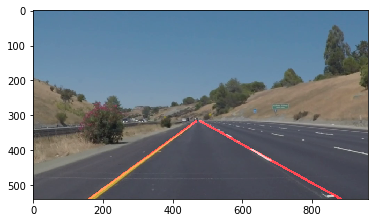

In [14]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))